# Transformer（下）

**0 前言**<br>
&nbsp;&nbsp;&nbsp;&nbsp;0.1 Transformer模型的地位与发展历程<br>
&nbsp;&nbsp;&nbsp;&nbsp;0.2 序列模型的基本思路与根本诉求<br>

**1 注意力机制**<br>
&nbsp;&nbsp;&nbsp;&nbsp;1.1 注意力机制的本质<br>
&nbsp;&nbsp;&nbsp;&nbsp;1.2 Transformer中的自注意力机制运算流程<br>
&nbsp;&nbsp;&nbsp;&nbsp;1.3 Multi-Head Attention 多头注意力机制<br>

**2 Transformer的基本结构**<br>
&nbsp;&nbsp;&nbsp;&nbsp;2.1 Embedding层与位置编码技术<br>
&nbsp;&nbsp;&nbsp;&nbsp;2.2 Encoder结构解析<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.2.1 残差连接<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.2.2 Layer Normalization层归一化<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.2.3 Feed-Forward Networks前馈网络<br>
&nbsp;&nbsp;&nbsp;&nbsp;2.3 Decoder结构解析<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.3.1 完整Transformer与Decoder-Only结构的数据流<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.3.2 Encoder-Decoder结构中的Decoder<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.3.2.1 输入与teacher forcing<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.3.2.2 掩码注意力机制<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.3.2.3 普通掩码与前馈掩码<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.3.2.4 编码器-解码器注意力层<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.3.3 Decoder-Only结构中的Decoder<br>

===================以上内容见Transformer（上）=====================

**3 Transformer的PyTorch实战**<br>
&nbsp;&nbsp;&nbsp;&nbsp;3.1 PyTorch中的Transformer层<br>
&nbsp;&nbsp;&nbsp;&nbsp;3.2 Encoder-Only任务下的Trnasformer实战<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2.1 Encoder-Only任务下的Transformer架构<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2.1.1 Embedding层与Encoder数据输入<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2.1.2 位置编码的实现与技巧<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2.1.3 从0实现编码器Only架构<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2.2 【实战】Transformer的情感分类案例<br>
&nbsp;&nbsp;&nbsp;&nbsp;3.3 Decoder-Only任务下的Trnasformer实战<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.3.1 Decoder-Only任务下的Transformer架构<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.3.2 Transformer的文字生成实战<br>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 3 PyTorch中与Huggingface中的Transformer实现

## 3.1 PyTorch中的Transformer层

在之前的课程当中，我们已经认识了PyTorch框架的基本结构，整个PyTorch框架可以大致被分Torch和成熟AI领域两大板块，其中Torch包含各类神经网络组成元素、用于构建各类神经网络，各类AI领域中则包括Torchvision、Torchtext、Torchaudio等辅助完成图像、文字、语音方面各类任务的领域模块。

在PyTorch中，Transformer算法是属于“构建循环神经网络的元素”，而非“成熟神经网络”，因此Transformer是位于PyTorch.nn这个基本模块下。为什么PyTorch中的Transformer结构是位于nn，而不是属于成熟神经网络呢？**事实上，在PyTorch中并没有完整的Transformer架构，只有用于构建Transformer的各个层**。我们一起来看一下。

<center><img src="https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/transformer/image-1.png" alt="描述文字" width="400">

在torch.nn模块下，存在**服务于Transformer架构的各类神经网络层和模型**，我们来看一下——

| 类名称                     | 作用                                          |
|--------------------------|---------------------------------------------|
| `nn.Transformer`          | 不带输入与输出层的 Transformer 模型，同时具备编码器和解码器                       |
| `nn.TransformerEncoder`   | Transformer 编码器的堆叠层，可以控制Nx的N的具体数字                    |
| `nn.TransformerDecoder`   | Transformer 解码器的堆叠层，可以控制Nx的N的具体数字                    |
| `nn.TransformerEncoderLayer` | Transformer 编码器层，由自注意力和前馈网络组成   |
| `nn.TransformerDecoderLayer` | Transformer 解码器层，由自注意力、编码器-解码器注意力和前馈网络组成 |
| `nn.MultiheadAttention`   | 多头注意力机制                               |
| `nn.LayerNorm`            | 层归一化层                                   |
| `nn.Embedding`            | 嵌入层，用于将输入序列转换为嵌入表示          |

- **nn.Transformer**

`nn.Transformer`封装了完整的Transformer结构。如下图所示，它对Encoder和Decoder两部分的包装，它并没有实现输入中的Embedding和Positional Encoding和最后输出的Linear+softmax部分。

<center><img src="https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/transformer/image-37.png" alt="描述文字" width="400">

- **分割的编码器与解码器**

`nn.TransformerEncoderLayer`与`nn.TransformerDecoderLayer`: 这两个类表示Transformer单一的编码器和单一的解码器（他们代表了架构图中展示的结构，而不包括Nx的部分）。他们都包含了自注意力机制（self-attention）、多头注意力机制（Multi-head Attention）和前馈网络（feedforward network），以及必要的归一化和残差连接。这两个层的区别在于：
> - DecoderLayer默认带有teacher forcing机制，而Encoder layer则没有这个机制。<br><br>
> - DecoderLayer带有的Multi-head Attention层可以用来处理编码器-解码器注意力层中的运算，但是EncoderLayer中带有的多头注意力层却没有这个机制。

`nn.TransformerEncoder`与`nn.TransformerDecoder`: 这两个类是将单一解码器和单一编码器堆叠后构成的解码器、编码器串，其中`nn.TransformerEncoder`包含了多个nn.TransformerEncoderLayer层的堆叠，`nn.TransformerDecoder`包含了多个nn.TransformerDecoderLayer层的堆叠。

<center><img src="https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/transformer/image-38.png" alt="描述文字" width="800">

除此之外，我们还有：

`nn.MultiheadAttention`: 这个模块实现了多头注意力机制，这是Transformer模型的核心组件之一。多头注意力允许模型在不同的位置同时处理来自序列不同部分的信息，这有助于捕捉序列内的复杂依赖关系。

`nn.LayerNorm`: 层归一化（Layer Normalization）通常用在Transformer的各个子层的输出上，有助于稳定训练过程，并且提高了训练的速度和效果。

`nn.Embedding`：一个预训练好的语义空间，它将每个标记（如单词、字符等）映射到一个高维空间的向量。这使得模型能够处理文本数据，并为每个唯一的标记捕获丰富的语义属性。嵌入层通常是自然语言处理模型的第一层，用于将离散的文本数据转化为连续的向量表示。其输入是索引列表，输出是对应的嵌入向量。

`nn.Transformer.generate_square_subsequent_mask`：掩码函数。用于生成一个方形矩阵，用作Transformer模型中自注意力机制的上三角遮罩。这个遮罩确保在序列生成任务中，例如语言模型中，任何给定的元素只会考虑到序列中先于它的元素（即它只能看到过去的信息，不能看到未来的信息）。这种掩码通常在解码器部分使用，防止在预测下一个输出时“作弊”。具体来说，该函数创建了一个方阵，其中对角线及其以下的元素为0（表示可以“看到”这些位置的元素），其余元素为负无穷大（在softmax之前应用，表示位置被屏蔽，不应该有注意力权重）。

In [2]:
import torch.nn as nn

In [3]:
nn.Transformer.generate_square_subsequent_mask(5) # 5指的是target的维度

tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]])

| 类名称                     | 作用                                          |
|--------------------------|---------------------------------------------|
| `nn.Transformer`          | 不带输入与输出层的 Transformer 模型，同时具备编码器和解码器                       |
| `nn.TransformerEncoder`   | Transformer 编码器的堆叠层，可以控制Nx的N的具体数字                    |
| `nn.TransformerDecoder`   | Transformer 解码器的堆叠层，可以控制Nx的N的具体数字                    |
| `nn.TransformerEncoderLayer` | Transformer 编码器层，由自注意力和前馈网络组成   |
| `nn.TransformerDecoderLayer` | Transformer 解码器层，由自注意力、编码器-解码器注意力和前馈网络组成 |
| `nn.MultiheadAttention`   | 多头注意力机制                               |
| `nn.LayerNorm`            | 层归一化层                                   |
| `nn.Embedding`            | 嵌入层，用于将输入序列转换为嵌入表示          |

**在这些所有类中，我们最应该关注的是nn.TransformerEncoderLayer与nn.TransformerDecoderLayer**。这两个层赋予Transformer架构极高的灵活性，大部分时候我们也是会通过这两个层来自定义各种各样丰富的Transformer结构。

- <font color="red">**CLASS`torch.nn.TransformerEncoderLayer`(d_model, nhead, dim_feedforward=2048, dropout=0.1, activation=\<function relu\><function relu>, layer_norm_eps=1e-05, batch_first=False, norm_first=False, bias=True, device=None, dtype=None)**

In [4]:
#(batch_size, seq_len, input_dimensions)

| 实例化前-参数名称           | 说明                                                                                     |
|--------------------|------------------------------------------------------------------------------------------|
| `d_model`          | 输入的嵌入维度（Embedding过程中规定的特征维度），数学公式中的$d_k$                          |
| `nhead`            | 多头注意力机制中的头数，在代码中通常表示为num_heads                                           |
| `dim_feedforward`  | 前馈网络的隐藏层维度，默认值为 2048。                                                    |
| `dropout`          | Dropout 概率，默认值为 0.1。在Transformer架构图中虽然没有展现dropout层，但现在业内习惯于将Dropout层放置在每一个复杂结构之后，在Encoder中，Dropout出现在自注意力层后、残差链接之前，也出现在前馈神经网络后、残差链接之前|
| `activation`       | 激活函数，默认值为 `relu`。                                                              |
| `layer_norm_eps`   | 层归一化的 epsilon 值，默认值为 1e-05。                                                  |
| `batch_first`      | 如果为 `True`，则输入和输出张量的形状为 `(batch_size, seq_len, feature)`，否则为 `(seq_len, batch_size, feature)`。默认值为 `False`。 |
| `norm_first`       | 如果为 `True`，则执行前馈网络之前进行层归一化。默认值为 `False`。                        |
| `bias`             | 如果为 `True`，则在线性层中使用偏置。默认值为 `True`。                                  |
| `device`           | 指定层的设备，默认值为 `None`。                                                         |
| `dtype`            | 指定层的数据类型，默认值为 `None`。                                                     |

In [5]:
encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8, batch_first=True)
src = torch.rand(32, 10, 512)
out = encoder_layer(src)

In [6]:
out.shape #经过多头注意力机制、残差链接、前馈网络、层归一化，但完全不改变数据结构

torch.Size([32, 10, 512])

In [ ]:
前瞻 - 上三角(seq_len, seq_len)
填充 - 每张表会有不同的掩码 (batch_size, seq_len)

`torch.nn.TransformerEncoderLayer`实例化后可以输入的内容有：

| 实例化后-参数名称              | 说明                                                                                                                         |
|------------------------------|------------------------------------------------------------------------------------------------------------------------------|
| `src`                        | 输入到编码器层的序列（必填）。                                                                                                 |
| `src_mask`                   | 输入序列的掩码矩阵（可选），默认接收形状为(seq_len, seq_len)的二维矩阵，通常该参数默认是执行前瞻掩码，在encoder中很少使用。                                                                                                       |
| `src_key_padding_mask`       | 输入序列的填充掩码矩阵（可选），默认接收形状为(batch_size, seq_len)的二维矩阵，这个参数只提供给填充掩码使用。                                                                                             |

In [7]:
def create_padding_mask(seq, pad_token=0):
    # seq: (batch_size, seq_len, embedding_dim)
    # 检查填充值位置
    padding_mask = (seq == pad_token).all(dim=-1)  # (batch_size, seq_len)
    padding_mask = padding_mask.float() * -1e9
    
    return padding_mask

def create_look_ahead_mask(seq_len, start_seq=1):
    mask = torch.triu(torch.ones((seq_len, seq_len)), diagonal=start_seq)  # 上三角矩阵
    mask = mask.float() * -1e9  # 将未来的位置设置为负无穷大
    return mask  # (seq_len, seq_len)

In [8]:
src.shape

torch.Size([32, 10, 512])

In [9]:
src_key_padding_mask = create_padding_mask(src,pad_token=0)
src_mask = create_look_ahead_mask(10,start_seq=1) #其实一般对于encoder中的数据并不会去使用

In [10]:
src_key_padding_mask.shape #batch_size, seq_len

torch.Size([32, 10])

In [11]:
src_mask.shape #seq_len, seq_len

torch.Size([10, 10])

In [12]:
encoder_layer(src
              ,src_mask = src_mask
              , src_key_padding_mask = src_key_padding_mask).shape #结构不变，但数值是增加了掩码的数值

torch.Size([32, 10, 512])

In [13]:
encoder_layer(src,src_mask = src_mask, src_key_padding_mask = src_key_padding_mask)[0]

tensor([[ 0.6185,  0.9043,  0.2690,  ..., -0.7528, -2.6922, -0.0568],
        [ 0.2093, -0.3952, -0.3863,  ..., -1.9490, -1.0719, -0.1734],
        [-0.8843, -0.0294, -1.2462,  ..., -1.0629, -0.4550, -0.0064],
        ...,
        [-0.7402, -1.7728,  0.7999,  ..., -0.9688, -0.4042, -0.5975],
        [ 0.0606,  0.5342,  0.0650,  ...,  0.2278, -0.4304,  1.4630],
        [-1.1481,  0.0796, -1.1551,  ..., -1.1815, -1.2460, -0.9036]],
       grad_fn=<SelectBackward0>)

- <font color="red">**CLASS`torch.nn.TransformerDecoderLayer`(d_model, nhead, dim_feedforward=2048, dropout=0.1, activation=\<function relu\>, layer_norm_eps=1e-05, batch_first=False, norm_first=False, bias=True, device=None, dtype=None)**

不难发现，TransformerDecoderLayer的参数与TransformerEncoderLayer的参数完全一致——

| 实例化前-参数名称           | 说明                                                                                     |
|--------------------|------------------------------------------------------------------------------------------|
| `d_model`          | 输入的嵌入维度（Embedding过程中规定的特征维度），数学公式中的$d_k$                          |
| `nhead`            | 多头注意力机制中的头数，在代码中通常表示为num_heads                                           |
| `dim_feedforward`  | 前馈网络的隐藏层维度，默认值为 2048。                                                    |
| `dropout`          | Dropout 概率，默认值为 0.1。在Transformer架构图中虽然没有展现dropout层，但现在业内习惯于将Dropout层放置在每一个复杂结构之后，在Encoder中，Dropout出现在自注意力层后、残差链接之前，也出现在前馈神经网络后、残差链接之前|
| `activation`       | 激活函数，默认值为 `relu`。                                                              |
| `layer_norm_eps`   | 层归一化的 epsilon 值，默认值为 1e-05。                                                  |
| `batch_first`      | 如果为 `True`，则输入和输出张量的形状为 `(batch_size, seq_len, feature)`，否则为 `(seq_len, batch_size, feature)`。默认值为 `False`。 |
| `norm_first`       | 如果为 `True`，则执行前馈网络之前进行层归一化。默认值为 `False`。                        |
| `bias`             | 如果为 `True`，则在线性层中使用偏置。默认值为 `True`。                                  |
| `device`           | 指定层的设备，默认值为 `None`。                                                         |
| `dtype`            | 指定层的数据类型，默认值为 `None`。                                                     |

In [ ]:
encoder - inputs + 掩码 ==> memory/system/conditions
decoder - outputs、memory

In [ ]:
inputs = 这 是 最好的 时代
outputs = it was the best of time

In [14]:
decoder_layer = nn.TransformerDecoderLayer(d_model=512, nhead=8, batch_first=True)
#需要输入的结构为来自Encoder的信息Memory，以及直接输入给Decoder的信息target
memory = torch.rand(32, 10, 512)
tgt = torch.rand(32, 20, 512)
out = decoder_layer(tgt, memory)

In [15]:
out.shape #经过自注意力机制、编码-解码器注意力机制和前馈神经网络，输出结构与tgt一致

torch.Size([32, 20, 512])

`torch.nn.TransformerDecoderLayer`实例化后可以输入的内容有：

| 实例化后-参数名称              | 说明                                                                                                                         |
|------------------------------|------------------------------------------------------------------------------------------------------------------------------|
| `tgt`                        | 输入到解码器层的序列（必填），通常来说也就是真实标签                                                                                                |
| `memory`                     | 来自编码器最后一层的序列（必填）。                                                                                            |
| `tgt_mask`                   | 目标序列的掩码（可选），默认接收形状为(seq_len, seq_len)的二维矩阵，**通常该参数默认是执行前瞻掩码**。                                                                                                      |
| `memory_mask`                | 编码器输出序列的掩码（可选），默认接收形状为(seq_len, seq_len)的二维矩阵，**通常该参数默认是执行前瞻掩码**，但由于是作用于编码器的结果，因此实际很少使用。                                                                                                 |
| `tgt_key_padding_mask`       | 目标序列的填充掩码矩阵（可选），默认接收形状为(batch_size, seq_len)的二维矩阵，这个参数只提供给填充掩码使用。                                                                                             |
| `memory_key_padding_mask`    | 编码器输出序列的填充掩码矩阵（可选），默认接收形状为(batch_size, seq_len)的二维矩阵，这个参数只提供给填充掩码使用。                                                                                       |

由于解码器本身有两部分输入（真实标签和来自编码器的输入），每一种输入又分别被允许填充掩码和前瞻掩码、因此2种输入 + 每种输入允许的2种掩码，就被允许输入至少6个参数。

In [16]:
tgt.shape

torch.Size([32, 20, 512])

In [17]:
tgt_key_padding_mask = create_padding_mask(tgt,pad_token=0)
tgt_mask = create_look_ahead_mask(tgt.shape[1],start_seq=1)

In [18]:
tgt_key_padding_mask.shape

torch.Size([32, 20])

In [19]:
tgt_mask.shape

torch.Size([20, 20])

In [20]:
#结构不变，但数值是增加了掩码的数值
decoder_layer(tgt,memory,tgt_mask = tgt_mask, tgt_key_padding_mask = tgt_key_padding_mask).shape 

torch.Size([32, 20, 512])

- <font color="red">**CLASS`torch.nn.TransformerEncoder`(encoder_layer, num_layers, norm=None, enable_nested_tensor=True, mask_check=True)**

- <font color="red">**CLASS`torch.nn.TransformerDecoder`(decoder_layer, num_layers, norm=None, enable_nested_tensor=True, mask_check=True)**

TransformerEncoder类与TransformerDecoder中的几大参数则非常简单，其中encoder_layer这个参数中输入的就是定义好的TransformerEncoderLayer层，decoder_layer这个参数输入的就是定义好的TransformerDecoderLayer，num_layers则决定了当前Transformer中一共有多少个子层。

In [21]:
decoder_layer = nn.TransformerDecoderLayer(d_model=512, nhead=8)

#如Transformer的论文中规定的一样，有6个Decoder层
transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)
memory = torch.rand(10, 32, 512) #没有batch_first，因此结构是(seq_len, batch_size, input_dimensions)
tgt = torch.rand(20, 32, 512)

#输出
out = transformer_decoder(tgt, memory)

In [22]:
out.shape #依然是结构不变

torch.Size([20, 32, 512])

In [ ]:
softmax((QK.T)/dk)*V

In [ ]:
decoder ==> tgt （32,20,512） Q
encoder ==> memory （32,10,512） K V

> 两个关键问题：<br><br>
> **1. Encoder输出的矩阵结构与Decoder中的tgt结构不一致，是如何在编码解码器层中合并的？**<br><br>
> **2. 编码解码器层是如何通过多头注意力机制实现的？**

tips：编码器-解码器注意力机制中，下列方程并行实现，一共会有多少个方程呢？**由Q中的行数决定。因此解码器最终的输出的序列长度也是与Q的行数一致**。

$$\text{Context}_1 = \sum_{i} \text{Attention}(Q_1, K_i) \times V_i$$

$$\text{Context}_2 = \sum_{i} \text{Attention}(Q_2, K_i) \times V_i$$

$$\text{Context}_3 = \sum_{i} \text{Attention}(Q_3, K_i) \times V_i$$

In [ ]:
PyTorch - nn.MultiheadAttention ==> Q、K、V

1) 认为在attention层前面去添加nn.Linear来帮助你生成QKV
2) Q、K、V的具体状态是自由的，只要矩阵能相乘、只要矩阵乘法上不出错，Q、K、V可以是任何的模样

In [ ]:
tgt (32,20,512) == > 20头注意力机制

head1 => 和KV结构一致，但是全部由Q1构成的矩阵
head2 => 和KV结构一致，但是全部由Q2构成的矩阵

K\V (10,512)

Q (10,512) ==> expanding\广播

## 3.2 Encoder-Only任务下的Transformer实战

不难发现，torch.nn下面配置了一系列构成transformer的元素，但是却没有构成完整的Transformer算法。正如我们 之前提到的那样，在NLP的世界中，不同的任务会对Transformer架构提出不同的要求，编码器和解码器是设计成可以独立或一起使用的组件。它们可以根据不同的NLP任务需求进行组合，以适应各种场景。

### 3.2.1 Encoder-Only任务下的Transformer架构

- **只使用编码器的任务**：编码器部分的任务是从输入数据中提取特征。编码器通常用于不需要生成新文本序列的任务，比如：
> 文本分类：如情感分析，垃圾邮件检测等，输入一个文本序列，编码器提取特征后进行分类。<br><br>
> 命名实体识别（Named Entity Recognition, NER）：在给定文本中识别出实体（如人名、地点等），这也是分类问题的一种，可以用编码器提取文本的特征。<br><br>
> 句子相似度：判断两个句子是否相关或相似度如何，可以通过编码器提取句子特征后计算相似度。

Encoder-only架构应该包括如下结构：

1. **输入层**：输入序列会通过一个嵌入层，将每个词转换为一个向量表示。
2. **位置编码**：添加位置编码，以保留序列中词的位置信息。
3. **Transformer 编码器**：使用多个编码器层堆叠，以处理输入序列。
4. **输出层**：将编码器输出的表示转换为目标任务所需的输出。

#### 3.2.1.1 Embedding层与Encoder数据输入

<font color="red">**CLASS`torch.nn.Embedding`(num_embeddings, embedding_dim, padding_idx=None, max_norm=None, norm_type=2.0, scale_grad_by_freq=False, sparse=False, _weight=None, _freeze=False, device=None, dtype=None)</font>**
> **num_embeddings**：词汇表的总长，即词汇表中包含的单词总数量<br><br>
> **embedding_dim**：每个单词需要被变成的维度，即transformer中的d_model

In [41]:
ebd = nn.Embedding(2000, 512)

embedding可以接纳各式各样维度的数据——

In [45]:
input_data = torch.tensor([1,2,3,4,5]) #(5,)

In [37]:
ebd(input_data).shape

torch.Size([5, 512])

In [42]:
# 假设有两个序列，每个序列包含5个词
input_data = torch.tensor([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]])

In [43]:
input_data #(2,5)

tensor([[ 1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10]])

In [44]:
ebd(input_data).shape

torch.Size([2, 5, 512])

不难发现，无论我们对embedding层输入怎样的数据，它只会将最后的维度拓展为我们设置的d_model，并不对其他结构进行改变。

In [69]:
# 尝试一段真实的文字作为输入
# 从一段话变为能够输入到embedding层的信息，还需经过以下的步骤：
# 1)分词 2)制作词汇表 3)依据词汇表编码 4)填充编码后序列，形成统一的seq_len

In [46]:
import jieba
from collections import Counter
import torch

# 输入文本
text1 = """朝堂是谁的朝堂，天下又是谁的天下——庆帝的文武百官绝不敢轻易忤逆或直谏，\\
夹缝里喘息，贪污，结党，企图吞噬一点点这肮脏血腥的权力，却落得个死无葬身之地，\\
他想起赖明成，陈萍萍，那些一个个被处以极刑的大臣，他与承乾自孩提时代就见识过权力只是一把刀子，\\
一场流血，一个个微不足道的死亡，于是他们恐惧又愤恨，他们开始认为阴谋诡计是一种力量，\\
非要一刀见血，才是一次胜利，嬴的人才配活着，与野兽何异？他们在跟谁争，\\
只有庆帝一个人把握着权柄，把它高高挂起，高于良知，高于品德，高于世间万物，\\
他们竟然在争抢这样一个丑陋又卑鄙，散发着腐烂恶臭的东西。"""

text2 = """人心？那我亏大了，自抬身价罢了。你觉得他们会感激我，那都是一时的，\\
他们求的是自己想要的东西，我满足了一时片刻，他们就想要有别的东西了，\\
这点儿不长久的人心算什么人心。你看那些古来文人大家，那庄墨韩，人人追捧，\\
高高在上，不容亵渎，一字换一城也毫不夸张，是笔墨纸张值钱，还是他们的名气？\\
就像是最近给你送礼攀关系那些人一样的，他们为的不是一时的东西，我也不能做那一\\
时的玩意儿。”李承泽收回目光，转过身来，他握紧了自己的一双手，直视着谢必安冰冷\\
宛如冬夜般的眼睛，“必安，你得明白，东宫太子有父母，有名头，有朝臣，陛下，\\
拥有这个天下的人和财权，我只有我自己，但是我要让你知道的是，这些他们有的，\\
不见得一直有，我依然有我自己。"""

# 使用 jieba 进行分词，要对所有的文本进行分词
words = jieba.lcut(text1 + " " + text2)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Shuyu\AppData\Local\Temp\jieba.cache
Loading model cost 0.542 seconds.
Prefix dict has been built successfully.


In [47]:
words

['朝堂',
 '是',
 '谁',
 '的',
 '朝堂',
 '，',
 '天下',
 '又',
 '是',
 '谁',
 '的',
 '天下',
 '—',
 '—',
 '庆帝',
 '的',
 '文武百官',
 '绝',
 '不敢',
 '轻易',
 '忤逆',
 '或',
 '直谏',
 '，',
 '\\',
 '\n',
 '夹缝',
 '里',
 '喘息',
 '，',
 '贪污',
 '，',
 '结党',
 '，',
 '企图',
 '吞噬',
 '一点点',
 '这',
 '肮脏',
 '血腥',
 '的',
 '权力',
 '，',
 '却',
 '落得',
 '个',
 '死无葬身之地',
 '，',
 '\\',
 '\n',
 '他',
 '想起',
 '赖明成',
 '，',
 '陈萍萍',
 '，',
 '那些',
 '一个个',
 '被',
 '处以',
 '极刑',
 '的',
 '大臣',
 '，',
 '他',
 '与',
 '承乾自',
 '孩提时代',
 '就',
 '见识',
 '过',
 '权力',
 '只是',
 '一把',
 '刀子',
 '，',
 '\\',
 '\n',
 '一场',
 '流血',
 '，',
 '一个个',
 '微不足道',
 '的',
 '死亡',
 '，',
 '于是',
 '他们',
 '恐惧',
 '又',
 '愤恨',
 '，',
 '他们',
 '开始',
 '认为',
 '阴谋诡计',
 '是',
 '一种',
 '力量',
 '，',
 '\\',
 '\n',
 '非',
 '要',
 '一刀',
 '见血',
 '，',
 '才',
 '是',
 '一次',
 '胜利',
 '，',
 '嬴',
 '的',
 '人才',
 '配',
 '活着',
 '，',
 '与',
 '野兽',
 '何异',
 '？',
 '他们',
 '在',
 '跟',
 '谁',
 '争',
 '，',
 '\\',
 '\n',
 '只有',
 '庆帝',
 '一个',
 '人',
 '把握',
 '着',
 '权柄',
 '，',
 '把',
 '它',
 '高高挂起',
 '，',
 '高于',
 '良知',
 '，',
 '高于',
 '品德',
 '，',
 '高于',
 '世间

In [48]:
# 统计词频并生成词汇表
word_counts = Counter(words)
vocab = {word: idx for idx, (word, _) in enumerate(word_counts.items(), 1)}  # 从1开始编码，0留给padding

In [49]:
word_counts

Counter({'朝堂': 2,
         '是': 8,
         '谁': 3,
         '的': 21,
         '，': 55,
         '天下': 3,
         '又': 3,
         '—': 2,
         '庆帝': 2,
         '文武百官': 1,
         '绝': 1,
         '不敢': 1,
         '轻易': 1,
         '忤逆': 1,
         '或': 1,
         '直谏': 1,
         '\\': 14,
         '\n': 14,
         '夹缝': 1,
         '里': 1,
         '喘息': 1,
         '贪污': 1,
         '结党': 1,
         '企图': 1,
         '吞噬': 1,
         '一点点': 1,
         '这': 1,
         '肮脏': 1,
         '血腥': 1,
         '权力': 2,
         '却': 1,
         '落得': 1,
         '个': 1,
         '死无葬身之地': 1,
         '他': 3,
         '想起': 1,
         '赖明成': 1,
         '陈萍萍': 1,
         '那些': 3,
         '一个个': 2,
         '被': 1,
         '处以': 1,
         '极刑': 1,
         '大臣': 1,
         '与': 2,
         '承乾自': 1,
         '孩提时代': 1,
         '就': 3,
         '见识': 1,
         '过': 1,
         '只是': 1,
         '一把': 1,
         '刀子': 1,
         '一场': 1,
         '流血': 1,
         '

In [70]:
vocab #是词汇表，包含了每个词和对应的索引

{'朝堂': 1,
 '是': 2,
 '谁': 3,
 '的': 4,
 '，': 5,
 '天下': 6,
 '又': 7,
 '—': 8,
 '庆帝': 9,
 '文武百官': 10,
 '绝': 11,
 '不敢': 12,
 '轻易': 13,
 '忤逆': 14,
 '或': 15,
 '直谏': 16,
 '\\': 17,
 '\n': 18,
 '夹缝': 19,
 '里': 20,
 '喘息': 21,
 '贪污': 22,
 '结党': 23,
 '企图': 24,
 '吞噬': 25,
 '一点点': 26,
 '这': 27,
 '肮脏': 28,
 '血腥': 29,
 '权力': 30,
 '却': 31,
 '落得': 32,
 '个': 33,
 '死无葬身之地': 34,
 '他': 35,
 '想起': 36,
 '赖明成': 37,
 '陈萍萍': 38,
 '那些': 39,
 '一个个': 40,
 '被': 41,
 '处以': 42,
 '极刑': 43,
 '大臣': 44,
 '与': 45,
 '承乾自': 46,
 '孩提时代': 47,
 '就': 48,
 '见识': 49,
 '过': 50,
 '只是': 51,
 '一把': 52,
 '刀子': 53,
 '一场': 54,
 '流血': 55,
 '微不足道': 56,
 '死亡': 57,
 '于是': 58,
 '他们': 59,
 '恐惧': 60,
 '愤恨': 61,
 '开始': 62,
 '认为': 63,
 '阴谋诡计': 64,
 '一种': 65,
 '力量': 66,
 '非': 67,
 '要': 68,
 '一刀': 69,
 '见血': 70,
 '才': 71,
 '一次': 72,
 '胜利': 73,
 '嬴': 74,
 '人才': 75,
 '配': 76,
 '活着': 77,
 '野兽': 78,
 '何异': 79,
 '？': 80,
 '在': 81,
 '跟': 82,
 '争': 83,
 '只有': 84,
 '一个': 85,
 '人': 86,
 '把握': 87,
 '着': 88,
 '权柄': 89,
 '把': 90,
 '它': 91,
 '高高挂起': 92,
 '高于': 9

In [60]:
# 将分词结果转换为索引序列
texts = []
max_len = 0

for text in [text1,text2]:
    #将编码映射到每个词上
    encoded_sequence = [vocab[word] for word in jieba.lcut(text)]
    texts.append(encoded_sequence)

    #确认max_len是多少
    if len(encoded_sequence) > max_len:
        max_len = len(encoded_sequence)

In [64]:
max_len

219

In [65]:
#依据max_len对句子进行填充
sequence = []
for text in texts:
    padding_text = text + [0] * (max_len - len(text))
    sequence.append(padding_text)  # 使用0进行padding

In [67]:
# 转换为 PyTorch 张量
sequences = torch.tensor(sequence)

In [74]:
sequences
#形状为(2, 句子长度)的 PyTorch 张量，其中每个序列都被填充到相同的长度，这就是输入Transformer的数据X
#当然，在Encoder-Only结构中，我们还需要关注标签，我们需要使用dataloder打包标签，给损失函数使用

tensor([[  1,   2,   3,   4,   1,   5,   6,   7,   2,   3,   4,   6,   8,   8,
           9,   4,  10,  11,  12,  13,  14,  15,  16,   5,  17,  18,  19,  20,
          21,   5,  22,   5,  23,   5,  24,  25,  26,  27,  28,  29,   4,  30,
           5,  31,  32,  33,  34,   5,  17,  18,  35,  36,  37,   5,  38,   5,
          39,  40,  41,  42,  43,   4,  44,   5,  35,  45,  46,  47,  48,  49,
          50,  30,  51,  52,  53,   5,  17,  18,  54,  55,   5,  40,  56,   4,
          57,   5,  58,  59,  60,   7,  61,   5,  59,  62,  63,  64,   2,  65,
          66,   5,  17,  18,  67,  68,  69,  70,   5,  71,   2,  72,  73,   5,
          74,   4,  75,  76,  77,   5,  45,  78,  79,  80,  59,  81,  82,   3,
          83,   5,  17,  18,  84,   9,  85,  86,  87,  88,  89,   5,  90,  91,
          92,   5,  93,  94,   5,  93,  95,   5,  93,  96,  97,   5,  17,  18,
          59,  98,  81,  99, 100,  85, 101,   7, 102,   5, 103,  88, 104, 105,
           4, 106, 107,   0,   0,   0,   0,   0,   0

In [73]:
ebd = nn.Embedding(2000, 512)
ebd(sequences).shape

torch.Size([2, 219, 512])

需要注意的是，**在实际构建Encoder时，Embedding 层既可以写在 Encoder 的结构中，也可以单独写**。如果将Embedding层写在Encoder结构中，代码会整洁，所有与模型相关的部分都在同一个类中，便于维护，但这个操作相当于将整个Transformer结构的输入数据由(batch_size, seq_len, input_dimensions)结构修改为了(batch_size, seq_len)结构、从而会影响掩码的结构、影响掩码函数、这个Embedding层无法与Decoder或其他算法共用、甚至可能导致你的Encoder结构无法用于时间序列任务；如果我们将Embedding层写在Encoder结构之外，灵活性更高，可以在多个模型中共享同一个 Embedding 层，也可以对Embedding后的结果进行更加顺畅的独立处理，但缺点是就需要额外的代码来管理Embedding层的初始化和传递。在实际进行编程时，Embedding结构究竟写在Encoder内还是外，与你的数据和实现的架构有很大的关系，你需要根据具体情况进行具体的分析。

#### 3.2.1.2 位置编码的实现与技巧

首先，正弦余弦位置编码的公式如下：

> - 正弦位置编码（Sinusoidal Positional Encoding）
$$PE_{(pos, 2i)} = \sin \left( \frac{pos}{10000^{\frac{2i}{d_{\text{model}}}}} \right) $$

> - 余弦位置编码（Cosine Positional Encoding）
$$ PE_{(pos, 2i+1)} = \cos \left( \frac{pos}{10000^{\frac{2i}{d_{\text{model}}}}} \right) $$

其中——
> - pos代表样本在序列中的位置，也就是样本的索引（是三维度中的seq_len/vocal_size/time_step这个维度上的索引）<br><br>
> - $2i$和$2i+1$分别代表embedding矩阵中的偶数和奇数维度索引，当我们让i从0开始循环增长时，可以获得[0,1,2,3,4,5,6...]这样的序列。<br><br>
> - $d_{\text{model}} $ 代表embedding后矩阵的总维度。

![Alt text](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/transformer/image-4.png)

正弦余弦编码的具体代码时下方式如下 ↓

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        """
        创造位置编码层（设定为batch_first=False模式）
        
        参数:
        d_model (int): 嵌入向量的维度。
        dropout (float): Dropout 概率。
        max_len (int): 序列的最大长度（注意与矩阵中的seq_len区分开来）
        """
        super(PositionalEncoding, self).__init__()

        # 位置编码作为精确到每一个维度的信息，容易导致过拟合
        # 因此在实际实践位置编码的时候我们会加上扛过拟合的dropout
        self.dropout = nn.Dropout(p=dropout)

        # 创建一个空白的编码矩阵，形状为 (max_len, d_model)
        # 通过给空白的位置编码矩阵填上具体值，来构成真正的位置编码矩阵
        pe = torch.zeros(max_len, d_model)

        # 接下来开始生成正弦余弦编码公式中的各个元素
        # 位置索引 (pos)，形状为 (max_len, 1)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        
        # 计算公式中的分母，由于分母会随着特征的编号i发生变化，因此要根据不同的i计算出不同的分母
        # 应用于sin的偶数列和应用于cos的奇数列的数目是一致的，分别占原始特征的1/2
        # 同时，应用于sin和cos公式的分母都是一致的
        # 因此我们只需要计算出一组分母，就可以给sin和cos函数通用，这组分母的数量是 d_model/2
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))

        # 计算出分母后，计算出正弦余弦值，并赋值给原本设置好的位置编码矩阵
        # 计算正弦位置编码: PE(pos, 2i) = sin(pos / 10000^(2i/d_model))
        # 所有行上、从0开始、每2列赋予一个sin值
        pe[:, 0::2] = torch.sin(position * div_term)
        
        # 计算余弦位置编码: PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
        # 所有行上，从1开始，每2列赋予一个cos值
        pe[:, 1::2] = torch.cos(position * div_term)

        # 正弦余弦位置编码加起来的结构应该等于d_model
        
        # 使用unsquezze添加batch维度，将原本二维的结构转变为三维，形状变为 (1, max_len, d_model)
        # 又使用transpose交换了维度，因此pe的最终结构是(max_len, 1, d_model)，这是batch_first=False下合理的结构
        pe = pe.unsqueeze(0).transpose(0, 1)
        # 位置编码与batch无关，因此对所有batch都是一样的
        # 最终会通过广播的方式复制成(seq_len, batch_size, input_dimension)上
        
        # 将位置编码矩阵注册为模型的缓冲区，不会作为模型参数更新
        # 同时，这一步相当于定义了self.pe，但规定pe不参与模型参数更新
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        前向传播函数，给输入添加位置编码。
        
        参数:
        x (Tensor): embedding后的张量，形状为 (batch_size, seq_len, d_model)
        
        返回值:
        Tensor: 添加了位置编码的输入张量，形状不变
        """
        # 添加位置编码，注意这里对位置编码进行了切片以匹配输入的序列长度
        # 也就是说，会根据x中的seq_len对原本设置的max_len进行裁剪
        # 为什么要在init中设置max_len，然后在forward中进行裁剪？
        x = x + self.pe[:x.size(0), :]
        
        # 应用 Dropout 并返回
        return self.dropout(x)

> 细节解读

In [7]:
#假定数据
x = torch.zeros(size=(32,10,8))

In [5]:
x.size(0)

32

In [8]:
#设置超参数值
max_len = 15
d_model = 8

In [9]:
#为生成的位置编码准备完整的矩阵

pe = torch.zeros(max_len, d_model)
pe.shape #直接生成一个能够与特征矩阵完美相加的矩阵

torch.Size([15, 8])

In [10]:
#生成用于公式中的位置索引本身（pos）

position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

In [11]:
position

tensor([[ 0.],
        [ 1.],
        [ 2.],
        [ 3.],
        [ 4.],
        [ 5.],
        [ 6.],
        [ 7.],
        [ 8.],
        [ 9.],
        [10.],
        [11.],
        [12.],
        [13.],
        [14.]])

In [12]:
#创造公式中的分母

$$10000^{\frac{2i}{d_{\text{model}}}}$$

In [13]:
torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model)).shape

torch.Size([4])

In [14]:
torch.arange(0, d_model, 2).float() #这就是2i

tensor([0., 2., 4., 6.])

让我们来看一下该段代码实现的具体公式：

$$
\exp\left(\left[0, 2, 4, \ldots, d_{\text{model}} - 2\right] \times \left(-\frac{\log(10000.0)}{d_{\text{model}}}\right)\right)
$$

解释：
- $[0, 2, 4, \ldots, d_{\text{model}} - 2]$ 表示从 0 到 `d_model` 以步长为 2 的整数序列，也就是2i
- $\log(10000.0)$ 是对 10000.0 取自然对数。
- $d_{\text{model}}$ 是嵌入向量的维度。
- $\exp$ 表示指数函数。

设 $ x = -\frac{\log(10000.0)}{d_{\text{model}}} $，则有——

则：
$$ \exp\left(\left[0, 2, 4, \ldots, d_{\text{model}} - 2\right] \times \left(-\frac{\log(10000.0)}{d_{\text{model}}}\right)\right) = e^{\left( [0, 2, 4, \ldots, d_{\text{model}} - 2] \cdot x \right)} $$

可以展开为：
$$ e^{0 \cdot x}, e^{2x}, e^{4x}, \ldots, e^{(d_{\text{model}} - 2) \cdot x} $$

以其中的$e^{2x}$为例——

$$
e^{-\frac{2 \cdot \log(10000.0)}{d_{\text{model}}}}
$$

其中对数函数 $\log$ 是以自然数 $e$ 为底，我们可以化简这个式子。根据指数的性质，$e^{-x} = \frac{1}{e^x}$，我们可以写成：

$$
e^{-\frac{2 \cdot \log(10000.0)}{d_{\text{model}}}} = \frac{1}{e^{\frac{2 \cdot \log(10000.0)}{d_{\text{model}}}}}
$$

接下来，我们知道$e^{a*log(x)} = (e^{log(x)})^a$，因此：

$$
e^{\frac{2 \cdot \log(10000.0)}{d_{\text{model}}}} = (e^{\log(10000.0)})^{(\frac{2}{d_{\text{model}}})}
$$

又因为$e^{\log(x)} = x$，因此：

$$
e^{\frac{2 \cdot \log(10000.0)}{d_{\text{model}}}} = 10000^{\frac{2}{d_{\text{model}}}}
$$

所以，最终的化简结果是：

$$
e^{ -\frac{2 \cdot \log(10000.0)}{d_{\text{model}}}} = \frac{1}{10000^{\frac{2}{d_{\text{model}}}}}
$$

因此——

$$
\exp\left(\left[0, 2, 4, \ldots, d_{\text{model}} - 2\right] \times \left(-\frac{\log(10000.0)}{d_{\text{model}}}\right)\right)
= \frac{1}{10000^{\frac{\left[0, 2, 4, \ldots, d_{\text{model}} - 2\right]}{d_{\text{model}}}}}$$

这个公式与正弦余弦位置编码的公式一致：$$PE_{(pos, 2i)} = \sin \left( \frac{pos}{10000^{\frac{2i}{d_{\text{model}}}}} \right) $$

In [ ]:
# 计算出分母后，计算出正弦余弦值，并赋值给原本设置好的位置编码矩阵
# 计算正弦位置编码: PE(pos, 2i) = sin(pos / 10000^(2i/d_model))
# 所有行上、从0开始、每2列赋予一个sin值
pe[:, 0::2] = torch.sin(position * div_term)

In [17]:
list_ = [1,2,3,4,5,6]

In [19]:
list_[0::2] #从0开始索引到最后一位数，但是步长为2

[1, 3, 5]

In [21]:
list_[1::2] #这是取出序列中奇数和偶数的常见方法

[2, 4, 6]

In [15]:
# 示例：定义并测试 PositionalEncoding 类

import time

d_model = 512
dropout = 0.1
max_len = 5000

# 创建一个示例输入张量，形状为 (batch_size, seq_len, d_model)
batch_size = 32
seq_len = 10
x = torch.randn(batch_size, seq_len, d_model)

# 实例化 PositionalEncoding 类
# 5000个位置编码是在此刻就计算完成的
start = time.time()
pos_encoder = PositionalEncoding(d_model, dropout, max_len)
print(time.time()-start)

0.003990888595581055


In [16]:
# 前向传播，添加位置编码
start = time.time()
output = pos_encoder(x)
print(time.time()-start)

0.0009982585906982422


In [ ]:
#看到消耗的时间差异了吗？这是我们设置max_len，而不直接设置seq_len的关键原因

In [17]:
print(output.shape)  # 输出的形状应为 (batch_size, seq_len, d_model)

torch.Size([32, 10, 512])


上面是针对每一个位置添加的512维的位置编码。**Embedding后的编码结构与位置编码需要是完全一致的结构**，这样便可以对应位置元素相加，构成Transformer所需要的完整的编码。有了完整的编码后，我们可以开始定义我们的Encoder了。

#### 3.2.1.3 从0实现编码器Only架构

In [180]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerEncoderModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout=0.1):
        """
        初始化 Transformer 编码器模型
        
        参数:
        input_dim (int): 输入的词汇表大小。
        d_model (int): 嵌入向量的维度。
        nhead (int): 多头注意力机制中的头数。
        num_encoder_layers (int): 编码器层的数量。
        dim_feedforward (int): 前馈网络的隐藏层维度。
        dropout (float): Dropout 概率。
        """
        super(TransformerEncoderModel, self).__init__()
        
        # 嵌入层，将输入的词汇索引转换为嵌入向量
        self.embedding = nn.Embedding(input_dim, d_model)
        
        # 位置编码层，添加位置信息以保留序列顺序
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        
        # 定义单个 Transformer 编码器层
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, 
                                                    dim_feedforward, dropout,
                                                    batch_first=True)
        
        # 堆叠多个 Transformer 编码器层
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers
                                                         , num_layers=num_encoder_layers)
        
        # 保存 d_model 维度，可能会用于后续计算
        self.d_model = d_model
        
        # 输出层，将 Transformer 编码器的输出转换为目标任务的输出
        # 用于回归任务
        self.fc_out = nn.Linear(d_model, 1) 

        """
        
        # 用于二分类任务
        self.fc_out = nn.Sequential(
            nn.Linear(d_model, 1),
            nn.Sigmoid()
        )

        # 用于多分类任务
        self.fc_out = nn.Sequential(
            nn.Linear(d_model, num_classes),
            nn.Softmax(dim=1)
        )

        """

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        """
        前向传播函数
        
        参数:
        src (Tensor): 进行embedding之前的张量，形状为 (batch_size, seq_len)
        src_mask: 前瞻掩码，输入结构为(seq_len, seq_len)
        src_key_padding_mask: 填充掩码，输入结构为(batch_size,seq_len)。
        
        返回值:
        Tensor: 模型的输出，形状为 (batch_size, 1)
        """
        # 将输入词汇索引转换为嵌入向量，并进行缩放
        # Scaled Embedding = Embedding × sqrt(d_model)
        # 这里为什么要进行缩放？
        src = self.embedding(src) * torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32))
        
        # 添加位置编码
        src = self.pos_encoder(src)
        
        # 通过 Transformer 编码器层进行编码
        output = self.transformer_encoder(src, mask=src_mask, src_key_padding_mask=src_key_padding_mask)
        
        # 对编码器的输出进行平均池化，获得序列的固定长度表示
        # 这一步同样也是对Transformer输出数据结构的整合
        # 如果Encoder的结果是直接输出给Decoder使用，很可能不需要这一步骤
        output = output.mean(dim=1)
        
        # 通过全连接层将固定长度表示转换为目标任务的输出
        output = self.fc_out(output)
        
        return output

在Transformer 模型中，对输入的嵌入向量进行缩放是一个常见的技巧，最早是在原始的 Transformer 论文《Attention Is All You Need》中提出的。我们来详细解释一下这种缩放的意义以及为什么要乘以 `torch.sqrt(torch.tensor(d_model))`。

> 缩放的意义
> 1. **防止数值过小**：在进行多头注意力机制时，输入的嵌入向量会与注意力权重矩阵相乘，如果嵌入向量的值过小，可能会导致梯度消失问题。通过缩放嵌入向量的值，可以减缓这种问题。<br><br>
> 2. **稳定训练过程**：缩放嵌入向量可以使注意力机制的计算更加稳定，从而有助于模型的训练。在论文中提到，通过缩放嵌入向量，可以使模型在训练初期更快地收敛。

In [153]:
d_model=512
torch.sqrt(torch.tensor(d_model))

tensor(22.6274)

In [182]:
# 示例：为Encoder-Only结构输入数据、跑通架构

In [155]:
sequences.shape #之前在embedding的例子中使用的序列

torch.Size([2, 219])

In [156]:
sequences

tensor([[  1,   2,   3,   4,   1,   5,   6,   7,   2,   3,   4,   6,   8,   8,
           9,   4,  10,  11,  12,  13,  14,  15,  16,   5,  17,  18,  19,  20,
          21,   5,  22,   5,  23,   5,  24,  25,  26,  27,  28,  29,   4,  30,
           5,  31,  32,  33,  34,   5,  17,  18,  35,  36,  37,   5,  38,   5,
          39,  40,  41,  42,  43,   4,  44,   5,  35,  45,  46,  47,  48,  49,
          50,  30,  51,  52,  53,   5,  17,  18,  54,  55,   5,  40,  56,   4,
          57,   5,  58,  59,  60,   7,  61,   5,  59,  62,  63,  64,   2,  65,
          66,   5,  17,  18,  67,  68,  69,  70,   5,  71,   2,  72,  73,   5,
          74,   4,  75,  76,  77,   5,  45,  78,  79,  80,  59,  81,  82,   3,
          83,   5,  17,  18,  84,   9,  85,  86,  87,  88,  89,   5,  90,  91,
          92,   5,  93,  94,   5,  93,  95,   5,  93,  96,  97,   5,  17,  18,
          59,  98,  81,  99, 100,  85, 101,   7, 102,   5, 103,  88, 104, 105,
           4, 106, 107,   0,   0,   0,   0,   0,   0

In [183]:
input_dim = 2000  # 词汇表大小
batch_size = 1
seq_len = 219
d_model = 512
nhead = 8
num_encoder_layers = 6
dim_feedforward = 2048
dropout = 0.1

model = TransformerEncoderModel(input_dim, d_model, nhead
                                , num_encoder_layers
                                , dim_feedforward, dropout)

In [184]:
# 模拟掩码 - Encoder-Only结构，无需前瞻掩码，只需填充掩码
# 当你的模型输入是(batch_size, seq_len, embedding_dim)时，你的填充掩码函数：
def create_padding_mask_1(seq, pad_token=0):
    # seq: (batch_size, seq_len, embedding_dim)
    # 检查填充值位置
    padding_mask = (seq == pad_token).all(dim=-1)  # (batch_size, seq_len)
    padding_mask = padding_mask.float() * -1e9
    return padding_mask

#当你的模型输入是(batch_size, seq_len)时，你的填充掩码函数：
def create_padding_mask_2(seq, pad_token=0):
    # seq: (batch_size, seq_len)
    # 创建一个与输入序列形状相同的掩码
    padding_mask = (seq == pad_token).float() * -1e9  # (batch_size, seq_len)
    return padding_mask

In [185]:
padding_mask = create_padding_mask_2(sequences,pad_token=0)

In [186]:
padding_mask.shape #batch_size, seq_len

torch.Size([2, 219])

In [187]:
# 前向传播
output = model(sequences,src_key_padding_mask = padding_mask)
print(output.shape)  # 输出的形状应为 (batch_size, 1)

torch.Size([2, 1])


### 3.2.2【实战】Transformer案例之情感分类案例

极性情感分类是一种利用计算机程序通过分析文本内容来判定其情感倾向（如正面、负面或中性）的技术，它是自然语言处理领域中的一项基本任务，也是因其广泛的应用场景而备受关注的领域。这个任务涉及到从文本数据中提取情感信号，并将这些信号准确地映射到预定义的情感类别中，同时尽可能地捕捉文本中的情感细节和语境变化，而这些文本数据可能来自网站评论区、社交媒体平台或专门为情感分析任务收集的语料库。数据集中的每个样本都已经被人工标注好情感极性，这为训练监督学习模型提供了基础。总而言之，情感分类是自然语言处理领域中的一个重要而典型的研究方向，广泛应用于客户服务、社交媒体分析和市场研究等领域。

在使用深度学习技术进行情感分类的各种实践中，Transformer被认为是非常有效的模型。通过训练大量的文本数据，Transformer能够学习复杂的情感表达模式，它能够理解和分类各种复杂的情绪表达，适应不同的语言风格，并处理含糊或隐晦的情感表达。对于Transformer模型来说，情感分类是一个典型的分类任务。这意味着模型需要接收一系列的输入（如文本数据），并输出一个分类结果（情感类别）。Transformer中的自注意力机制允许模型在分类时能够关注到输入文本中的所有词语，帮助模型理解更复杂的情感表达和语境依赖，使得分类结果更加准确和具有深度；同时，在情感分类任务中，Transformer中的编码器用于理解输入的文本，而输出层则直接基于编码后的表示来判定情感类别，因此情感分类是一个只使用编码器、而不是用解码器的架构。在Tansformer用于情感分类任务时，每一层都进一步提炼和传递信息，增强了模型在处理复杂文本时的能力。

在今天的项目中，我们将完成一个英文文本的情感分类任务。通常来说，一个情感分类任务需要覆盖至少如下的流程：

- **数据准备**：数据导入、数据认知、分词、词汇表/词典构建、词汇表/词典质量提升、未知词处理、文本编码、编码转嵌入、加入位置编码、数据规范化、设置掩码

- **模型构建与训练准备**：位置编码、Encoder-Only架构定义、数据分割（训练测试分割）、数据分批（依据Dataloader分batch）、批次结构规范化（collate_fn）、优化器、损失函数设置

- **训练与测试**：训练循环、训练监控与可视化、测试循环

不难发现，每个环节的工作其实都相对繁重，尤其是数据准备部分。今天我们就将使用代码来完成上述所有的流程。

#### 3.2.2.1 情感分类任务的数据准备与数据预处理

对于任何NLP任务来说，我们都需要对数据进行详细的处理、毕竟算法本身无法处理文字数据，而语言数据同时带有时序属性和文字属性，具有复杂的处理流程，其中中文又比英文更加复杂。本次我们准备的是基于英文文本的情感分类任务，我们使用了自然语言库NLTK中的sentence_polarity数据集。NLTK（Natural Language Toolkit）是一个强大的Python库，专门用于处理人类语言数据，广泛应用于自然语言处理（NLP）研究和教育，而本次我们所使用的sentence_polarity数据则是一个经典的英文情感分类数据集。在深度学习的世界中，还有大量以中文为主的情感分类数据集 ↓

> **中文情感分析综合数据集** (Chinese Sentiment Analysis Dataset, ChnSentiCorp)：这是一个广泛使用的中文情感分类数据集，包含酒店、书籍和电子产品的评论，这些评论被标注为正面或负面。

> **豆瓣电影评论数据集**：你可以在github找到这个数据集，这个数据集包含大量来自豆瓣网站的电影评论，这些评论被用户标记为推荐（正面）或不推荐（负面）。

> **微博情感分析数据集**：你依然可以从github找到这个数据集，这是从新浪微博收集的数据，包括带有情感倾向的微博文本，常用于研究社交媒体上的情感表达。

当然，也还有很多其他语言的情感分类数据集——

> **IMDb电影评论数据集 (IMDb Movie Review Dataset)**：包含来自IMDb网站的50,000条电影评论，分为正面和负面两类，是进行情感分析的一个标准数据集。

> **亚马逊商品评论数据集 (Amazon Product Review Dataset)**：包含数百万用户对亚马逊商品的评论，这些评论被标记有星级，通常用星级来推断评论的情感倾向。

> **斯坦福情感树库 (Stanford Sentiment Treebank, SST)**：包含电影评论的数据集，特点是每个句子都被分析成语法树，每个节点（句子、短语、单词）都被标注情感，非常适合深入研究语义上的情感分析。

> **Twitter情感分析数据集**：包含从Twitter抓取的推文，这些推文被标注为正面、负面或中性，用于研究社交媒体文本的情感倾向。

不难发现，情感分类的数据集基本都来自于对于公开评论、网络评论的收集。随着NLP技术的发展，现在已经较少有仅仅针对情感分析进行学术研究的项目了，情感分类被认为是“自然语言理解”的一个子板块。在NLP的领域，我们会要求模型对语言的理解能力更强。

- **认知nltk数据**

In [1]:
import math
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
# 用于构建掩码的库
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
# 用于构建词典的库
from collections import defaultdict

- 导入nltk中的数据sentence_polarity来使用

首先要确保你的系统重装有nltk库，如果没有的话你可以使用如下的代码来简单进行安装：

In [2]:
#!pip install nltk

In [3]:
import nltk

#我们可以将nltk中所带的数据下载到本地来进行调用
#这个过程需要梯子，最好挂美区ip
nltk.download('sentence_polarity')

[nltk_data] Error loading sentence_polarity: <urlopen error [Errno
[nltk_data]     11004] getaddrinfo failed>


False

NLTK（Natural Language Toolkit）是一个用于处理自然语言文本的开源库，广泛用于 Python 语言的自然语言处理（NLP）任务。它提供了丰富的工具和资源，适用于各种NLP应用，如文本分析、词性标注、语法解析、情感分析等。NLTK提供了一系列自然语言处理工具和应用程序，涵盖多个关键领域，包括：通过图形界面展示语法和词频的分析工具；使用Stanford Parser和Earley算法解析自然语言结构；构建和应用统计语言模型，如N-gram；用于文本分类和聚类的机器学习算法，如朴素贝叶斯和K-means；支持多语言词法分析的工具；词形还原和词干提取工具；访问和读取广泛语料库的工具；评估解析器和分类器性能的工具；词性标注和分类工具，如隐马尔科夫模型和感知机算法；情感分析工具，如VADER；以及用于翻译和跨语言的工具，如BLEU评分系统。这些工具为用户提供了全面的自然语言处理解决方案。

In [4]:
from nltk.corpus import sentence_polarity

当一个数据集被从语料库中import出来之后，我们可以使用sents()方法来调取出具体句子（虽然大部分时候是分割好的tokens），并使用.categories()方法来查看这个数据集所对应的标签类别：

In [5]:
sentence_polarity.sents() #非常便利，是已经分好的句子、每个句子里都是已分割好的tokens，无需我们再按照空格进行分割

[['simplistic', ',', 'silly', 'and', 'tedious', '.'], ["it's", 'so', 'laddish', 'and', 'juvenile', ',', 'only', 'teenage', 'boys', 'could', 'possibly', 'find', 'it', 'funny', '.'], ...]

In [6]:
sentence_polarity.categories()

['neg', 'pos']

In [7]:
#赋值，为后续展示句子做准备
sentences = sentence_polarity.sents()
label_type = sentence_polarity.categories()

要查看每个样本所对应的标签，需要特殊的指令：

In [8]:
from nltk.corpus import sentence_polarity

# 加载句子和标签
documents = [(list(sentence), category) for category in sentence_polarity.categories() 
             for sentence in sentence_polarity.sents(categories=category)]

# 打印前几个句子及其标签
for doc, label in documents[:10]:
    print('句子:', ' '.join(doc))
    print('标签:', label)

句子: simplistic , silly and tedious .
标签: neg
句子: it's so laddish and juvenile , only teenage boys could possibly find it funny .
标签: neg
句子: exploitative and largely devoid of the depth or sophistication that would make watching such a graphic treatment of the crimes bearable .
标签: neg
句子: [garbus] discards the potential for pathological study , exhuming instead , the skewed melodrama of the circumstantial situation .
标签: neg
句子: a visually flashy but narratively opaque and emotionally vapid exercise in style and mystification .
标签: neg
句子: the story is also as unoriginal as they come , already having been recycled more times than i'd care to count .
标签: neg
句子: about the only thing to give the movie points for is bravado -- to take an entirely stale concept and push it through the audience's meat grinder one more time .
标签: neg
句子: not so much farcical as sour .
标签: neg
句子: unfortunately the story and the actors are served with a hack script .
标签: neg
句子: all the more disquieting for 

In [9]:
sentences.__len__() #一共有1w多个句子，每个句子里包含一串单词，是一个量级较小的数据集

10662

In [10]:
sentences[3] #可以通过索引的方式取出单一的句子

['[garbus]',
 'discards',
 'the',
 'potential',
 'for',
 'pathological',
 'study',
 ',',
 'exhuming',
 'instead',
 ',',
 'the',
 'skewed',
 'melodrama',
 'of',
 'the',
 'circumstantial',
 'situation',
 '.']

针对这样的数据，我们需要构建训练数据、测试数据集，并且将文本标签转化为数字；然而在进行所有的这些操作之前，我们需要构建该数据对应的词典和词汇表。

- **从一段文字到编码的常规流程**

In [11]:
# 见视频《【Transformer】19 EncoderOnly架构的输入与Embedding层的实现》
# 从一段话变为能够输入到embedding层的信息，还需经过以下的步骤：
# 1)分词 2)制作词汇表 3)依据词汇表编码 4)填充编码后序列，形成统一的seq_len

- **词典构造的过程中有哪些关键注意事项可能需要考虑？**

第一个需要考虑的问题是**陌生词**，也叫未知词。在进行深度学习算法预测的时候，只有在词汇表中的词才能够被进行编码，但是在预测中、可能会出现很多不常用的词、拼写错误的词、甚至可能因为训练数据集比较小、所以在测试数据中出现陌生的词。当出现这种情况时，编码就可能会发生错误，而且如果每次都给不常用词、或者拼写错误的词分配唯一的索引、可能会导致词汇表非常大且稀疏。因此在我们构建词汇表的时候，我们要使用字符串"\<unk>"（unknown）来代表模型在训练过程中从未遇到过的词，以减少词汇表的大小，提高模型的泛化能力。有了"\<unk>"的存在，模型就能够处理在训练中未遇到过的词。<br>

第二个需要考虑的问题是**词汇表/词典的质量**。原则上来说，词汇表中应该包括语料中出现过的所有词，但这其实是一个低效并且甚至可能损害算法的语言理解能力的状态，因为一个NLP项目涉及到的语料越多时、语料中的垃圾信息就可能越多。例如，拼写错误的可能性会增加、不常见的词的词可能会变得更多、特殊符号甚至广告等信息混入的可能性就变得更大，事实上在大部分的语料中，只有少量高频且有价值的词汇是值得NLP算法进行学习的。因此在针对大型NLP数据构建词汇表和词典时，我们要重视词汇表的质量，需要对词汇表进行压缩和筛选。因此我们有着以下的筛选方法——
> 1. 停用词过滤<br>
> 停用词（stop words）是一些在文本中频繁出现但对语义贡献较少的词，如“the”、“is”、“in”等。过滤掉这些停用词可以减少词汇表的大小，同时不影响文本的语义理解。<br><br>
> 2. 词性过滤<br>
> 根据具体任务的需求，只保留特定词性的词汇。例如，对于情感分析任务，形容词和副词可能更重要，而名词和动词则在信息检索任务中更为关键。<br><br>
> 3. 词长度过滤<br>
> 过滤掉过短或过长的词汇。例如，长度为1或2的词汇可能是噪音，而过长的词汇可能是拼写错误。<br><br>
> 4. 字符类型过滤<br>
> 根据字符类型进行过滤。例如，只保留字母或数字，过滤掉包含特殊字符的词汇。这可以有效去除文本中的特殊符号和广告信息。<br><br>
> 5. 词汇标准化<br>
> 使用词干提取（stemming）或词形还原（lemmatization）将不同形式的同一词汇标准化为一个基本形式。例如，将“running”和“ran”都转换为“run”，从而减少词汇表的大小。<br><br>
> 6. 频率截断<br>
> 除了简单的词频筛选，还可以设置上限和下限频率阈值。即保留在一定频率范围内的词汇，过高频率的词汇也可以视为停用词进行过滤。<br><br>
> 7. 领域相关性筛选<br>
对于特定领域的NLP任务，可以根据领域词典或知识库进行筛选，只保留与领域相关的词汇。例如，医学文本处理时，只保留医学术语。<br><br>
> 8. 基于统计和信息论的方法<br>
> 使用更复杂的统计方法，如互信息（Mutual Information）、卡方检验（Chi-Square Test）、点互信息（Pointwise Mutual Information, PMI）等，评估词汇的重要性和关联性，进行筛选。<br><br>
> 9. 基于预训练模型的词汇筛选<br>
> 使用预训练语言模型的词嵌入，计算词汇的语义相似性，将相似性较高的词汇进行合并或筛选，保留重要的词汇。<br><br>
>这些方法可以单独使用，也可以组合使用，以构建一个高质量、精简且适用于具体任务的词汇表。选择合适的筛选方法取决于具体的应用场景和任务需求。<br><br>

**在本次案例中，我们所使用的方法是词频筛选**。词汇频率筛选在自然语言处理任务中具有重要意义，因为它能够有效地减少噪音，提高模型的训练效率和性能。通过统计每个词汇在文本中的出现频率，我们可以筛选出那些高频且有价值的词汇，避免将稀有词汇引入词汇表。低频词汇往往是拼写错误、特殊符号或不常见的词，这些词汇不仅增加了模型的复杂性，还可能对模型的学习过程产生干扰。通过过滤掉这些低频词汇，我们不仅能够简化词汇表，减少计算资源的消耗，还能使模型更专注于学习有用的词汇和模式，从而提升整体的表现。此外，较小的词汇表意味着更少的参数需要处理，训练速度也因此得到显著提升。因此，词汇频率筛选在构建高质量词汇表时至关重要，是提高模型效率和性能的关键步骤。

- **Vocab：递归的编码函数的编写**

在本次案例中，我们定义Vocab类来帮助我们完成词汇表构建→编码的全流程。本次我们使用的来自nltk的数据呈现为已经分好词的Token样式，但我们实际却可能应用到原始的文字数据，因此在构建Vocab这个类的时候，**我们考虑赋予这个类能够处理Token、同时也能够处理文字的能力**——
> 如果数据是原始文字数据，我们则需要：分词、词频筛选、添加未知词、词汇表构建、根据词汇表进行编码<br><br>
> 如果数据是已经分好词的Token，我们则需要：添加未知词、构建词汇表、根据词汇表进行编码

不难发现，这两种输入数据类型在处理时，有一半以上的流程是重复的。基于这样的理解和思路，**我们在Vocab类中构建了两大核心模块**，一个是所有类都必须定义的init，另一个是build方法，其中init中的流程用于接受原本就是Token格式的数据，包含添加未知词、词汇表构建两大流程，而build方法用于接受text数据，包含分词、词频筛选两大流程；同时，将词汇表进行编码的流程我们单独编写为类Vocab的方法（method）供我们调用。

从我们刚才梳理的对数据处理的流程来看，原始文字数据经过分词和词频筛选、转变为Token后，都必须经过未知词处理、完成词汇表构建，否则在构建词典的时候就会报错。因此当build方法将text处理成Tokens后，这个Tokens应该需要再放入init中完成词汇表构建。我们要如何让一个类的方法所输出的结果再次进入这个类的init呢？**如果将Vocab构建成一个具有递归性质的类，所有的问题和流程将迎刃而解**，来看下面的代码：

In [12]:
from collections import defaultdict, Counter

class Vocab:
    """
    可以同时接纳Token和text两种类型的数据
    对原始文字数据，调用build方法，进行分词、并完成词频筛选
    对Token数据，使用init中的流程，完成添加未知词、词汇表构建并根据词汇表进行编码
    建好词汇表后，再调用单独的方法来进行编码
    """
    def __init__(self, tokens=None):
        self.idx_to_token = list()
        self.token_to_idx = dict()

        if tokens is not None:
            if "<unk>" not in tokens:
                tokens = tokens + ["<unk>"]
            for token in tokens:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1
            self.unk = self.token_to_idx['<unk>']

    @classmethod

    def build(cls, text, min_freq=1, reserved_tokens=None):
        token_freqs = defaultdict(int)
        for sentence in text:
            for token in sentence:
                token_freqs[token] += 1
        uniq_tokens = ["<unk>"] + (reserved_tokens if reserved_tokens else [])
        uniq_tokens += [token for token, freq in token_freqs.items() if freq >= min_freq and token != "<unk>"]
        return cls(uniq_tokens)

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, token):
        return self.token_to_idx.get(token, self.unk)

    def convert_tokens_to_ids(self, tokens):
        return [self[token] for token in tokens]

    def convert_ids_to_tokens(self, indices):
        return [self.idx_to_token[index] for index in indices]

> - **init与build部分解读**

In [13]:
from collections import defaultdict, Counter

class Vocab:
    """
    可以同时接纳Token和text两种类型的数据
    对原始文字数据，调用build方法，进行分词、并完成词频筛选
    对Token数据，使用init中的流程，完成添加未知词、词汇表构建并根据词汇表进行编码
    建好词汇表后，再调用单独的方法来进行编码
    """
    def __init__(self, tokens=None):
        # init的输入参数是Token
        #注意！这里的Token要求是一个【包含所有token的list】
        #也就是这个列表里只能有token本身，不能再包含其他内容或者其他层次
        #比如，一个list中包含了多个句子，每个句子都是按照token的方式排列的
        #那这个list就不属于【包含所有token的list】，而是包含句子的list
        
        # 构建两个变量，一个idx_to_token，一个是token_to_idx
        # idx_to_token是列表，包含了数据集中所有的单词
        # token_to_idx是词汇表，是不重复的单词 + 索引构成的结果
        self.idx_to_token = list()
        self.token_to_idx = dict()

        #如果输入了tokens（Tokens不为None）
        #就直接进行未知词操作

        if tokens is not None:
            # 如果tokens中不包含"<unk>"这个词（未知词），则添加"<unk>"
            if "<unk>" not in tokens:
                tokens = tokens + ["<unk>"]
            # 遍历tokens，将每个token添加到idx_to_token列表，并在token_to_idx字典中映射其索引
            # 基于添加了未知词的Tokens，直接创造出列表 + 词汇表
            for token in tokens:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1
            # 设置未知词的索引，将未知的词设置为一个单独的属性self.unk
            self.unk = self.token_to_idx['<unk>']

    #调用魔法命令classmethod，这个命令允许我们在不进行实例化的情况下使用类中的方法
    #build的输入参数与Vocab本身的init完全不同，因此我们可以运行它被单独调用
    @classmethod

    def build(cls, text, min_freq=1, reserved_tokens=None):
        # build，此时输入的参数有4个
        # cls是Vocab这个类本身，这魔法命令classmethod的要求
        # 有了cls就可以在不进行实例化的情况下直接调用build功能
        # text是需要构建词汇表和词典的文本，在这个文本上我们可以直接开始进行词频筛选
        # 注意！这个文本的范围很广泛，只要不是单一token list，都可以被认为是文本（见下面的详细说明）
        # min_freq是我们用于筛选的最小频率，低于该频率阈值的词会被删除
        # reserved_token是我们可以选择性输入的"通用词汇表"，假设text本身太短词太少的话
        # reserved_token可以帮助我们构建更大的词典、从而构建更大的词向量空间
        # 以上4个参数中只有text是必填的
        
        # 创建一个defaultdict字典，用于统计每个单词的出现频率
        token_freqs = defaultdict(int)
        # 遍历文本中的每个句子，统计每个单词的出现次数
        # 其中，单词使用变量token来代表
        for sentence in text:
            for token in sentence:
                # 不断保存到字典中的是——
                # 以token（词本身）作为键、词出现的频率作为值的键值对
                token_freqs[token] += 1
        
        # 创建一个空列表uniq_tokens，用于存储"<unk>"和输入用来保底的reserved_tokens
        uniq_tokens = ["<unk>"] + (reserved_tokens if reserved_tokens else [])
        
        # 将token_freqs中保存的词和词频进行循环
        # 除了"<unk>"之外，过滤掉出现次数少于min_freq的词
        # 并将没有被过滤掉的词打包到一个列表中
        # 这个列表uniq_tokens就是过滤后的Tokens列表
        uniq_tokens += [token for token, freq in token_freqs.items() if freq >= min_freq and token != "<unk>"]
        # 将过滤后的Tokens列表放入cls，也就是Vocab类中
        # 这个Token进入到Vocab类之后，会触发init，开始进入init中的流程
        # 因此，只要调用build方法，就可以从text构建一组token、并将这组token放入Vocab类
        # 这是这个类的“递归”所在，我们可以调用类中的方法来创造类所需的数据类型
        # 并在该方法的最后重启这个类
        return cls(uniq_tokens)

根据上面的代码，相信你已经发现Vocab这个类的神奇之处了。当我们的输入数据为Token时，我们可以直接调用Vocab类来同时生成词汇表和词典，当我们输入的数据是text时，我们可以调用build方法，build不仅能够直接将text转变为tokens，还能把tokens放入Vocab类、来生成词汇表和词典。Vocab因此能够同时包容text和tokens两种不同结构的数据，因此在使用这个类时，我们的具体调用方法是 ↓

In [14]:
#示例代码，不可运行

#当输入数据为Token时，调用流程（该流程的本质是实例化）：

#vocab = Vocab(tokens)

#当输入数据为text时，调用流程（该流程的本质是通过@classmethod方法跳过实例化过程
#直接调用类中的方法，不过build方法最终return的还是Vocab类，因此其本质相当于先处理text为token，再实例化）：

#vocab = Vocab.build(text)

这两种方法下生成的vocab都是类，不过这个类中此时已经包括了生成好的 词汇表idx_to_token和词典token_to_idx。

> - **build方法解读**

我们有提到init只能接受【单一token list】，这是指——

In [15]:
sentence_polarity.sents()
#我们此时使用的数据，虽然看起来是token但实际上是包含了多个tokens的列表
#因此无法被Vocab的init直接处理

[['simplistic', ',', 'silly', 'and', 'tedious', '.'], ["it's", 'so', 'laddish', 'and', 'juvenile', ',', 'only', 'teenage', 'boys', 'could', 'possibly', 'find', 'it', 'funny', '.'], ...]

但是init可以处理——

In [16]:
sentence_polarity.sents()[0] #这就是单一token list

['simplistic', ',', 'silly', 'and', 'tedious', '.']

而build可以接受的任意文本数据是——

In [17]:
text1 = ["我爱中国","我的大好河山"]
text2 = "我爱中国"
text3 = ["我","爱","中","国","我","的","大","好","河","山"]

In [18]:
for sentence in text1:
    #print(sentence)
    for token in sentence:
        print(token)

我
爱
中
国
我
的
大
好
河
山


In [19]:
for sentence in text2:
    for token in sentence:
        print(token)

我
爱
中
国


In [20]:
for sentence in text3:
    #print(sentence)
    for token in sentence:
        print(token)

我
爱
中
国
我
的
大
好
河
山


词频筛选代码解读——

In [21]:
#uniq_tokens += [token for token, freq in token_freqs.items() if freq >= min_freq and token != "<unk>"]

In [ ]:
#在已有的词频字典中进行循环
for token, freq in token_freqs.items():
    #如果该词的出现频率大于我们规定的筛选频率
    #并且这个token不是"<unk>"的话
    #就把这个token加入到uniq_tokens中
    #形成不重复的词列表
    if freq >= min_freq and token != "<unk>":
        uniq_tokens += token

> - **剩余部分解读 + Vocab类的使用与循环**

接下来，我们只需要写一系列的方法来调用我们的词汇表和词典、并根据词典将特定文字转化成编码后的结果就可以了。完整的Vocab类代码如下：

In [23]:
from collections import defaultdict, Counter

class Vocab:
    def __init__(self, tokens=None):
        self.idx_to_token = list()
        self.token_to_idx = dict()

        if tokens is not None:
            if "<unk>" not in tokens:
                tokens = tokens + ["<unk>"]
            for token in tokens:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1
            self.unk = self.token_to_idx['<unk>']

    @classmethod

    def build(cls, text, min_freq=1, reserved_tokens=None):
        token_freqs = defaultdict(int)
        for sentence in text:
            for token in sentence:
                token_freqs[token] += 1
        uniq_tokens = ["<unk>"] + (reserved_tokens if reserved_tokens else [])
        uniq_tokens += [token for token, freq in token_freqs.items() if freq >= min_freq and token != "<unk>"]
        return cls(uniq_tokens)

    #在已经生成词汇表和词典的基础上
    #我们可以对词汇表和词典进行各项操作 ↓
    def __len__(self):
        # 返回词汇表的大小
        return len(self.idx_to_token)

    def __getitem__(self, token):
        # 获取token对应的索引，如果不存在则返回未知词的索引
        return self.token_to_idx.get(token, self.unk)

    def convert_tokens_to_ids(self, tokens):
        # 将token列表转换为索引列表（也就是将文字进行编码）
        return [self[token] for token in tokens]

    def convert_ids_to_tokens(self, indices):
        # 将索引列表转换为token列表（也就是根据编码、找到相应的token）
        return [self.idx_to_token[index] for index in indices]

在这段代码中，你还可以增加许多其他的操作，例如直接让vocab类为我们返回idx_to_token和token_to_idx这两个结果，便于你查看词汇表和词典，也可以针对词汇表和词典进行更加丰富的操作。在这里，最关键的功能就是将token转换成索引、即将文字进行编码的过程。接下来我们可以来测试一下该段代码：

In [24]:
sentence_polarity.sents()
#我们此时使用的数据，虽然看起来是token但实际上是包含了多个tokens的列表
#因此无法被Vocab的init直接处理

[['simplistic', ',', 'silly', 'and', 'tedious', '.'], ["it's", 'so', 'laddish', 'and', 'juvenile', ',', 'only', 'teenage', 'boys', 'could', 'possibly', 'find', 'it', 'funny', '.'], ...]

In [25]:
vocab = Vocab(sentence_polarity.sents()) #会发现，因为列表中还包含列表，所以无法处理

TypeError: unhashable type: 'list'

In [26]:
vocab = Vocab.build(sentence_polarity.sents()) #但是build却可以把这个列表当做text来处理

In [27]:
vocab #此时生成的vocab是一个类

In [28]:
sentence = sentence_polarity.sents(categories='pos')[0]

In [29]:
#将一个句子根据词典转变成索引
vocab.convert_tokens_to_ids(sentence)

[23,
 2444,
 61,
 9851,
 76,
 308,
 23,
 1664,
 14509,
 496,
 219,
 14510,
 219,
 4,
 27,
 175,
 363,
 76,
 29,
 32,
 5884,
 201,
 7984,
 73,
 5354,
 4219,
 2,
 14511,
 1204,
 2701,
 25,
 2184,
 14512,
 6]

In [30]:
#我们还可以定义其他的方法，例如——

def save_vocab(vocab, path):
    # 将词汇表保存到指定路径的文件中
    with open(path, 'w') as writer:
        writer.write("\n".join(vocab.idx_to_token))

def read_vocab(path):
    # 从指定路径的文件中读取词汇表
    with open(path, 'r') as f:
        tokens = f.read().split('\n')
    # 返回一个新的Vocab实例，初始化它的词汇表
    return Vocab(tokens)

在接下来的案例实际过程中，我们虽然不会使用到这两个函数，但这两个函数可以帮助你进一步拓展你的函数使用方法。整个vocab类的编排十分巧妙，未来你依然可以借助这个思路来编排你的词典构建函数。

- **Embedding前的其他步骤**
> **循环创建测试集与训练集**：将完整的文本数据创建测试、训练数据<br><br>
> **加入位置编码**：在获取词向量后，模型还会加入位置编码，以引入序列中各单词的位置信息，这对于帮助模型理解词语之间的关系非常重要。<br><br>
> **数据规范化**：对长句子进行裁剪、短句子进行填充，保证所有句子在embedding之前所包含的单词量一致<br><br>
> **设置掩码**：对编码后的数据进行掩码。假设架构有解码器，则需要掩码未来的部分（矩阵的上三角）。假设架构只有解码器，则需要对短句子填充的部分进行掩码，以免给句子带来干扰。<br>

现在已经有了能够根据文字本身构建词汇表、词典、并将数据根据词典进行编码的类Vocab，接下里我们将利用这个类来创建相应的训练、测试数据集。

In [31]:
from nltk.corpus import sentence_polarity

In [32]:
#赋值，为后续展示句子做准备
sentences = sentence_polarity.sents()
label_type = sentence_polarity.categories()

In [33]:
sentences.__len__() #一共有1w多个句子，每个句子里包含一串单词，是一个量级较小的数据集

10662

由于polarity数据中的数据量比较充足，我们将其中的前4000个句子作为训练集、4000-10662个句子作为测试集来构建数据集。在NLP的任务中，训练数据的数量比测试数据小很多是正常现象。在分割数据集的过程中，我们是直接使用列表推导式不断从positive和negative两个子集中取出相应的句子，并对每一个句子按照字典的方式进行编码。我们定义这个编码函数为load_sentences_polarity，具体代码如下：

In [34]:
def load_sentence_polarity():
    # 导入NLTK库中的sentence_polarity模块
    from nltk.corpus import sentence_polarity

    # 创建一个词汇表vocab
    # 词汇表是在字典之前、先对句子中出现的所有不重复的词进行统计的表单
    # 先构建词汇表vocab，再对vocab进行编码就可以构成字典
    vocab = Vocab.build(sentence_polarity.sents())

    # 构建训练数据集
    # 将正面情感的句子标记为0，取前4000个正面句子
    # 负面情感的句子标记为1，取前4000个负面句子
    train_data = [(vocab.convert_tokens_to_ids(sentence), 0)
                  for sentence in sentence_polarity.sents(categories='pos')[:4000]] \
    + [(vocab.convert_tokens_to_ids(sentence), 1)
            for sentence in sentence_polarity.sents(categories='neg')[:4000]]

    # 构建测试数据集
    # 使用剩余的正面情感句子，标记为0
    # 使用剩余的负面情感句子，标记为1
    test_data = [(vocab.convert_tokens_to_ids(sentence), 0)
                 for sentence in sentence_polarity.sents(categories='pos')[4000:]] \
        + [(vocab.convert_tokens_to_ids(sentence), 1)
            for sentence in sentence_polarity.sents(categories='neg')[4000:]]

    # 返回训练数据、测试数据和vocab类本身
    return train_data, test_data, vocab

在处理自然语言处理（NLP）任务时，输入的数据常常是可变长度的序列。例如，一些句子可能只有几个单词，而另一些句子可能有几十个单词。在这种情况下，我们需要一种方法来标记哪些时间步是有效的，即哪些时间步对应的是输入序列中的实际单词，哪些时间步是填充（padding）字符。

有效的时间步是指那些在序列中实际包含有意义信息的时间步。例如，对于一个句子 "I love NLP"，其有效的时间步是 "I", "love", "NLP"，而如果这个句子被填充到一个固定长度，比如 6 个单词的长度，填充后的句子可能是 "I love NLP <pad> <pad> <pad>"。在这种情况下，只有前 3 个时间步是有效的，后面的 3 个时间步是填充字符 "<pad>"。

因此在这里，我们需要生成一个布尔掩码，用于标记每个序列中有效的时间步。这个掩码在处理可变长度序列时非常有用，例如在计算模型损失或进行序列模型的计算时，可以用掩码忽略填充字符的位置。

In [35]:
def length_to_mask(seq, pad_token=0):
    # seq: (batch_size, seq_len)
    # 创建一个与输入序列形状相同的掩码
    padding_mask = (seq == pad_token).float() * -1e9  # (batch_size, seq_len)
    return padding_mask

#### 3.2.2.2 模型构建与训练流程

在之前的课程中，我们详细复现过Transformer中的Encoder架构，因此你对于Transformer结构应该非常熟悉。无论是多么简单的NLP任务，transformer中的零散结构都是需要自己定义的。在情感分类任务中，我们只使用了encoder编码器，因此我们需要定义的结构有：位置编码层、embedding层、包含注意力机制的编码层、打包了多个编码层的编码器、以及对编码器中的输入数据进行掩码的掩码结构。

In [36]:
import torch
from torch import nn
from torch.utils.data import Dataset

- **加载数据**

在数据进入Pytorch之前，我们通常需要将数据进行如下的处理——

1. **将数据转变为与PyTorch兼容的结构**，包括但不限于：
> - 确保数据集拥有`__len__` 方法（返回数据集大小）和 `__getitem__` 方法（根据索引返回数据）。<br><br>
> - 数据应该是 `torch.Tensor` 类型，因为 PyTorch 的大部分操作都是针对张量进行的。如果数据是其他格式（如 NumPy 数组、Pandas DataFrame 等），需要将其转换为 PyTorch 张量。<br><br>
> - 数据各类预处理：在加载数据之前需要进行归一化或其他基础的预处理操作，以确保数据适合训练，可以在 `__getitem__` 方法中添加这些预处理操作。

2. **经过DataLoader对数据完成分批**，包括但不限于：
> - 完成batch分割，将数据集转变为神经网络需要的输入格式<br><br>
> - 完成padding、裁剪、类型转换等奖数据变得更整齐的预处理操作

In [323]:
# 加载数据
train_data, test_data, vocab = load_sentence_polarity()  # 调用函数加载训练数据和测试数据，以及词汇表

In [324]:
train_data[0]
#每个样本中，包含了编码好的句子 + 当前句子的标签
#如果不考虑标签的话，现在train_data的结构可以被概括成是(num_sentences,seq_len)

([23,
  2444,
  61,
  9851,
  76,
  308,
  23,
  1664,
  14509,
  496,
  219,
  14510,
  219,
  4,
  27,
  175,
  363,
  76,
  29,
  32,
  5884,
  201,
  7984,
  73,
  5354,
  4219,
  2,
  14511,
  1204,
  2701,
  25,
  2184,
  14512,
  6],
 0)

In [20]:
# 定义TransformerDataset类
# 用于为数据赋予len和getitem属性
# 从而让数据能够适应PyTorch的数据结构
class TransformerDataset(Dataset):
    def __init__(self, data):
        # 初始化数据集，将传入的数据保存在实例变量data中
        self.data = data

    def __len__(self):
        # 返回数据集的大小
        return len(self.data)

    def __getitem__(self, i):
        # 根据索引i获取数据集中的第i个样本
        return self.data[i]

# 定义collate_fn函数，用于在DataLoader中对一个batch的数据进行处理
def collate_fn(examples):
    
    # 将每个样本的输入部分转换为张量（转变为Tensor）
    inputs = [torch.tensor(ex[0]) for ex in examples]
    
    # 将每个样本的目标部分转换为长整型张量
    targets = torch.tensor([ex[1] for ex in examples], dtype=torch.long)
    
    # pytorch自带的padding工具
    # 对batch内的样本进行padding，使其具有相同长度
    inputs = pad_sequence(inputs, batch_first=True)
    
    # 返回处理后的输入、长度和目标
    return inputs, targets

In [21]:
#collate_fn函数内部的代码等同于：

i = 0
inputs_ = []
for ex in train_data:
    inputs_.append(torch.tensor(ex[0]))
    i +=1
    if i > 4:
        break

In [22]:
inputs_

[tensor([   23,  2444,    61,  9851,    76,   308,    23,  1664, 14509,   496,
           219, 14510,   219,     4,    27,   175,   363,    76,    29,    32,
          5884,   201,  7984,    73,  5354,  4219,     2, 14511,  1204,  2701,
            25,  2184, 14512,     6]),
 tensor([   23,  4733,  5842, 14513,    22,   219,    23, 10446,    22,    23,
           124,   219,  7728,    61,     8,   915,    27,    32,  4812,    22,
          2012,  3524, 11773,  1451, 11941,  2200, 11627,  3281,  7293,    22,
          1097,     6,  2341,     6,  2341,     6, 14514, 14515,     6]),
 tensor([ 2745,    51, 14516,  4999]),
 tensor([ 444,  449, 1888,  355,   76,  190,   76,   23,  188,   76,  136,  447,
            2, 8665,   61,   32,  922,  466,   76,  514,    6]),
 tensor([ 2159,    63,   885,  1309,     2,    86,  2743,    81,   362,     8,
           486,     4, 14517, 14518,    27,    17,   547,  1571,   355,    95,
             6])]

In [23]:
inputs_ = pad_sequence(inputs_, batch_first=True)

In [24]:
pad_sequence(inputs_, batch_first=True).shape #结构为(batch_size, seq_len)

torch.Size([5, 39])

In [25]:
length_to_mask(inputs_)

tensor([[-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -1.0000e+09,
         -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00, -0

- **数据分割**

In [26]:
batch_size = 32

train_dataset = TransformerDataset(train_data)  # 创建训练数据集
test_dataset = TransformerDataset(test_data)  # 创建测试数据集
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)  # 创建训练数据加载器
test_data_loader = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn, shuffle=False)  # 创建测试数据加载器

In [27]:
#查看一下经过train_datatset
#此时x的结构就是(batch_size,seq_len)
for x,y in train_dataset:
    print(x)
    print(y)
    break

[23, 2444, 61, 9851, 76, 308, 23, 1664, 14509, 496, 219, 14510, 219, 4, 27, 175, 363, 76, 29, 32, 5884, 201, 7984, 73, 5354, 4219, 2, 14511, 1204, 2701, 25, 2184, 14512, 6]
0


In [28]:
for data in train_data_loader:
    print(data[0]) # 第一个batch中的实际数据，结构为(batch_size, seq_len)
    print(data[1]) # 每个句子所对应的标签（积极与消极）
    print(data[0].shape)
    print(data[1].shape)
    break

tensor([[ 598,   22, 5435,  ...,    0,    0,    0],
        [  32, 3554,    4,  ...,    0,    0,    0],
        [4982,   32,  381,  ...,    0,    0,    0],
        ...,
        [   7,   95,   22,  ...,  242, 4227,    6],
        [5080,  471,   76,  ...,    0,    0,    0],
        [   7,   32,  228,  ...,    0,    0,    0]])
tensor([0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 0, 1])
torch.Size([32, 46])
torch.Size([32])


- **定义Transformer中的各个结构**

In [285]:
# 定义PositionalEncoding类，用于为输入添加位置信息
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=512, batch_first=True):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        #有transpose，代表默认输入数据形状为(seq_len, batch_size, d_model)
        #如果输入结构为(batch_size, seq_len, d_model)，则不需要transpose
        if batch_first:
            pe = pe.unsqueeze(0)
        else:
            pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        
        self.batch_first = batch_first

    def forward(self, x):
        #如果batch_first，则需要截断的是中间的维度
        #且用于中间维度截断的维度是seq_len
        if self.batch_first:
            x = x + self.pe[:, :x.size(1), :]
        else:
            #如果没有batch_first，需要截断的是第一个维度
            x = x + self.pe[:x.size(0), :]
        return x

In [308]:
# 定义Transformer类，用于实现Transformer模型
class EncoderOnlyTransformer(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_class,
                 dim_feedforward=256, num_head=2, num_layers=2
                 , dropout=0.1, max_len=128, activation: str = "relu"
                 , batch_first = True):
        
        # 调用父类的构造函数
        super(EncoderOnlyTransformer, self).__init__()
        
        # 词嵌入层
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        # 位置编码层
        self.position_embedding = PositionalEncoding(embedding_dim, dropout
                                                     , max_len
                                                     , batch_first = batch_first)
        
        # 编码层与编码层的打包
        encoder_layer = nn.TransformerEncoderLayer(hidden_dim, num_head
                                                   , dim_feedforward
                                                   , dropout, activation
                                                  , batch_first = batch_first)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        
        # 输出层，现在是情感分类，二分类任务
        #self.output = nn.Sequential(nn.Linear(hidden_dim, num_class)
                                   #,nn.Sigmoid())
        
        self.output = nn.Linear(hidden_dim, num_class)

    def forward(self, inputs):
        # 如果你希望batch_first=False，你随时可以使用Transpose来进行转置

        # 生成填充掩码，现在填充掩码函数
        padding_mask = length_to_mask(inputs)
        
        # 获取词嵌入表示
        src = self.embeddings(inputs)
        
        # 添加位置编码
        src = self.position_embedding(src)

        # 通过Transformer编码器进行处理
        src = self.transformer(src, src_key_padding_mask=padding_mask)
        
        # 进行平均池化，或者索引
        # 经过这一步数据的结构会变为(batch_size,1,input_dimension)
        # 因此线性层的hidde_dim维度应该设置为input_dimension
        src = src[:,-1,:]
        
        # 通过输出层得到分类结果
        output = self.output(src)

        #log_softmax函数
        log_probs = F.log_softmax(output, dim=-1)

        return log_probs

- 三、训练过程

Transformer的训练过程对我们来说其实是相对简单和熟悉的。我们需要定义Dataloader等结构，并且需要保持每个batch内的数据长度一致（需要对短的数据进行填充，对长的数据进行裁剪）。除此之外，我们需要定义优化器、进行epoch上的循环等过程。这个流程与其他深度学习算法并无区别，因此对大家来说相对容易。我们已经定义了数据、定义了模型，接下来定义训练和测试等步骤的具体代码。进入训练过程时，使用**二分类交叉熵损失**和 **Adam优化器**，在每个训练轮次中，遍历训练数据，进行前向传播、计算损失、反向传播和参数更新，并记录每轮次的总损失。在测试过程中，通过遍历测试数据，禁用梯度计算进行前向传播，计算预测准确率，最终输出在测试集上的总体准确率。整个流程通过 tqdm 模块显示训练和测试的进度。

> 整合之前的代码

In [1]:
import math
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from collections import defaultdict
from nltk.corpus import sentence_polarity

#赋值，为后续展示句子做准备
sentences = sentence_polarity.sents()
label_type = sentence_polarity.categories()

from collections import defaultdict, Counter

class Vocab:
    def __init__(self, tokens=None):
        self.idx_to_token = list()
        self.token_to_idx = dict()

        if tokens is not None:
            if "<unk>" not in tokens:
                tokens = tokens + ["<unk>"]
            for token in tokens:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1
            self.unk = self.token_to_idx['<unk>']

    @classmethod

    def build(cls, text, min_freq=1, reserved_tokens=None):
        token_freqs = defaultdict(int)
        for sentence in text:
            for token in sentence:
                token_freqs[token] += 1
        uniq_tokens = ["<unk>"] + (reserved_tokens if reserved_tokens else [])
        uniq_tokens += [token for token, freq in token_freqs.items() if freq >= min_freq and token != "<unk>"]
        return cls(uniq_tokens)

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, token):
        return self.token_to_idx.get(token, self.unk)

    def convert_tokens_to_ids(self, tokens):
        return [self[token] for token in tokens]

    def convert_ids_to_tokens(self, indices):
        return [self.idx_to_token[index] for index in indices]

def load_sentence_polarity():
    from nltk.corpus import sentence_polarity
    vocab = Vocab.build(sentence_polarity.sents())
    train_data = [(vocab.convert_tokens_to_ids(sentence), 0)
                  for sentence in sentence_polarity.sents(categories='pos')[:4000]] \
    + [(vocab.convert_tokens_to_ids(sentence), 1)
            for sentence in sentence_polarity.sents(categories='neg')[:4000]]
    test_data = [(vocab.convert_tokens_to_ids(sentence), 0)
                 for sentence in sentence_polarity.sents(categories='pos')[4000:]] \
        + [(vocab.convert_tokens_to_ids(sentence), 1)
            for sentence in sentence_polarity.sents(categories='neg')[4000:]]
    return train_data, test_data, vocab

def length_to_mask(seq, pad_token=0):
    padding_mask = (seq == pad_token).float() * -1e9  # (batch_size, seq_len)
    return padding_mask

class TransformerDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i]

def collate_fn(examples):
    inputs = [torch.tensor(ex[0]) for ex in examples]
    targets = torch.tensor([ex[1] for ex in examples], dtype=torch.long)
    inputs = pad_sequence(inputs, batch_first=True)
    return inputs, targets

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=512, batch_first=True):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        if batch_first:
            pe = pe.unsqueeze(0)
        else:
            pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        
        self.batch_first = batch_first

    def forward(self, x):
        if self.batch_first:
            x = x + self.pe[:, :x.size(1), :]
        else:
            x = x + self.pe[:x.size(0), :]
        return x

# 定义Transformer类，用于实现Transformer模型
class EncoderOnlyTransformer(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_class,
                 dim_feedforward=256, num_head=2, num_layers=2
                 , dropout=0.1, max_len=128, activation: str = "relu"
                 , batch_first = True):
        super(EncoderOnlyTransformer, self).__init__()
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.position_embedding = PositionalEncoding(embedding_dim, dropout
                                                     , max_len
                                                     , batch_first = batch_first)
        encoder_layer = nn.TransformerEncoderLayer(hidden_dim, num_head
                                                   , dim_feedforward
                                                   , dropout, activation
                                                  , batch_first = batch_first)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        
        # 输出层，现在是情感分类，二分类任务
        #self.output = nn.Sequential(nn.Linear(hidden_dim, num_class)
                                   #,nn.Sigmoid())
        
        self.output = nn.Linear(hidden_dim, num_class)

    def forward(self, inputs):
        padding_mask = length_to_mask(inputs)
        src = self.embeddings(inputs)
        src = self.position_embedding(src)
        src = self.transformer(src, src_key_padding_mask=padding_mask)
        src = src[:,-1,:]
        output = self.output(src)
        log_probs = F.log_softmax(output, dim=1)
        return log_probs

In [15]:
embedding_dim = 128  # 词嵌入的维度为128
hidden_dim = 128  # 隐藏层的维度为128，同embedding_dim
num_class = 2  # 类别数量为2
batch_size = 32  # 每个批次的大小为32
num_epoch = 15  # 训练的轮数为10

# 加载数据
train_data, test_data, vocab = load_sentence_polarity()
train_dataset = TransformerDataset(train_data)  # 创建训练数据集
test_dataset = TransformerDataset(test_data)  # 创建测试数据集
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)  # 创建训练数据加载器
test_data_loader = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn, shuffle=False)  # 创建测试数据加载器

# 加载模型
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 选择设备（GPU或CPU）
device = torch.device('cpu')

model = EncoderOnlyTransformer(len(vocab), embedding_dim, hidden_dim, num_class)  # 实例化Transformer模型
model.to(device)  # 将模型加载到GPU中（如果已经正确安装）

# 训练过程
loss_fn = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # 使用Adam优化器，学习率为0.001

In [16]:
# 设置模型为训练模式
model.train()

# 遍历每个epoch
for epoch in range(num_epoch):
    total_loss_for_epoch = 0  # 初始化总损失为0
    # 遍历每个批次，显示训练进度
    for batch in train_data_loader:
        # 将输入、长度和目标数据移动到设备上
        inputs, targets = [x for x in batch]
        
        # 前向传播得出log softmax结果
        log_probs = model(inputs)
        
        # 计算损失
        loss = loss_fn(log_probs, targets)
        
        # 清零梯度
        optimizer.zero_grad()

        # 反向传播、计算梯度
        loss.backward()

        # 更新模型参数
        optimizer.step()

        # 累加损失
        total_loss_for_epoch += loss.item()
    
    # 输出每个轮次的总损失
    print(f"Loss: {total_loss_for_epoch:.2f}")

Loss: 170.24
Loss: 157.07
Loss: 139.92
Loss: 119.64
Loss: 99.74
Loss: 83.95
Loss: 66.40
Loss: 52.33
Loss: 44.19
Loss: 33.92
Loss: 29.01
Loss: 27.34
Loss: 18.26
Loss: 17.21
Loss: 15.10


In [17]:
# 测试过程
acc = 0  # 初始化准确率计数器
model.eval()
for batch in test_data_loader:  # 遍历每个测试批次
    inputs, targets = [x for x in batch]  # 将输入、长度和目标数据移动到设备上
    with torch.no_grad():  # 禁用梯度计算
        output = model(inputs)  # 前向传播计算输出
        acc += (output.argmax(dim=1) == targets).sum().item()  # 计算预测正确的数量并累加

# 输出在测试集上的准确率
print(f"Acc: {acc / len(test_data_loader):.2f}")  # 计算并输出测试集上的准确率

Acc: 0.67


In [18]:
data_ = torch.tensor([0.3,0.5,0.3])

In [19]:
data_.argmax() #返回最大的数字所在的索引

tensor(1)

损失在稳步下降中，我们还可以继续训练、继续调整，对模型进行进一步的提升。

## 3.3 Decoder-Only任务下的Transformer实战

生成式算法在Transformer领域占据了举足轻重的地位，它们极大地推动了自然语言处理和生成任务的发展。通过利用Transformer架构中的自注意力机制，生成式算法能够在捕捉长距离依赖关系和上下文信息方面表现出色。它们在文本生成、机器翻译、对话系统等任务中展现了强大的能力，如OpenAI的GPT系列模型就是典型的代表。生成式算法不仅提高了生成文本的流畅性和连贯性，还在处理复杂的上下文和多样化输出方面取得了显著进步，推动了自然语言生成技术的前沿发展。

适合作为生成式算法训练样本的数据类型包括以下几种：

1. **文本数据**：
   - **书籍和小说**：这些数据通常包含丰富的语言表达和上下文信息，适合训练语言模型生成连贯的长文本。
   - **新闻文章**：提供正式和信息密集的内容，帮助模型生成结构化和信息准确的文本。
   - **对话数据**：包括聊天记录和对话数据集，适合训练对话生成模型。
   - **社交媒体帖子**：如推特、博客等，包含多样化的语言风格和主题，适合生成多样化的文本内容。

2. **脚本和剧本**：
   - 电影、电视剧、戏剧的剧本包含丰富的对话和场景描述，适合对话生成和场景描述生成。

3. **技术文档和编程代码**：
   - 技术文档、API文档和编程代码库适合训练代码生成和自动文档生成模型。

4. **诗歌和文学作品**：
   - 这些数据包含独特的语言风格和创意表达，适合生成诗歌和文学作品。

5. **法律文书和合同**：
   - 法律文书和合同文本适合训练生成法律相关文本的模型。

6. **医学文献和病例报告**：
   - 医学文献、病例报告和诊断记录适合生成医学相关的文本和诊断报告。

7. **教学资料和教科书**：
   - 教学资料和教科书内容适合训练教育和教学相关文本生成模型。

8. **科学论文和研究报告**：
   - 科学论文和研究报告数据适合生成学术文本和研究内容。

以上数据类型能够为生成式算法提供丰富的语言资源和多样化的上下文信息，有助于提升模型的生成质量和适应性。在收集和使用这些数据时，需注意数据的合法性和隐私保护，确保数据来源的合法和合规。

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import jieba
import os
import re
from collections import defaultdict, Counter
import torch

In [2]:
PATH = r'DLdata/'

In [3]:
train_data = pd.read_csv(os.path.join(PATH,"cnews.train.txt")
                         , sep="\t", names = ["label","content"])

In [4]:
test_data =pd.read_csv(os.path.join(PATH,"cnews.test.txt")
                      , sep="\t", names = ["label", "content"])

In [5]:
train_data.head()

,label,content
0,体育,马晓旭意外受伤让国奥警惕 无奈大雨格外青睐殷家军记者傅亚雨沈阳报道 来到沈阳，国奥队依然没有...
1,体育,商瑞华首战复仇心切 中国玫瑰要用美国方式攻克瑞典多曼来了，瑞典来了，商瑞华首战求3分的信心也...
2,体育,冠军球队迎新欢乐派对 黄旭获大奖张军赢下PK赛新浪体育讯12月27日晚，“冠军高尔夫球队迎新...
3,体育,辽足签约危机引注册难关 高层威逼利诱合同笑里藏刀新浪体育讯2月24日，辽足爆发了集体拒签风波...
4,体育,揭秘谢亚龙被带走：总局电话骗局 复制南杨轨迹体坛周报特约记者张锐北京报道 谢亚龙已经被公安...


In [6]:
train_data.groupby("label").count()

,content
label,
体育,5000
娱乐,5000
家居,5000
房产,5000
教育,5000
时尚,5000
时政,5000
游戏,5000
科技,5000


In [7]:
train_data[train_data["label"] == "教育"]

,label,content
20000,教育,法国欢迎理科生 商学院学生易就业在3月24日的法国文化开放日活动的留学专题讲座中，法驻穗总领...
20001,教育,留学提醒：教育部发布赴比利时留学预警针对最近我国赴比利时留学人员接连发生入境时被比海关拒绝或...
20002,教育,留学访谈实录：澳际专家谈国际教育巡回展10月16日下午5点，北京澳际教育咨询有限公司的国内市...
20003,教育,五名中国留学生因诈骗现金在韩被捕据《环球时报》 韩国警方24日逮捕了涉嫌多次通过声讯诈骗现金...
20004,教育,专家提醒：留学忌盲目做好职业规划人民网·天津视窗1月3日电：记者在采访中了解到，在今年严峻的...
...,...,...
24995,教育,中央财大与斯蒂文斯理工学院合作项目毕业典礼2011年5月11日下午，中央财经大学与美国斯蒂文...
24996,教育,揭秘体育明星赴美留学生活 张怡宁变身厨娘(组图)4月中旬，由16位奥运冠军和世界冠军组成的第...
24997,教育,新通国际第22届教育展暨出国考试展开幕此届出国考(微博)试留学(微博)展有来自澳大利亚、加拿...
24998,教育,海外实拍：英国学生不靠高考一锤定音(组图)韩国：高考不算总分在韩国高考中，考生、家长以及社会...


<font color="red">**在最初录制“数据预处理”视频时，没有设置随机数种子，因此你看到的视频结果可能与你运行的代码结果不一致。在最新的版本的课件中，我为这个随机抽样的过程设置了随机数种子，所有视频与课件不一致的地方，请以课件为准。**

In [8]:
# 随机抽样 - 训练集
np.random.seed(1412)
sampled_df = train_data.groupby('label').apply(lambda x: x.sample(n=500)).reset_index(drop=True)

# 保存为txt文件
output_file_path = os.path.join(PATH,"cnews_train_sampled.txt")
with open(output_file_path, 'w', encoding='utf-8') as f:
    for index, row in sampled_df.iterrows():
        f.write(f"{row['label']}\t{row['content']}\n")

print(f"Sampled data saved to {output_file_path}")

/tmp/ipykernel_1252/1585671898.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = train_data.groupby('label').apply(lambda x: x.sample(n=500)).reset_index(drop=True)


Sampled data saved to DLdata/cnews_train_sampled.txt


In [9]:
# 随机抽样 - 测试集
np.random.seed(1412)
sampled_df = test_data.groupby('label').apply(lambda x: x.sample(n=500)).reset_index(drop=True)

# 保存为txt文件
output_file_path = os.path.join(PATH,"cnews_test_sampled.txt")
with open(output_file_path, 'w', encoding='utf-8') as f:
    for index, row in sampled_df.iterrows():
        f.write(f"{row['label']}\t{row['content']}\n")

print(f"Sampled data saved to {output_file_path}")

/tmp/ipykernel_1252/3182694706.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = test_data.groupby('label').apply(lambda x: x.sample(n=500)).reset_index(drop=True)


Sampled data saved to DLdata/cnews_test_sampled.txt


### 3.3.1 数据导入与数据预处理

In [10]:
def read_file(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split('\t')
            if len(parts) == 2:
                label, content = parts
                data.append(content) #只要content，不要label
    return data

In [11]:
import numpy as np
class calculate_stats:
    def __init__(self,data):
        self.total_samples = len(data)
        self.len_ = []
        for content in data:
            self.len_.append(len(content))

        self.lower_quartile = np.percentile(self.len_, 25)
        self.median = np.median(self.len_)
        self.upper_quartile = np.percentile(self.len_, 75)
        self.percentile_90 = np.percentile(self.len_, 90)

    def stats(self):
        # 输出结果
        print(f"总字数: {sum(self.len_)}")
        print(f"样本数量: {self.total_samples}")
        print(f"平均每篇文章的字数: {sum(self.len_)/self.total_samples}")
        print(f"最长句子的字数:{max(self.len_)}")
        print(f"最短句子的字数:{min(self.len_)}")
        print(f"句子长度的25%分位数:{self.lower_quartile}")
        print(f"句子长度的50%分位数:{self.median}")
        print(f"句子长度的75%分位数:{self.upper_quartile}")
        print(f"句子长度的90%分位数:{self.percentile_90}")

In [12]:
# 假设数据存储在 'data.txt'
file_path = os.path.join(PATH,"cnews_train_sampled.txt")

# 读取数据
data = read_file(file_path)

In [13]:
# 查看前2个样本
print(f"First 2 samples: {data[:2]}")

First 2 samples: ['新浪正在视频直播尼克斯vs魔术 魔兽小斯强强对话新浪体育讯12月31日8:00，新浪体育将为您视频直播魔术主场迎战尼克斯的比赛。摆脱了赛季初的低迷之后，尼克斯打出14胜1负战绩，最近他们在圣诞大战中又战胜了公牛，不过随后一战却再次被热火打败。如今尼克斯两胜公牛，两败于凯尔特人和热火，东部四强中只有魔术还没交手，两队在11月3日曾被安排一战，但是因故未能进行，急欲给自己加盖强队标签的尼克斯会在这场迟来的比赛中全力以赴。而最近4连胜的魔术也想在这场比赛中一试牛刀，连胜凯尔特人马刺的他们，何惧尼克斯？(新体)[视频直播室] [视频直播室-教育网专用] [图文直播室]', '弗老大同意终止合同 高层确认为球队利益让他离去新浪体育讯北京时间12月27日，来自新华网英文版消息，在经历了两周的效力之后，弗朗西斯决定离开北京队，俱乐部高层对此也做了确认。北京队助理教练袁超对新华社说，“弗朗西斯下午来到首钢体育馆，告诉球队，他已经决定离开了。”33岁的弗朗西斯在上一轮对阵江苏队的比赛中，没有能出场，他在中场休息时间无故离开了更衣室。在赛后的新闻发布会上，闵鹿蕾确认了弗朗西斯中场离开的消息，并且说“这是我第一次看到有球员在比赛期间离开的。”闵鹿蕾的一番话，更加加剧了弗朗西斯离开北京队的可能性，而且他在25号缺席了球队的训练，原因是要和家里人度过圣诞节，他在接受采访时候表示：“我没有无故不训练，我给教练打过招呼了，他也答应了。”袁超在接受新华社采访时候，终于说出了今天谈判的进展，“我今天早上和弗朗西斯谈了谈关于他中场离开和圣诞节不训练的事儿，我告诉他，为了球队的利益，我们想让他离开。当时他在会谈中没有给我一个明确的答复。”“但是，当他下午出现在首钢训练馆中的时候，他说他已经准备好要离开了。”袁超说。无论北京俱乐部还是弗朗西斯，都希望双方有个圆满的结局。过去的两周，弗朗西斯一共为北京打了4场比赛，场均3分钟内得到0.5分，0.7个篮板，这和昔日的三次NBA全明星队员相比，确实相差甚远。俱乐部做出这样的决定，或许对双方都有好处。(FRANK)']


In [14]:
# 计算总字符数和样本数
cal = calculate_stats(data)

In [15]:
cal.stats()

总字数: 4537518
样本数量: 5000
平均每篇文章的字数: 907.5036
最长句子的字数:16179
最短句子的字数:18
句子长度的25%分位数:348.0
句子长度的50%分位数:686.0
句子长度的75%分位数:1151.0
句子长度的90%分位数:1876.2000000000007


【Q】句子长度差异太大，应该如何处理？
- padding与truncate（填充与裁剪）
- 句子长度筛选 + padding
- 段落重组/段落重分块 + padding

> **句子长度筛选函数**

In [16]:
def filter_sentences_by_length(sentences, min_len, max_len):
    """
    筛选出字数超过指定最小长度的所有句子。

    参数：
    sentences (list of str): 输入的句子列表。
    min_length (int): 最小字数长度。

    返回：
    List[str]: 筛选后的句子列表。
    """
    filtered_sentences = [sentence for sentence in sentences if len(sentence) > min_len and len(sentence) < max_len]
    return filtered_sentences

In [17]:
filtered_data = filter_sentences_by_length(data,300,3000)

In [18]:
cal = calculate_stats(filtered_data)
cal.stats()

总字数: 3708916
样本数量: 3800
平均每篇文章的字数: 976.0305263157895
最长句子的字数:2989
最短句子的字数:301
句子长度的25%分位数:543.0
句子长度的50%分位数:814.0
句子长度的75%分位数:1231.25
句子长度的90%分位数:1818.1


> **段落重组**

In [19]:
#重组之前，要先进行分词
data_split = [jieba.lcut(sentence) for sentence in data]

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.661 seconds.
Prefix dict has been built successfully.


In [20]:
print(data_split[0][:100])

['新浪', '正在', '视频', '直播', '尼克斯', 'vs', '魔术', ' ', '魔兽', '小斯', '强强', '对话', '新浪', '体育讯', '12', '月', '31', '日', '8', ':', '00', '，', '新浪', '体育', '将', '为', '您', '视频', '直播', '魔术', '主场', '迎战', '尼克斯', '的', '比赛', '。', '摆脱', '了', '赛季', '初', '的', '低迷', '之后', '，', '尼克斯', '打出', '14', '胜', '1', '负', '战绩', '，', '最近', '他们', '在', '圣诞', '大战', '中', '又', '战胜', '了', '公牛', '，', '不过', '随后', '一战', '却', '再次', '被', '热火', '打败', '。', '如今', '尼克斯', '两胜', '公牛', '，', '两败', '于', '凯尔特人', '和', '热火', '，', '东部', '四强', '中', '只有', '魔术', '还', '没', '交手', '，', '两队', '在', '11', '月', '3', '日', '曾', '被']


In [21]:
#首先为现有的句子添加起始符号与终止符号
processed_data = []

for content in data_split:
    content = ["<sos>"] + content + ["<eos>"]
    processed_data.append(content)

In [22]:
print(processed_data[2][:100])

['<sos>', '阿帅', '狂赞', '希尔', '：', '真的', '难以置信', ' ', '他', '让', '整个', '世界', '都', '不同', '了', '新浪', '体育讯', '北京', '时间', '1', '月', '16', '日', '(', '美国', '当地', '时间', '1', '月', '15', '日', ')', '消息', '，', '休斯敦', '火箭', '客场', '挑战', '亚特兰大', '老鹰', '，', '火箭', '克服', '了', '种种', '不利因素', '，', '最终', '以', '112', '-', '106', '战胜', '了', '对手', '。', '赛后', '，', '阿', '德尔曼', '接受', '了', '采访', '，', '点名', '表扬', '两位', '替补', '阿隆', '-', '布鲁克斯', '和', '乔丹', '-', '希尔', '，', '表示', '帕特森', '伤势', '不明', '。', '和', '昨天', '的', '怒批', '裁判', '不同', '，', '今天', '阿帅', '开起', '了', '记者', '的', '玩笑', '，', '对', '《', '休斯敦', '纪实']


In [23]:
def merge_and_chunk(data, chunk_size):
    """
    将所有嵌套列表合并为一个长列表，然后按指定大小分块。
    
    参数：
    data (list of list of str): 输入的嵌套字符串列表。
    chunk_size (int): 每个块的最大大小。
    
    返回：
    list of list of str: 分块后的字符串列表。
    """
    # 合并所有列表为一个长列表
    merged_list = []
    for sublist in data:
        merged_list.extend(sublist)
    
    # 通过索引的方式，按指定大小分块
    chunks = [merged_list[i:i + chunk_size] for i in range(0, len(merged_list), chunk_size)]
    return chunks

<font color="red">**在最初录制“数据预处理”视频时，我设置的seq_len长度为2000，后为更好地适应大家的硬件，调整为更小的seq_len=512。所有视频与课件不一致的地方，请以课件为准。**

In [24]:
chunks = merge_and_chunk(processed_data,512)

In [25]:
print(chunks[0][:200])

['<sos>', '新浪', '正在', '视频', '直播', '尼克斯', 'vs', '魔术', ' ', '魔兽', '小斯', '强强', '对话', '新浪', '体育讯', '12', '月', '31', '日', '8', ':', '00', '，', '新浪', '体育', '将', '为', '您', '视频', '直播', '魔术', '主场', '迎战', '尼克斯', '的', '比赛', '。', '摆脱', '了', '赛季', '初', '的', '低迷', '之后', '，', '尼克斯', '打出', '14', '胜', '1', '负', '战绩', '，', '最近', '他们', '在', '圣诞', '大战', '中', '又', '战胜', '了', '公牛', '，', '不过', '随后', '一战', '却', '再次', '被', '热火', '打败', '。', '如今', '尼克斯', '两胜', '公牛', '，', '两败', '于', '凯尔特人', '和', '热火', '，', '东部', '四强', '中', '只有', '魔术', '还', '没', '交手', '，', '两队', '在', '11', '月', '3', '日', '曾', '被', '安排', '一战', '，', '但是', '因故', '未能', '进行', '，', '急欲', '给', '自己', '加盖', '强队', '标签', '的', '尼克斯', '会', '在', '这场', '迟来', '的', '比赛', '中', '全力以赴', '。', '而', '最近', '4', '连胜', '的', '魔术', '也', '想', '在', '这场', '比赛', '中一试', '牛刀', '，', '连胜', '凯尔特人', '马刺', '的', '他们', '，', '何惧', '尼克斯', '？', '(', '新', '体', ')', '[', '视频', '直播室', ']', ' ', '[', '视频', '直播室', '-', '教育网', '专用', ']', ' ', '[', '图文', '直播室', ']', '<eos>', '<sos>', '弗老大', '同意', 

In [26]:
print(chunks[0].__len__())

512


In [27]:
print(chunks[1].__len__())

512


In [28]:
print(chunks[-2].__len__())

512


In [29]:
print(chunks[-1].__len__())

474


> **停用词与标点符号处理**

In [30]:
#创建停用词列表

import os

# 定义目录路径
stopwords_dir = os.path.join(PATH,"stopwords")

# 获取目录下所有的txt文件
stopwords_files = [os.path.join(stopwords_dir, file) for file in os.listdir(stopwords_dir) if file.endswith('.txt')]

# 初始化一个集合来存储所有的停用词（去重）
stopwords_set = set()

# 读取所有txt文件并将停用词加入集合
for file_path in stopwords_files:
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            # 去除换行符和空格
            word = line.strip()
            if word:
                stopwords_set.add(word)

# 将集合转换为列表
stopwords_list = list(stopwords_set)

# 输出合并后的停用词列表
print(stopwords_list[:10])

['暗地里', 'associated', 'Ａ', '[', '临', '［⑦］', '继之', '自家', '》），', '独自']


In [31]:
stopwords_list.__len__() #2126个停用词

2126

In [32]:
# 如果需要将结果保存到文件
output_file_path = os.path.join(PATH,"merged_stopwords.txt")
with open(output_file_path, 'w', encoding='utf-8') as output_file:
    for word in stopwords_list:
        output_file.write(word + '\n')

> **Vocab：词汇表的构成与编码**

In [33]:
from collections import defaultdict, Counter

class Vocab:
    """
    可以同时接纳Token和text两种类型的数据
    对原始文字数据，调用build方法，进行分词、完成预处理、完成词频筛选
    对Token数据，使用init中的流程，完成添加未知词、词汇表构建并根据词汇表进行编码
    建好词汇表后，再调用单独的方法来进行编码
    """
    def __init__(self, tokens=None):
        self.idx_to_token = list()
        self.token_to_idx = dict()

        if tokens is not None:
            if "<unk>" not in tokens:
                tokens = ["<unk>"] + tokens 
            if "<sos>" not in tokens:
                tokens = ["<sos>"] + tokens
            if "<eos>" not in tokens:
                tokens = ["<eos>"] + tokens
            for token in tokens:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1
            self.unk = self.token_to_idx['<unk>']

    @classmethod

    def build(cls, text, min_freq=1
              , stopwords = set(["的", "和", "了", "在", "是", "就", "不", "也", "有", "但"])
              , preprocessing=False
              , reserved_tokens=None):
        token_freqs = defaultdict(int)
        for tokens in text:
            if preprocessing:
                #去除标点符号
                tokens = [re.sub(r'[^\w\s]', '', token) for token in tokens]
                #去除停用词
                tokens = [token for token in tokens if token and token not in stopwords]
            #词频筛选
            for token in tokens:
                token_freqs[token] += 1
        uniq_tokens = ["<unk>", "<sos>", "<eos>"] + (reserved_tokens if reserved_tokens else [])
        uniq_tokens += [token for token, freq in token_freqs.items() if freq >= min_freq and token != "<unk>"]
        return cls(uniq_tokens)

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, token):
        return self.token_to_idx.get(token, self.unk)

    def convert_tokens_to_ids(self, tokens):
        return [self[token] for token in tokens]

    def convert_ids_to_tokens(self, indices):
        return [self.idx_to_token[index] for index in indices]

In [34]:
vocab = Vocab.build(chunks,min_freq=1
                   ,stopwords = stopwords_list
                   ,preprocessing = True
                   )

In [35]:
ordinal_token = []
for tokens in chunks:
    ordinal_token.append(vocab.convert_tokens_to_ids(tokens))

In [36]:
ordinal_token.__len__() #结构为(batch_size, seq_len)

5189

In [37]:
#前三个编码就正好是三个我们自行添加的字符
for i in [[0],[1],[2]]:
    print(vocab.convert_ids_to_tokens(i))

['<unk>']
['<sos>']
['<eos>']


In [38]:
print(ordinal_token[0][:200])

[1, 4, 0, 5, 6, 7, 0, 8, 9, 10, 11, 12, 13, 4, 14, 15, 16, 17, 18, 19, 0, 20, 0, 4, 21, 0, 0, 0, 5, 6, 8, 22, 23, 7, 0, 24, 0, 25, 0, 26, 27, 0, 28, 0, 0, 7, 29, 30, 31, 32, 33, 34, 0, 0, 0, 0, 35, 36, 37, 0, 38, 0, 39, 0, 0, 40, 41, 42, 0, 0, 43, 44, 0, 0, 7, 45, 39, 0, 46, 0, 47, 0, 43, 0, 48, 49, 37, 0, 8, 50, 51, 52, 0, 53, 0, 54, 16, 55, 18, 56, 0, 57, 41, 0, 0, 58, 59, 0, 0, 60, 0, 0, 61, 62, 63, 0, 7, 0, 0, 64, 65, 0, 24, 37, 66, 0, 0, 0, 67, 68, 0, 8, 0, 69, 0, 64, 24, 70, 71, 0, 68, 47, 72, 0, 0, 0, 73, 7, 0, 0, 74, 75, 0, 0, 5, 76, 0, 9, 0, 5, 76, 0, 77, 78, 0, 9, 0, 79, 76, 0, 2, 1, 81, 82, 83, 84, 9, 85, 86, 0, 87, 88, 0, 0, 89, 4, 14, 90, 91, 15, 16, 92, 18, 0, 93, 94, 95, 96, 0, 0]


In [39]:
print(vocab.convert_ids_to_tokens(ordinal_token[0])[:100])

['<sos>', '新浪', '<unk>', '视频', '直播', '尼克斯', '<unk>', '魔术', ' ', '魔兽', '小斯', '强强', '对话', '新浪', '体育讯', '12', '月', '31', '日', '8', '<unk>', '00', '<unk>', '新浪', '体育', '<unk>', '<unk>', '<unk>', '视频', '直播', '魔术', '主场', '迎战', '尼克斯', '<unk>', '比赛', '<unk>', '摆脱', '<unk>', '赛季', '初', '<unk>', '低迷', '<unk>', '<unk>', '尼克斯', '打出', '14', '胜', '1', '负', '战绩', '<unk>', '<unk>', '<unk>', '<unk>', '圣诞', '大战', '中', '<unk>', '战胜', '<unk>', '公牛', '<unk>', '<unk>', '随后', '一战', '却', '<unk>', '<unk>', '热火', '打败', '<unk>', '<unk>', '尼克斯', '两胜', '公牛', '<unk>', '两败', '<unk>', '凯尔特人', '<unk>', '热火', '<unk>', '东部', '四强', '中', '<unk>', '魔术', '还', '没', '交手', '<unk>', '两队', '<unk>', '11', '月', '3', '日', '曾']


In [40]:
print(ordinal_token[0].__len__())

512


In [41]:
print(ordinal_token[-1].__len__()) #最后一个样本，极可能是剩余的tokens

474


In [42]:
cal = calculate_stats(ordinal_token)
cal.stats()

总字数: 2656730
样本数量: 5189
平均每篇文章的字数: 511.9926768163423
最长句子的字数:512
最短句子的字数:474
句子长度的25%分位数:512.0
句子长度的50%分位数:512.0
句子长度的75%分位数:512.0
句子长度的90%分位数:512.0


**【Q】停用词到底该不该设置呢？不适用去除停用词和标点符号的场景有哪些？**
> 1. **文本生成和机器翻译**<br><br>
> 在文本生成和机器翻译任务中，保留停用词和标点符号是非常重要的，因为这些元素对生成流畅和自然的句子至关重要。<br><br>
> 这些任务要求模型理解和生成完整的句子结构，包括停用词和标点符号，以确保输出的文本连贯、自然。<br><br>
> 2.**句子级别的情感分析**<br><br>
> 在情感分析任务中，停用词和标点符号有时也携带情感信息，如“不是很好”、“非常喜欢”等表达方式中的“不是”、“非常”等词对情感倾向有影响。<br><br>

In [43]:
vocab = Vocab.build(chunks,min_freq=1
                   ,stopwords = stopwords_list
                   ,preprocessing = False
                   )

In [44]:
ordinal_token = []
for tokens in chunks:
    ordinal_token.append(vocab.convert_tokens_to_ids(tokens))

In [45]:
print(ordinal_token[0][:200])

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 4, 16, 17, 18, 19, 20, 21, 22, 23, 24, 4, 25, 26, 27, 28, 6, 7, 10, 29, 30, 8, 31, 32, 33, 34, 35, 36, 37, 31, 38, 39, 24, 8, 40, 41, 42, 43, 44, 45, 24, 46, 47, 48, 49, 50, 51, 52, 53, 35, 54, 24, 55, 56, 57, 58, 59, 60, 61, 62, 33, 63, 8, 64, 54, 24, 65, 66, 67, 68, 61, 24, 69, 70, 51, 71, 10, 72, 73, 74, 24, 75, 48, 76, 18, 77, 20, 78, 60, 79, 57, 24, 80, 81, 82, 83, 24, 84, 85, 86, 87, 88, 89, 31, 8, 90, 48, 91, 92, 31, 32, 51, 93, 33, 94, 46, 95, 96, 31, 10, 97, 98, 48, 91, 32, 99, 100, 24, 96, 67, 101, 31, 47, 24, 102, 8, 103, 104, 105, 106, 107, 108, 6, 109, 110, 11, 108, 6, 109, 111, 112, 113, 110, 11, 108, 114, 109, 110, 115, 3, 116, 117, 118, 119, 11, 120, 121, 27, 122, 123, 124, 125, 126, 4, 16, 127, 128, 17, 18, 129, 20, 24, 130, 131, 132, 133, 24, 48]


In [46]:
print(vocab.convert_ids_to_tokens(ordinal_token[0])[:100])

['<sos>', '新浪', '正在', '视频', '直播', '尼克斯', 'vs', '魔术', ' ', '魔兽', '小斯', '强强', '对话', '新浪', '体育讯', '12', '月', '31', '日', '8', ':', '00', '，', '新浪', '体育', '将', '为', '您', '视频', '直播', '魔术', '主场', '迎战', '尼克斯', '的', '比赛', '。', '摆脱', '了', '赛季', '初', '的', '低迷', '之后', '，', '尼克斯', '打出', '14', '胜', '1', '负', '战绩', '，', '最近', '他们', '在', '圣诞', '大战', '中', '又', '战胜', '了', '公牛', '，', '不过', '随后', '一战', '却', '再次', '被', '热火', '打败', '。', '如今', '尼克斯', '两胜', '公牛', '，', '两败', '于', '凯尔特人', '和', '热火', '，', '东部', '四强', '中', '只有', '魔术', '还', '没', '交手', '，', '两队', '在', '11', '月', '3', '日', '曾']


In [47]:
cal = calculate_stats(ordinal_token)
cal.stats()

总字数: 2656730
样本数量: 5189
平均每篇文章的字数: 511.9926768163423
最长句子的字数:512
最短句子的字数:474
句子长度的25%分位数:512.0
句子长度的50%分位数:512.0
句子长度的75%分位数:512.0
句子长度的90%分位数:512.0


In [48]:
ordinal_token[-1].__len__()

474

1) 分词、sos、eos
2）预处理【筛选、重组、词汇表（提升质量、未知词、词频筛选、停用词）、编码】
3）整理成pytorch能够接纳的形式
4）编码转嵌入
5）位置编码
6）进Decoder

- **生成式算法/Decoder-Only结构中的数据导入**

在数据进入Pytorch之前，我们通常需要将数据进行如下的处理——

1. **将数据转变为与PyTorch兼容的结构**，包括但不限于：
> - 确保数据集拥有`__len__` 方法（返回数据集大小）和 `__getitem__` 方法（根据索引返回数据）。<br><br>
> - 数据应该是 `torch.Tensor` 类型，因为 PyTorch 的大部分操作都是针对张量进行的。如果数据是其他格式（如 NumPy 数组、Pandas DataFrame 等），需要将其转换为 PyTorch 张量。<br><br>
> - 数据各类预处理：在加载数据之前需要进行归一化或其他基础的预处理操作，以确保数据适合训练，可以在 `__getitem__` 方法中添加这些预处理操作。

2. **经过DataLoader对数据完成进一步的处理**，包括但不限于：
> - 完成batch分割，将数据集转变为特定神经网络能够接纳的格式<br><br>
> - 完成padding、裁剪、类型转换等奖数据变得更整齐的预处理操作

In [50]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

In [51]:
#兼容Pytorch，我们使用继承自Dataset的类
class TransformerDataset(Dataset):
    def __init__(self, data):
        # 初始化数据集，将传入的数据保存在实例变量data中
        self.data = data

    def __len__(self):
        # 返回数据集的大小
        return len(self.data)

    def __getitem__(self, i):
        # 根据索引i获取数据集中的第i个样本
        return self.data[i]

In [52]:
# 定义collate_fn函数，用于在DataLoader中对一个batch的数据进行处理
def collate_fn(examples):
    # 将每个样本的输入部分转换为张量
    seq = [torch.tensor(ex) for ex in examples]
    y_true = [torch.tensor(ex[1:] + [0]) for ex in examples]
    
    # pytorch自带的padding工具
    # 对batch内的样本进行padding，使其具有相同长度
    seq = pad_sequence(seq, batch_first=True)
    y_true = pad_sequence(y_true, batch_first=True)
    
    # 返回处理后的输入和目标
    return seq, y_true

> - **灵魂拷问：Decoder-Only架构所需的数据输入是什么样子？**

<center><img src="https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/transformer/image-1.png" alt="描述文字" width="400">

几个关键事实：

1) 与完整的Transformer不同，Decoder-only结构的输入没有memory，只有标签outputs（在pytorch的代码中一般写作tgt，但极易与损失函数使用的标签所混淆）

2) Decoder-Only结构训练的时候是teacher forcing，测试的时候是autoregressive，因此不分特征标签、不分训练集测试集，只有一个序列seq。

In [ ]:
之前讲解过多次，Decoder-Only的结构中预测模式是：

训练——（teacher forcing - 不会累计错误）

这 👉 xxx1

这是 👉 xxx2

这是最 👉 xxx3

这是最好 👉 xxx4

测试——（autoregressive - 累计错误）

这是最坏的时代 👉 xxx1

这是最坏的时代，xxx1 👉 xxx2

这是最坏的时代，xxx1 xxx2 👉 xxx3

那seq是什么结构呢？**在embedding之前，是（batch_size，seq_len），就像现在我们得到的ordinal_token一样**。在embedding之后，是（batch_size，seq_len，input_dimension），就是transformer所需要的输入数据格式。

In [53]:
print(ordinal_token[0],"\n \n",ordinal_token[1],"\n \n",ordinal_token[2])

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 4, 16, 17, 18, 19, 20, 21, 22, 23, 24, 4, 25, 26, 27, 28, 6, 7, 10, 29, 30, 8, 31, 32, 33, 34, 35, 36, 37, 31, 38, 39, 24, 8, 40, 41, 42, 43, 44, 45, 24, 46, 47, 48, 49, 50, 51, 52, 53, 35, 54, 24, 55, 56, 57, 58, 59, 60, 61, 62, 33, 63, 8, 64, 54, 24, 65, 66, 67, 68, 61, 24, 69, 70, 51, 71, 10, 72, 73, 74, 24, 75, 48, 76, 18, 77, 20, 78, 60, 79, 57, 24, 80, 81, 82, 83, 24, 84, 85, 86, 87, 88, 89, 31, 8, 90, 48, 91, 92, 31, 32, 51, 93, 33, 94, 46, 95, 96, 31, 10, 97, 98, 48, 91, 32, 99, 100, 24, 96, 67, 101, 31, 47, 24, 102, 8, 103, 104, 105, 106, 107, 108, 6, 109, 110, 11, 108, 6, 109, 111, 112, 113, 110, 11, 108, 114, 109, 110, 115, 3, 116, 117, 118, 119, 11, 120, 121, 27, 122, 123, 124, 125, 126, 4, 16, 127, 128, 17, 18, 129, 20, 24, 130, 131, 132, 133, 24, 48, 134, 35, 135, 31, 136, 39, 24, 137, 138, 139, 140, 24, 141, 120, 142, 97, 143, 35, 121, 33, 140, 144, 145, 146, 147, 148, 149, 24, 150, 137, 151, 152, 153, 154, 24, 155, 122, 24, 

3) dataloader需要整理的不止是Decoder-only结构本身需要的数据，而是整个训练过程中必备的数据。因此除了准备架构的输入之外，还要考虑在计算损失过程中必须的真实标签y_true。那真实标签y_true是什么结构呢？

In [ ]:
依据现在的数据结构，我们的序列长度seq_len为512，因此Decoder-Only架构的训练模式是：

这 👉 xxx1
[0]    [1]

这是 👉 xxx2
[0,1]    [2]

这是最 👉 xxx3
[0,1,2]    [3]

这是最好 👉 xxx4
[0,1,2,3]    [4]

以此类推……

因此在Decoder的训练过程中，我们是依据“逐渐变长的句子前半段”来预测“句子的下一个字”。奇妙的是，虽然大部分人会认为上面的过程是按顺序逐渐发生的，但在Decoder架构中上述所有预测是同步进行的，且在Transformer的计算流程中，**上述的每一次预测都是一个样本**：

In [ ]:
样本1:
这 👉 xxx1
[0]    [1]

样本2:
这是 👉 xxx2
[0,1]    [2]

样本3:
这是最 👉 xxx3
[0,1,2]    [3]

样本4:
这是最好 👉 xxx4
[0,1,2,3]    [4]

输入数据是——

<table>
<tr>
  <th>索引</th><th></th><th>y1</th><th>y2</th><th>y3</th><th>y4</th><th>y5</th>
</tr>
<tr>
  <td>0</td><td>"sos"</td><td>0.1821</td><td>0.4000</td><td>0.2248</td><td>0.4440</td><td>0.7771</td>
</tr>
<tr>
  <td>1</td><td>这</td><td>0.1821</td><td>0.4000</td><td>0.2248</td><td>0.4440</td><td>0.7771</td>
</tr>
<tr>
  <td>2</td><td>是</td><td>0.1721</td><td>0.5030</td><td>0.8948</td><td>0.2385</td><td>0.0987</td>
</tr>
<tr>
  <td>3</td><td>最好的</td><td>0.1342</td><td>0.8297</td><td>0.2978</td><td>0.7120</td><td>0.2565</td>
</tr>
<tr>
  <td>4</td><td>时代</td><td>0.1248</td><td>0.5003</td><td>0.7559</td><td>0.4804</td><td>0.2593</td>
</tr>
</table>

然而，从Decoder的掩码注意力层中输出的是**经过掩码后**、每一行只携带特定时间段信息的结果$C_{decoder}$：

$$
C_{decoder} = \begin{bmatrix}
c_{0} & c_{0} & \ldots & c_{0} \\
c_{0 \to 1} & c_{0 \to 1} & \ldots & c_{0 \to 1} \\
c_{0 \to 1} & c_{0 \to 2} & \ldots & c_{0 \to 2} \\
c_{0 \to 3} & c_{0 \to 3} & \ldots & c_{0 \to 3} \\
c_{0 \to 4} & c_{0 \to 4} & \ldots & c_{0 \to 4} \\
&……
\end{bmatrix}
$$

<font color="red">**这里出于教学目的，省略了特征维度上的脚标。现在你所看到的脚标只代表时间维度/序列长度的维度。**

从注意力机制中输出的每行数据、就代表了一个“逐渐变长的句子前半段”，因此每行数据也就对应着一个标签。故而在下面的流程中，真实标签就是[1,2,3,4]这样的序列，也就是原始序列seq[1:] + [0]。

In [54]:
#兼容Pytorch，我们使用继承自Dataset的类
class TransformerDataset(Dataset):
    def __init__(self, data):
        # 初始化数据集，将传入的数据保存在实例变量data中
        self.data = data

    def __len__(self):
        # 返回数据集的大小
        return len(self.data)

    def __getitem__(self, i):
        # 根据索引i获取数据集中的第i个样本
        return self.data[i]

In [55]:
# 定义collate_fn函数，用于在DataLoader中对一个batch的数据进行处理
def collate_fn(examples):
    # 将每个样本的输入部分转换为张量
    seq = [torch.tensor(ex) for ex in examples]
    y_true = [torch.tensor(ex[1:] + [0]) for ex in examples]
    
    # pytorch自带的padding工具
    # 对batch内的样本进行padding，使其具有相同长度
    seq = pad_sequence(seq, batch_first=True)
    y_true = pad_sequence(y_true, batch_first=True)
    
    # 返回处理后的输入和目标
    return seq, y_true

In [56]:
batch_size = 32

dataset = TransformerDataset(ordinal_token)  # 创建数据集
dataloader = DataLoader(dataset
                        , batch_size=batch_size
                        , drop_last = False
                        , collate_fn=collate_fn
                        , shuffle=False)  # 创建训练数据加载器

In [57]:
for x in dataset:
    print(x[:100])
    break

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 4, 16, 17, 18, 19, 20, 21, 22, 23, 24, 4, 25, 26, 27, 28, 6, 7, 10, 29, 30, 8, 31, 32, 33, 34, 35, 36, 37, 31, 38, 39, 24, 8, 40, 41, 42, 43, 44, 45, 24, 46, 47, 48, 49, 50, 51, 52, 53, 35, 54, 24, 55, 56, 57, 58, 59, 60, 61, 62, 33, 63, 8, 64, 54, 24, 65, 66, 67, 68, 61, 24, 69, 70, 51, 71, 10, 72, 73, 74, 24, 75, 48, 76, 18, 77, 20, 78]


In [58]:
for batch in dataloader:
    print(batch,"\n\n") # 第一个batch中的实际数据，包括需要输入的seq与标签y_true
    print("seq: \n", batch[0],"\n\n") #seq，结构为(batch_size, seq_len)
    print(batch[0].shape,"\n\n")
    print("y_true: \n", batch[1],"\n\n") #y_true，结构也为(batch_size,seq_len)
    print(batch[1].shape)
    break

(tensor([[   3,    4,    5,  ...,  259,   31,  138],
        [  24,  260,  147,  ...,   24,  263,  201],
        [ 203,  421,   24,  ...,  546,   72,  165],
        ...,
        [  24, 3256,   31,  ...,  366, 3349,   24],
        [3350, 1142,  218,  ..., 3262,  546,  419],
        [  97,  177, 3409,  ..., 3215,  479,  600]]), tensor([[   4,    5,    6,  ...,   31,  138,    0],
        [ 260,  147,  233,  ...,  263,  201,    0],
        [ 421,   24,  150,  ...,   72,  165,    0],
        ...,
        [3256,   31,  445,  ..., 3349,   24,    0],
        [1142,  218, 3268,  ...,  546,  419,    0],
        [ 177, 3409,   33,  ...,  479,  600,    0]])) 


seq: 
 tensor([[   3,    4,    5,  ...,  259,   31,  138],
        [  24,  260,  147,  ...,   24,  263,  201],
        [ 203,  421,   24,  ...,  546,   72,  165],
        ...,
        [  24, 3256,   31,  ...,  366, 3349,   24],
        [3350, 1142,  218,  ..., 3262,  546,  419],
        [  97,  177, 3409,  ..., 3215,  479,  600]]) 


torch.

对生成式算法而言，我们不分训练集与测试集，同时我们也不分特征和标签，因为我们是用句子的前半段去预测句子的后半段。在生成式任务中，比如文本生成或语言模型训练，常常采用自回归模型（autoregressive model）来逐步预测序列中的下一个元素。这种情况下，通常不需要明确地划分训练集和测试集，而是通过给定的序列前半部分来预测后半部分，从而进行训练和评估。

### 3.3.2 Decoder-Only Transformer的架构

Decoder-only架构应该包括如下结构：

1. **输入层**：输入序列会通过一个嵌入层，将每个词转换为一个向量表示。

2. **位置编码**：添加位置编码，以保留序列中词的位置信息，确保模型在处理序列时能够感知到词的位置。

3. **Transformer 解码器**：使用多个解码器层堆叠，以逐步生成序列中的下一个词。解码器层通常包括自注意力机制、交叉注意力机制（如果有Memory输入）以及前馈神经网络FFN。

4. **输出层**：将解码器的输出表示转换为词汇表中的概率分布，通常通过一个线性层和softmax层来实现，生成最终的输出。

In [59]:
import math

#位置编码（同样关系到是否batch_first = True）
# 定义PositionalEncoding类，用于为输入添加位置信息
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=1000, batch_first=True):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        #有transpose，代表默认输入数据形状为(seq_len, batch_size, d_model)
        #如果输入结构为(batch_size, seq_len, d_model)，则不需要transpose
        if batch_first:
            pe = pe.unsqueeze(0)
        else:
            pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        
        self.batch_first = batch_first

    def forward(self, x):
        #如果batch_first，则需要截断的是中间的维度
        #且用于中间维度截断的维度是seq_len
        if self.batch_first:
            x = x + self.pe[:, :x.size(1), :]
        else:
            #如果没有batch_first，需要截断的是第一个维度
            x = x + self.pe[:x.size(0), :]
        return x

In [62]:
#两大掩码函数
def create_padding_mask(seq, pad_token=0):
    # seq: (batch_size, seq_len)
    # 创建一个与输入序列形状相同的掩码
    padding_mask = (seq == pad_token).float() * -1e9  # (batch_size, seq_len)
    return padding_mask

def create_look_ahead_mask(seq_len, start_seq=1):
    mask = torch.triu(torch.ones((seq_len, seq_len)), diagonal=start_seq)  # 上三角矩阵
    mask = mask.float() * -1e9  # 将未来的位置设置为负无穷大
    return mask  # (seq_len, seq_len)

In [63]:
class DecoderOnlyTransformer(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim,
                 dim_feedforward=256, num_head=2, num_layers=2,
                 dropout=0.1, max_len=1000, activation: str = "relu", batch_first=True):
        super(DecoderOnlyTransformer, self).__init__()  # 调用父类nn.Module的构造函数
        
        self.embedding_dim = embedding_dim  # 保存嵌入维度

        # 输入，与encoder一致
        # 定义嵌入层，将词汇ID映射到embedding表示
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        # 定义位置编码层，添加位置信息，注意batch_first
        self.position_embedding = PositionalEncoding(
            hidden_dim, dropout
            , max_len, batch_first=batch_first)  
        
        # 定义一个Transformer解码器层
        # 包括带掩码的多头注意力机制、残差链接、Layer Norm以及前馈神经网络
        decoder_layer = nn.TransformerDecoderLayer(
            embedding_dim, num_head
            , dim_feedforward, dropout
            , activation
            , batch_first=batch_first
        )
        # 定义多层解码器
        self.transformer = nn.TransformerDecoder(decoder_layer
                                                 , num_layers)
        
        # 输出层 - 现在是针对每个样本都进行输出
        # 将解码器输出映射到词汇表大小
        # 此时注意力机制的输出结构为(batch_size, seq_len, input_dim)
        # 通常来说我们需要将 seq_len * input_dim
        # 不过现在nn.Linear已经可以接纳三维输出
        self.output = nn.Linear(embedding_dim, vocab_size)  

    def forward(self, seq, tgt_mask=None, tgt_key_padding_mask=None):
        # 填充掩码
        tgt_key_padding_mask = create_padding_mask(seq)
        
        # 将输入的词汇ID转换为embedding表示
        # 添加位置信息        
        seq = self.embeddings(seq)
        seq = self.position_embedding(seq)
        
        # 通过Transformer解码器层处理输入
        # memory = seq则是普通的掩码注意力机制
        # memory = memory则是编码-解码器注意力层
        # 对Decoder-only结构来说，只需要一个打包的掩码注意力层即可
        output = self.transformer(tgt = seq
                                  , memory = seq
                                  , tgt_mask=tgt_mask
                                  , tgt_key_padding_mask=tgt_key_padding_mask)

        # 生成式算法，如果linear准备接受三维输入，则无需进行降维索引
        # 通过输出层得到分类结果
        output = self.output(output)  # 将解码器输出映射到词汇表大小

        #log_softmax函数
        log_probs = F.log_softmax(output, dim=-1)  # 计算log softmax以获取概率分布
        
        return log_probs  # 返回log概率分布

- linear接受高维数据

In [64]:
vocab_size = len(vocab)
embedding_dim = 128  # input_dimension为128
linear = nn.Linear(embedding_dim, vocab_size) 

In [65]:
draft_data = torch.ones(size=(32,512,128),dtype = torch.float)

In [66]:
linear(draft_data).shape

torch.Size([32, 512, 109839])

- 跑通当前架构

In [67]:
draft_data_2 = torch.ones(size=(32,512),dtype = torch.int)

In [68]:
vocab_size = len(vocab)
embedding_dim = 128  # input_dimension为128
hidden_dim = 128  # 隐藏层的维度为128，同embedding_dim
seq_len = 512
tgt_mask = create_look_ahead_mask(seq_len)
tgt_key_padding_mask = create_padding_mask(draft_data_2)

In [69]:
model = DecoderOnlyTransformer(vocab_size, embedding_dim, hidden_dim, batch_first=True)

In [70]:
result = model(draft_data_2,tgt_mask,tgt_key_padding_mask)

In [71]:
result.shape

torch.Size([32, 512, 109839])

- 当前架构的参数量及所占用运存大小

In [72]:
model = DecoderOnlyTransformer(vocab_size, embedding_dim, hidden_dim, batch_first=True)
total_params = sum(p.numel() for p in model.parameters())

In [73]:
print(total_params)

28626191


28,626,191 个参数大约等于 2862 万个参数。这个参数量相比于现代的大语言模型来说、是一个微型模型。通常在描述语言模型时，我们会使用“百万（M）”或“十亿（B）”作为参数计量单位。

- **2862 万**个参数可以表示为 **28.6M**或**0.0286B**的参数。
- **2 亿**个参数为 **200M**，也就是**0.2B**。
- **2B**（2 Billion）意味着 20 亿个参数，也就是 **2000M**。

现在能够对语言进行正常输出、达到一定工业应用程度的最小型的模型大约是2B的参数量，但2B大小模型在语言模型的世界中也属于小模型。普通工业级模型最低标准要有7~12B参数，类似于llama3.1这样能够顺畅与人类交流、与人类同频思考的模型一般会推出三种不同的型号，最小的是llama3.1 8B，居中的是70B，最大的模型是405B。传闻中，GPT4o的参数量有1800B。

In [74]:
paper_model = DecoderOnlyTransformer(vocab_size, embedding_dim=512, hidden_dim=512
                                     , dim_feedforward = 2048
                                     , num_head = 8
                                     , num_layers = 6
                                     , batch_first=True)

In [75]:
total_params = sum(p.numel() for p in paper_model.parameters())
print(total_params)

137809167


与Transformer原始论文《Attention is all you need》中设置相同的参数时，我们的Decoder-Only架构有0.13B大小。这样的模型在运行是大约需要多少内存呢？我们可以使用以下公式计算内存占用：

<center>内存占用 = 参数数量 × 每个参数的字节数}
<br><br>

大多数神经网络的参数通常以 32 位浮点数（float32）形式存储，而1个32位浮点数大约会占用4个字节，因此假设每个参数占用 4 个字节。故而有：

<center>137,809,167×4字节 = 551,236,668字节 = 551.2MB
<br><br>

因此，这个模型的参数在内存中大约会占用 **551.2 MB**。这个数值仅考虑模型参数本身的大小，实际的内存占用还可能包括模型结构、临时变量、优化器状态等其他部分。

- 参数量与显存互换的类

In [62]:
class MemoryEstimator:
    def __init__(self, num_parameters, bytes_per_parameter=4):
        """
        初始化MemoryEstimator类

        参数:
        - num_parameters (int): 模型的参数数量
        - bytes_per_parameter (int): 每个参数占用的字节数，默认为4（即32位浮点数）
        """
        self.num_parameters = num_parameters
        self.bytes_per_parameter = bytes_per_parameter

    def calculate_memory(self):
        """
        计算模型的内存占用，仅考虑模型参数本身的大小。

        返回:
        - memory_in_bytes (int): 参数所占的内存，单位为字节
        - memory_in_mb (float): 参数所占的内存，单位为MB
        """
        memory_in_bytes = self.num_parameters * self.bytes_per_parameter
        memory_in_mb = memory_in_bytes / (1024 ** 2)  # 将字节转换为MB
        return memory_in_bytes, memory_in_mb

    def estimate_additional_memory(self, factor=1.5):
        """
        估计模型运行时的总内存占用，考虑模型结构、临时变量、优化器状态等额外开销。

        参数:
        - factor (float): 用于估算额外内存开销的乘数，默认为1.5

        返回:
        - estimated_memory_in_bytes (int): 总内存占用，单位为字节
        - estimated_memory_in_mb (float): 总内存占用，单位为MB
        """
        base_memory_in_bytes, _ = self.calculate_memory()
        estimated_memory_in_bytes = base_memory_in_bytes * factor
        estimated_memory_in_mb = estimated_memory_in_bytes / (1024 ** 2)
        return estimated_memory_in_bytes, estimated_memory_in_mb

In [65]:
# 示例使用
# 以 137,809,167 参数的模型为例
model_parameters = 137809167
estimator = MemoryEstimator(num_parameters=model_parameters)

In [66]:
# 计算基础内存占用
memory_in_bytes, memory_in_mb = estimator.calculate_memory()
print(f"模型参数内存占用: {memory_in_bytes} 字节 ({memory_in_mb:.2f} MB)")

模型参数内存占用: 551236668 字节 (525.70 MB)


In [67]:
# 估算运行时总内存占用
estimated_memory_in_bytes, estimated_memory_in_mb = estimator.estimate_additional_memory()
print(f"估算运行时总内存占用: {estimated_memory_in_bytes} 字节 ({estimated_memory_in_mb:.2f} MB)")

估算运行时总内存占用: 826855002.0 字节 (788.55 MB)


In [70]:
# 估算运行时总内存占用
model_parameters = 8.1 * 10**10
estimator = MemoryEstimator(num_parameters=model_parameters)
estimated_memory_in_bytes, estimated_memory_in_mb = estimator.estimate_additional_memory()
print(f"估算运行时总内存占用: {estimated_memory_in_bytes} 字节 ({estimated_memory_in_mb:.2f} MB)")

估算运行时总内存占用: 486000000000.0 字节 (463485.72 MB)


### 3.3.3 生成式算法的训练与预测

- **GPU监控流程**

In [11]:
!pip install gputil

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=1148b871da5cebf01a047bfa2db4c7cfc329250fcb80faf1ee34179a1d0c3741
  Stored in directory: c:\users\shuyu\appdata\local\pip\cache\wheels\2b\b5\24\fbb56595c286984f7315ee31821d6121e1b9828436021a88b3
Successfully built gputil



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [76]:
import time
import GPUtil

def print_gpu_status():
    # 获取所有 GPU 的状态
    gpus = GPUtil.getGPUs()
    for gpu in gpus:
        print(f"GPU ID: {gpu.id}")
        print(f"GPU Name: {gpu.name}")
        print(f"使用率: {gpu.load * 100:.2f}%")
        print(f"显存使用量: {gpu.memoryUsed}MB")
        print(f"显存总量: {gpu.memoryTotal}MB")
        print(f"显存占用率: {gpu.memoryUtil * 100:.2f}%")
        print(f"温度: {gpu.temperature}°C")
        print("-" * 30)

In [77]:
print_gpu_status()

GPU ID: 0
GPU Name: NVIDIA L20
使用率: 0.00%
显存使用量: 0.0MB
显存总量: 49140.0MB
显存占用率: 0.00%
温度: 28.0°C
------------------------------


- **超参数设置**

In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [79]:
#数据
for batch in dataloader:
    print(batch) # 第一个batch中的实际数据，结构为(batch_size, seq_len)
    print(batch[0])
    print(batch[0].shape)
    print(batch[1])
    print(batch[1].shape)
    break

(tensor([[   3,    4,    5,  ...,  259,   31,  138],
        [  24,  260,  147,  ...,   24,  263,  201],
        [ 203,  421,   24,  ...,  546,   72,  165],
        ...,
        [  24, 3256,   31,  ...,  366, 3349,   24],
        [3350, 1142,  218,  ..., 3262,  546,  419],
        [  97,  177, 3409,  ..., 3215,  479,  600]]), tensor([[   4,    5,    6,  ...,   31,  138,    0],
        [ 260,  147,  233,  ...,  263,  201,    0],
        [ 421,   24,  150,  ...,   72,  165,    0],
        ...,
        [3256,   31,  445,  ..., 3349,   24,    0],
        [1142,  218, 3268,  ...,  546,  419,    0],
        [ 177, 3409,   33,  ...,  479,  600,    0]]))
tensor([[   3,    4,    5,  ...,  259,   31,  138],
        [  24,  260,  147,  ...,   24,  263,  201],
        [ 203,  421,   24,  ...,  546,   72,  165],
        ...,
        [  24, 3256,   31,  ...,  366, 3349,   24],
        [3350, 1142,  218,  ..., 3262,  546,  419],
        [  97,  177, 3409,  ..., 3215,  479,  600]])
torch.Size([32, 512

In [80]:
#超参数
vocab_size = len(vocab)
embedding_dim = 128  # input_dimension为128
hidden_dim = 128  # 隐藏层的维度为128，同embedding_dim
seq_len = 512
num_epochs = 30
num_head = 2
lr = 0.05
tgt_mask = create_look_ahead_mask(seq_len)

In [81]:
#模型
model = DecoderOnlyTransformer(vocab_size, embedding_dim, hidden_dim,
                               max_len = seq_len
                               , num_head = num_head
                               , batch_first=True)

In [82]:
#设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [83]:
# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=lr)

In [84]:
# 定义损失函数
criterion = nn.NLLLoss()

In [85]:
# 训练模式
model.train()

DecoderOnlyTransformer(
  (embeddings): Embedding(109839, 128)
  (position_embedding): PositionalEncoding()
  (transformer): TransformerDecoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Drop

最初的30个epochs——

In [114]:
# 开始训练循环
for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        # 正向传播
        outputs = model(inputs)

        # 计算损失
        loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 累计损失
        total_loss += loss.item()

        #if (batch_idx + 1) % 50 == 0:
            #print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(dataloader)}, Loss: {loss.item()}")

        # 每个 batch 后删除不需要的变量，释放 GPU 内存
        del inputs, targets, outputs, loss
        torch.cuda.empty_cache()

    average_loss = total_loss/ len(dataloader)
    loss_records.append(average_loss)
    print(f"Epoch {epoch+1} completed, Average Loss: {average_loss}")

    if (epoch + 1) % 10 == 0:
        # 保存模型权重
        torch.save(model.state_dict(), f'Decoder_weights_epoch_{epoch+1}.pth')
print("Training completed.")

Epoch 1 completed, Average Loss: 7.941801412216085
Epoch 2 completed, Average Loss: 7.544951659954147
Epoch 3 completed, Average Loss: 7.499847399477927
Epoch 4 completed, Average Loss: 7.507823615674152
Epoch 5 completed, Average Loss: 7.50566768330454
Epoch 6 completed, Average Loss: 7.4923299322065136
Epoch 7 completed, Average Loss: 7.474970719672196
Epoch 8 completed, Average Loss: 7.46843152014625
Epoch 9 completed, Average Loss: 7.459803669657928
Epoch 10 completed, Average Loss: 7.450328501644513
Epoch 11 completed, Average Loss: 7.439466245916505
Epoch 12 completed, Average Loss: 7.42191742271777
Epoch 13 completed, Average Loss: 7.4130392169320825
Epoch 14 completed, Average Loss: 7.419463953435026
Epoch 15 completed, Average Loss: 7.424558645842091
Epoch 16 completed, Average Loss: 7.411503318129786
Epoch 17 completed, Average Loss: 7.404833882060272
Epoch 18 completed, Average Loss: 7.4143220604650235
Epoch 19 completed, Average Loss: 7.409639080628654
Epoch 20 completed, A

第二个30个epochs——

In [121]:
# 开始训练循环
for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        # 正向传播
        outputs = model(inputs)

        # 计算损失
        loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 累计损失
        total_loss += loss.item()

        #if (batch_idx + 1) % 50 == 0:
            #print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(dataloader)}, Loss: {loss.item()}")

        # 每个 batch 后删除不需要的变量，释放 GPU 内存
        del inputs, targets, outputs, loss
        torch.cuda.empty_cache()

    average_loss = total_loss/ len(dataloader)
    loss_records.append(average_loss)
    print(f"Epoch {epoch+1} completed, Average Loss: {average_loss}")

    if (epoch + 1) % 10 == 0:
        # 保存模型权重
        torch.save(model.state_dict(), f'Decoder_weights_epoch_{epoch+31}.pth')
print("Training completed.")

Epoch 1 completed, Average Loss: 7.385047359971811
Epoch 2 completed, Average Loss: 7.373056102272691
Epoch 3 completed, Average Loss: 7.381831797542951
Epoch 4 completed, Average Loss: 7.385854531597618
Epoch 5 completed, Average Loss: 7.388751844696651
Epoch 6 completed, Average Loss: 7.377240844120253
Epoch 7 completed, Average Loss: 7.3794955765174715
Epoch 8 completed, Average Loss: 7.380100228139106
Epoch 9 completed, Average Loss: 7.366091500844387
Epoch 10 completed, Average Loss: 7.364723445563916
Epoch 11 completed, Average Loss: 7.3687557668875385
Epoch 12 completed, Average Loss: 7.365222381440219
Epoch 13 completed, Average Loss: 7.363782844796086
Epoch 14 completed, Average Loss: 7.373940916250873
Epoch 15 completed, Average Loss: 7.378562112517704
Epoch 16 completed, Average Loss: 7.380014747973309
Epoch 17 completed, Average Loss: 7.373522963744915
Epoch 18 completed, Average Loss: 7.375004421006765
Epoch 19 completed, Average Loss: 7.37639502973746
Epoch 20 completed, 

KeyboardInterrupt: 

In [122]:
# 加载模型权重

model = DecoderOnlyTransformer(vocab_size, embedding_dim, hidden_dim,
                               max_len = seq_len
                               , num_head = num_head
                               , batch_first=True)

checkpoint_path = 'Decoder_weights_epoch_40.pth'  # 替换为你的模型权重路径
model.load_state_dict(torch.load(checkpoint_path))

<All keys matched successfully>

In [124]:
model.to(device)

DecoderOnlyTransformer(
  (embeddings): Embedding(100300, 128)
  (position_embedding): PositionalEncoding()
  (transformer): TransformerDecoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Drop

Text(0, 0.5, 'Average Loss')

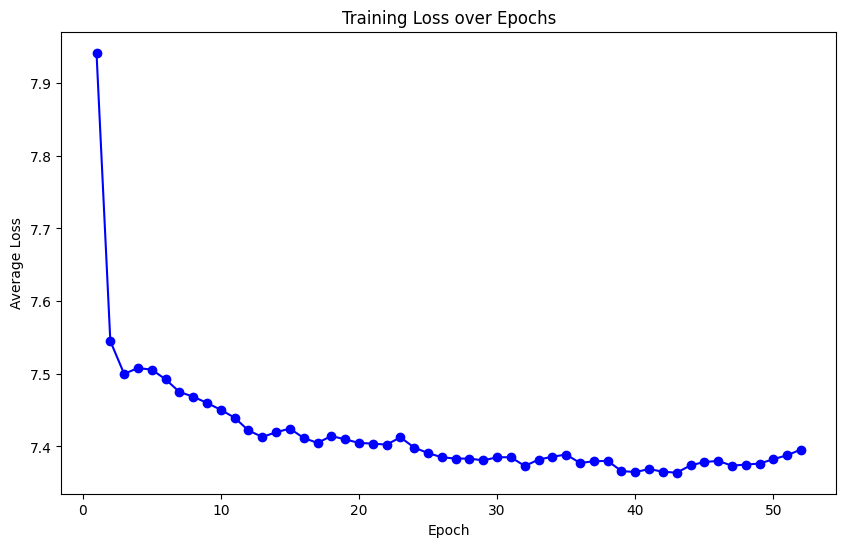

In [155]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_records) + 1), loss_records, marker='o', linestyle='-', color='b')

# 添加标题和标签
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')

- **测试流程**

In [165]:
test_path = r"DLdata/cnews_test_sampled.txt"

In [166]:
test_data = read_file(test_path)

In [167]:
# 计算总字符数和样本数
cal = calculate_stats(test_data)

In [168]:
cal.stats()

总字数: 4848962
样本数量: 5000
平均每篇文章的字数: 969.7924
最长句子的字数:14720
最短句子的字数:13
句子长度的25%分位数:428.75
句子长度的50%分位数:734.0
句子长度的75%分位数:1177.25
句子长度的90%分位数:1951.1000000000004


In [169]:
#测试数据，无需进行段落重组等等操作，只需要进行分词和编码即可

In [170]:
#分词
test_split = [jieba.lcut(sentence) for sentence in test_data]

In [171]:
#添加起始符号与终止符号
processed_test_data = []

for content in test_split:
    content = ["<sos>"] + content + ["<eos>"]
    processed_test_data.append(content)

In [172]:
#无需重组，直接使用训练集做好的词汇表进行编码
ordinal_test_token = []
for tokens in processed_test_data:
    ordinal_test_token.append(vocab.convert_tokens_to_ids(tokens))

In [173]:
ordinal_test_token.__len__()

5000

In [174]:
print(ordinal_test_token[0][:200])

[1, 163, 2115, 0, 867, 0, 1272, 8679, 0, 417, 928, 2360, 0, 2413, 13647, 96, 417, 8, 9, 927, 928, 0, 20, 0, 781, 159, 0, 875, 780, 0, 3823, 2405, 0, 0, 225, 23, 4059, 359, 0, 0, 1135, 25233, 25234, 0, 0, 0, 23, 839, 357, 0, 163, 2338, 2115, 0, 187, 0, 3612, 867, 3257, 121, 0, 379, 111, 0, 4513, 1306, 225, 16352, 0, 0, 50, 0, 0, 887, 1912, 14477, 7008, 0, 1380, 0, 0, 2413, 9040, 0, 0, 0, 1892, 0, 0, 824, 1250, 617, 22438, 0, 0, 0, 0, 0, 27586, 0, 1446, 0, 2413, 0, 0, 0, 0, 567, 249, 0, 7573, 0, 381, 0, 0, 1450, 567, 249, 340, 16511, 0, 0, 1466, 0, 95, 205, 0, 0, 0, 0, 0, 0, 567, 249, 1566, 0, 0, 2116, 1176, 0, 2115, 0, 0, 69937, 0, 0, 166, 0, 0, 1380, 0, 148, 14344, 0, 0, 0, 0, 0, 0, 337, 22280, 0, 2945, 0, 1013, 6380, 1047, 0, 246, 17667, 0, 0, 0, 480, 6070, 340, 0, 2413, 73051, 0, 0, 0, 166, 148, 0, 14340, 0, 443, 323, 0, 1013, 51, 0, 1650, 9127, 2413, 0, 0, 5503, 0]


In [193]:
import torch

def top_k_sampling(logits, top_k=10):
    """
    从 logits 中进行 top-k 采样，返回采样到的标记索引。
    """
    # 获取 logits 的最后一个时间步的输出
    logits = logits[:, -1, :]  # 取最后一个时间步的 logits
    
    # 进行 top-k 筛选
    top_k_logits, top_k_indices = torch.topk(logits, top_k, dim=-1)
    
    # 对 top-k 的 logits 进行 softmax，然后从中采样
    probabilities = torch.nn.functional.softmax(top_k_logits, dim=-1)
    next_token = torch.multinomial(probabilities, 1)  # 从概率分布中采样
    
    # 获取原始 logits 对应的索引
    next_token = top_k_indices.gather(-1, next_token)
    
    return next_token.item()  # 返回标记索引

In [232]:
def generate_sequence(model, initial_input, eos_token_id = 2, max_length=100, device='cuda'):
    model.eval()  # 设置模型为评估模式
    
    # 将初始输入移到 GPU 上，并添加 batch 维度
    input_seq = torch.tensor(initial_input).unsqueeze(0).to(device)  
    
    generated_seq = initial_input  # 初始化生成的序列
    
    with torch.no_grad():
        for _ in range(max_length):
            # 预测下一个token
            # 首先，model和训练时的模式一样，还是会针对每一个token都输出下一个token
            # 我们的每一个token依然会因为注意力机制的缘故、由单一样本转变为“段落”
            # 只有最后一行、也就是最后一个“段落”所输出的内容对我们才有意义
            # 因为最后一行代表了整个句子的信息，依据整个句子预测出后一个字
            log_probs = model(input_seq)

            # 使用 top-k 采样策略从 log_probs 中采样下一个标记
            next_token = top_k_sampling(log_probs, top_k=300)
            
            # 将生成的标记添加到序列中
            generated_seq.append(next_token)
            
            # 更新输入序列，并将其移到 GPU 上
            input_seq = torch.tensor(generated_seq).unsqueeze(0).to(device)
            
            # 如果生成了 <eos> 标记，则停止
            if next_token == eos_token_id:  # eos_token_id 是 <eos> 的标记
                break
    
    return generated_seq

In [233]:
def one_sentence_tokens_to_ids(sentence,vocab_table):
    """
    该函数只接纳一个句子作为输入，不接纳双层的列表（如一个列表中包含多个句子，每个句子单独做为一个列表）
    """
    #检查是否为嵌套的列表
    if isinstance(sentence, list) and all(isinstance(i, list) for i in sentence):
        raise ValueError("该结构为嵌套列表、包含多个句子，当前函数只能接受单一句子")

    #分词
    test_split = jieba.lcut(sentence)
    #添加起始符号与终止符号
    content = ["<sos>"] + test_split + ["<eos>"]
    #直接使用训练集做好的词汇表进行编码
    return vocab_table.convert_tokens_to_ids(content)

In [234]:
def one_sentence_ids_to_tokens(content,vocab_table):
    content = vocab_table.convert_ids_to_tokens(content)
    remove_tokens = {'<sos>', '<eos>', '<unk>'}
    result = ''.join([token for token in content if token not in remove_tokens])
    return print(result)

In [235]:
def one_sentence_test(sentence,vocab_table=vocab,model=model):
    content = one_sentence_tokens_to_ids(sentence,vocab_table)
    print(content)
    generate_seq = generate_sequence(model,content)
    print(generate_seq)
    return one_sentence_ids_to_tokens(generate_seq,vocab_table)

In [236]:
initial_input = ordinal_test_token[0][:50]

In [237]:
"".join(vocab.convert_ids_to_tokens(initial_input))

'<sos>三次冲突<unk>5<unk>遭驱逐<unk> 湖人悍将<unk>特里推倒教练 新浪体育讯洛杉矶湖人<unk>主场<unk>28分<unk>优势击败<unk>达拉斯小牛<unk><unk>一场比赛胜负更<unk><unk>感到血脉喷张<unk><unk><unk>比赛第四节发生<unk>'

In [238]:
generate_seq = generate_sequence(model,initial_input)

In [239]:
print(generate_seq)

[1, 163, 2115, 0, 867, 0, 1272, 8679, 0, 417, 928, 2360, 0, 2413, 13647, 96, 417, 8, 9, 927, 928, 0, 20, 0, 781, 159, 0, 875, 780, 0, 3823, 2405, 0, 0, 225, 23, 4059, 359, 0, 0, 1135, 25233, 25234, 0, 0, 0, 23, 839, 357, 0, 1631, 0, 878, 991, 17798, 19224, 226, 0, 0, 0, 0, 0, 0, 0, 663, 0, 258, 0, 37, 0, 0, 0, 0, 1, 38860, 0, 0, 34778, 0, 0, 2335, 0, 43930, 173, 0, 9097, 0, 6262, 0, 695, 0, 0, 0, 0, 0, 2]


In [240]:
one_sentence_ids_to_tokens(generate_seq,vocab)

三次冲突5遭驱逐 湖人悍将特里推倒教练 新浪体育讯洛杉矶湖人主场28分优势击败达拉斯小牛一场比赛胜负更感到血脉喷张比赛第四节发生经济影响24旗下消费好交易带来中今年以来业绩明年信托世界下跌预计年


In [241]:
one_sentence_test("三次冲突!5体育遭驱逐! 湖人悍将特里推倒教练")

[1, 163, 2115, 0, 867, 16, 1272, 8679, 0, 417, 928, 2360, 2413, 13647, 96, 2]
[1, 163, 2115, 0, 867, 16, 1272, 8679, 0, 417, 928, 2360, 2413, 13647, 96, 2, 0, 1035, 86, 0, 0, 47894, 1631, 47897, 0, 2300, 0, 38320, 0, 0, 0, 673, 37, 40368, 0, 0, 0, 17452, 0, 4530, 0, 2]
三次冲突5体育遭驱逐 湖人悍将特里推倒教练去年经历银行卡经济信用卡发展增长率到期中央行股票减少


In [242]:
one_sentence_test("你好模型！")

[1, 14041, 14060, 0, 2]
[1, 14041, 14060, 0, 2, 0, 0, 0, 0, 997, 1, 653, 16715, 0, 1, 0, 9620, 0, 2]
你好模型经理依然基金单位


- **更多改进策略**

目前来看，模型存在“胡说八道”现象，出现这种现象的原因可能涉及多个因素，包括训练不足、数据集质量、模型架构或生成策略等。让我们逐步分析这些可能性，并讨论如何应对。

1. **训练不足**
   - **Epoch 数量不足**：如果模型尚未充分训练，它可能还没有完全掌握如何生成自然的、非重复的文本。增加训练的 epoch 数量可能有助于模型更好地学习数据中的语言模式和结构。
   - **数据量不足**：如果训练数据集太小，模型可能会过度拟合训练数据，导致在生成时出现重复的现象。增加数据量可以为模型提供更多样化的输入，帮助它更好地泛化。

   **改进建议**：
   - 尝试增加 epoch 数量，并观察模型的验证损失和生成质量是否有改善。
   - 如果可能，收集更多的数据或使用数据增强技术来扩充训练集。

2. **数据集的质量**
   - **重复的数据**：如果训练数据集中存在大量重复的句子或标记，模型可能会倾向于生成重复内容。
   - **标点符号的过度使用**：如果训练数据中过于频繁地使用某个标点符号（如逗号），模型可能会学习到这种模式，并在生成时过度使用该符号。

   **改进建议**：
   - 清理数据集，去除重复的内容，或者平衡数据集中的不同类型内容，确保模型能够学习到多样化的语言模式。
   - 检查训练数据中标点符号的分布，确保它们不会过度出现，从而避免模型过度学习这些标记。

4. **模型的架构和参数调整**
   - **模型容量不足**：如果模型的参数量不足，它可能无法有效捕捉复杂的语言模式，从而在生成时重复内容。
   - **学习率设置**：学习率过高或过低都会影响模型的学习效果。适当调整学习率，确保模型能有效学习而不过拟合。

   **改进建议**：
   - 考虑增加模型的容量（如增加层数或注意力头的数量），以增强模型的表达能力。
   - 调整学习率，观察对模型学习效果的影响。

5. **过拟合问题**
   - **过拟合**：如果模型过度拟合训练数据，它可能会在生成时表现为重复或僵化的输出。引入正则化技术，如 dropout 或 L2 正则化，可以缓解过拟合问题。

   **改进建议**：
   - 引入或增加 dropout 层的比例，避免模型过度依赖训练数据。
   - 通过增加数据量或使用更强的正则化，来改善模型的泛化能力。

### 3.3.4 【选学】生成式模型的改进

**在视频讲解时，没有对改进后的模型进行训练。在课件中，对这部分模型进行了补充训练。**

首先，我对模型做出了以下的改进——

1. 增加数据量并改变数据组成，将原本每个领域抽样500（总样本量5000）、修改为从各个领域抽样2000（总样本量2w）
2. 增加模型复杂度，将原本0.02B参数的模型增加到1.3B（使用Transformer原始论文中的Decoder-Only结构）
3. 不再按照每篇新闻、而是按照句子进行分割，为每个句子的前面添加<sos>，句子后方添加<eos>
4. 筛选过短的句子，将20字以下的句子全部筛出
5. 没有再使用标点符号筛选和停用词，相对的，对token进行了词频统计、并对词频过高的词加以权重惩罚

> 数据导入

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import jieba
import os
import re
from collections import defaultdict, Counter

In [2]:
def read_file(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split('\t')
            if len(parts) == 2:
                label, content = parts
                data.append(content) #只要content，不要label
    return data

import numpy as np
class calculate_stats:
    def __init__(self,data):
        self.total_samples = len(data)
        self.len_ = []
        for content in data:
            self.len_.append(len(content))

        self.lower_quartile = np.percentile(self.len_, 25)
        self.median = np.median(self.len_)
        self.upper_quartile = np.percentile(self.len_, 75)
        self.percentile_90 = np.percentile(self.len_, 90)

    def stats(self):
        # 输出结果
        print(f"总字数: {sum(self.len_)}")
        print(f"样本数量: {self.total_samples}")
        print(f"平均每篇文章的字数: {sum(self.len_)/self.total_samples}")
        print(f"最长句子的字数:{max(self.len_)}")
        print(f"最短句子的字数:{min(self.len_)}")
        print(f"句子长度的25%分位数:{self.lower_quartile}")
        print(f"句子长度的50%分位数:{self.median}")
        print(f"句子长度的75%分位数:{self.upper_quartile}")
        print(f"句子长度的90%分位数:{self.percentile_90}")

In [3]:
PATH = r'DLdata/'

In [4]:
train_data = pd.read_csv(os.path.join(PATH,"cnews.train.txt")
                         , sep="\t", names = ["label","content"])

In [5]:
# 随机抽样 - 训练集
np.random.seed(1412)
sampled_df = train_data.groupby('label').apply(lambda x: x.sample(n=2000)).reset_index(drop=True)

# 保存为txt文件
output_file_path = os.path.join(PATH,"cnews_train_sampled_2000.txt")
with open(output_file_path, 'w', encoding='utf-8') as f:
    for index, row in sampled_df.iterrows():
        f.write(f"{row['label']}\t{row['content']}\n")

print(f"Sampled data saved to {output_file_path}")

/tmp/ipykernel_1243/2812097312.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = train_data.groupby('label').apply(lambda x: x.sample(n=2000)).reset_index(drop=True)


Sampled data saved to DLdata/cnews_train_sampled_2000.txt


In [6]:
# 读取数据
file_path = r"DLdata/cnews_train_sampled_2000.txt"

# 读取数据
data = read_file(file_path)

In [7]:
# 查看前2个样本
print(f"First 2 samples: {data[:2]}")

First 2 samples: ['新浪正在视频直播尼克斯vs魔术 魔兽小斯强强对话新浪体育讯12月31日8:00，新浪体育将为您视频直播魔术主场迎战尼克斯的比赛。摆脱了赛季初的低迷之后，尼克斯打出14胜1负战绩，最近他们在圣诞大战中又战胜了公牛，不过随后一战却再次被热火打败。如今尼克斯两胜公牛，两败于凯尔特人和热火，东部四强中只有魔术还没交手，两队在11月3日曾被安排一战，但是因故未能进行，急欲给自己加盖强队标签的尼克斯会在这场迟来的比赛中全力以赴。而最近4连胜的魔术也想在这场比赛中一试牛刀，连胜凯尔特人马刺的他们，何惧尼克斯？(新体)[视频直播室] [视频直播室-教育网专用] [图文直播室]', '弗老大同意终止合同 高层确认为球队利益让他离去新浪体育讯北京时间12月27日，来自新华网英文版消息，在经历了两周的效力之后，弗朗西斯决定离开北京队，俱乐部高层对此也做了确认。北京队助理教练袁超对新华社说，“弗朗西斯下午来到首钢体育馆，告诉球队，他已经决定离开了。”33岁的弗朗西斯在上一轮对阵江苏队的比赛中，没有能出场，他在中场休息时间无故离开了更衣室。在赛后的新闻发布会上，闵鹿蕾确认了弗朗西斯中场离开的消息，并且说“这是我第一次看到有球员在比赛期间离开的。”闵鹿蕾的一番话，更加加剧了弗朗西斯离开北京队的可能性，而且他在25号缺席了球队的训练，原因是要和家里人度过圣诞节，他在接受采访时候表示：“我没有无故不训练，我给教练打过招呼了，他也答应了。”袁超在接受新华社采访时候，终于说出了今天谈判的进展，“我今天早上和弗朗西斯谈了谈关于他中场离开和圣诞节不训练的事儿，我告诉他，为了球队的利益，我们想让他离开。当时他在会谈中没有给我一个明确的答复。”“但是，当他下午出现在首钢训练馆中的时候，他说他已经准备好要离开了。”袁超说。无论北京俱乐部还是弗朗西斯，都希望双方有个圆满的结局。过去的两周，弗朗西斯一共为北京打了4场比赛，场均3分钟内得到0.5分，0.7个篮板，这和昔日的三次NBA全明星队员相比，确实相差甚远。俱乐部做出这样的决定，或许对双方都有好处。(FRANK)']


In [8]:
data.__len__()

20000

In [9]:
# 计算总字符数和样本数
cal = calculate_stats(data)

In [10]:
cal.stats()

总字数: 18272972
样本数量: 20000
平均每篇文章的字数: 913.6486
最长句子的字数:27467
最短句子的字数:14
句子长度的25%分位数:345.0
句子长度的50%分位数:682.0
句子长度的75%分位数:1150.25
句子长度的90%分位数:1894.0


> 句子分割

In [11]:
import jieba
import jieba.posseg as pseg

def sentence_split(text):
    sentence_separators = ['。', '！', '？', '；', '…', '：','”',' ',]
    sentences = []
    start = 0
    for i, char in enumerate(text):
        if char in sentence_separators:
            sentences.append(text[start:i + 1])
            start = i + 1
    if start < len(text):
        sentences.append(text[start:])
    return sentences

In [12]:
sentence_split(data[0])

['新浪正在视频直播尼克斯vs魔术 ',
 '魔兽小斯强强对话新浪体育讯12月31日8:00，新浪体育将为您视频直播魔术主场迎战尼克斯的比赛。',
 '摆脱了赛季初的低迷之后，尼克斯打出14胜1负战绩，最近他们在圣诞大战中又战胜了公牛，不过随后一战却再次被热火打败。',
 '如今尼克斯两胜公牛，两败于凯尔特人和热火，东部四强中只有魔术还没交手，两队在11月3日曾被安排一战，但是因故未能进行，急欲给自己加盖强队标签的尼克斯会在这场迟来的比赛中全力以赴。',
 '而最近4连胜的魔术也想在这场比赛中一试牛刀，连胜凯尔特人马刺的他们，何惧尼克斯？',
 '(新体)[视频直播室] ',
 '[视频直播室-教育网专用] ',
 '[图文直播室]']

In [13]:
#句子降维
sentence_splited = [sentence_split(sentences) for sentences in data]

In [14]:
for item in sentence_splited:
    print(item)
    break

['新浪正在视频直播尼克斯vs魔术 ', '魔兽小斯强强对话新浪体育讯12月31日8:00，新浪体育将为您视频直播魔术主场迎战尼克斯的比赛。', '摆脱了赛季初的低迷之后，尼克斯打出14胜1负战绩，最近他们在圣诞大战中又战胜了公牛，不过随后一战却再次被热火打败。', '如今尼克斯两胜公牛，两败于凯尔特人和热火，东部四强中只有魔术还没交手，两队在11月3日曾被安排一战，但是因故未能进行，急欲给自己加盖强队标签的尼克斯会在这场迟来的比赛中全力以赴。', '而最近4连胜的魔术也想在这场比赛中一试牛刀，连胜凯尔特人马刺的他们，何惧尼克斯？', '(新体)[视频直播室] ', '[视频直播室-教育网专用] ', '[图文直播室]']


In [15]:
merged_list = [item for sublist in sentence_splited for item in sublist]

In [16]:
merged_list[:10]

['新浪正在视频直播尼克斯vs魔术 ',
 '魔兽小斯强强对话新浪体育讯12月31日8:00，新浪体育将为您视频直播魔术主场迎战尼克斯的比赛。',
 '摆脱了赛季初的低迷之后，尼克斯打出14胜1负战绩，最近他们在圣诞大战中又战胜了公牛，不过随后一战却再次被热火打败。',
 '如今尼克斯两胜公牛，两败于凯尔特人和热火，东部四强中只有魔术还没交手，两队在11月3日曾被安排一战，但是因故未能进行，急欲给自己加盖强队标签的尼克斯会在这场迟来的比赛中全力以赴。',
 '而最近4连胜的魔术也想在这场比赛中一试牛刀，连胜凯尔特人马刺的他们，何惧尼克斯？',
 '(新体)[视频直播室] ',
 '[视频直播室-教育网专用] ',
 '[图文直播室]',
 '弗老大同意终止合同 ',
 '高层确认为球队利益让他离去新浪体育讯北京时间12月27日，来自新华网英文版消息，在经历了两周的效力之后，弗朗西斯决定离开北京队，俱乐部高层对此也做了确认。']

In [17]:
merged_list.__len__()

617810

> 句子长度筛选

In [18]:
def filter_sentences_by_length(sentences, min_len, max_len):
    """
    筛选出字数超过指定最小长度的所有句子。

    参数：
    sentences (list of str): 输入的句子列表。
    min_length (int): 最小字数长度。

    返回：
    List[str]: 筛选后的句子列表。
    """
    filtered_sentences = [sentence for sentence in sentences if len(sentence) > min_len and len(sentence) < max_len]
    return filtered_sentences

In [19]:
#筛选掉过短的句子
filtered_data = filter_sentences_by_length(merged_list,50,1000)

In [20]:
filtered_data.__len__()

110887

In [21]:
filtered_data[:10]

['摆脱了赛季初的低迷之后，尼克斯打出14胜1负战绩，最近他们在圣诞大战中又战胜了公牛，不过随后一战却再次被热火打败。',
 '如今尼克斯两胜公牛，两败于凯尔特人和热火，东部四强中只有魔术还没交手，两队在11月3日曾被安排一战，但是因故未能进行，急欲给自己加盖强队标签的尼克斯会在这场迟来的比赛中全力以赴。',
 '高层确认为球队利益让他离去新浪体育讯北京时间12月27日，来自新华网英文版消息，在经历了两周的效力之后，弗朗西斯决定离开北京队，俱乐部高层对此也做了确认。',
 '在赛后的新闻发布会上，闵鹿蕾确认了弗朗西斯中场离开的消息，并且说“这是我第一次看到有球员在比赛期间离开的。',
 '闵鹿蕾的一番话，更加加剧了弗朗西斯离开北京队的可能性，而且他在25号缺席了球队的训练，原因是要和家里人度过圣诞节，他在接受采访时候表示：',
 '袁超在接受新华社采访时候，终于说出了今天谈判的进展，“我今天早上和弗朗西斯谈了谈关于他中场离开和圣诞节不训练的事儿，我告诉他，为了球队的利益，我们想让他离开。',
 '过去的两周，弗朗西斯一共为北京打了4场比赛，场均3分钟内得到0.5分，0.7个篮板，这和昔日的三次NBA全明星队员相比，确实相差甚远。',
 '他让整个世界都不同了新浪体育讯北京时间1月16日(美国当地时间1月15日)消息，休斯敦火箭客场挑战亚特兰大老鹰，火箭克服了种种不利因素，最终以112-106战胜了对手。',
 '和昨天的怒批裁判不同，今天阿帅开起了记者的玩笑，对《休斯敦纪实报》记者费根说，“你跟队报道比赛，你告诉我(赢球的)原因吧。',
 '对于今天的比赛，阿德尔曼总结道，“我们过去两年，我告诉他们，应该坚持下去，我们有连续赢得比赛的潜力，我们需要像今晚一样终结比赛，今天大家都很努力，阿隆今天打出了一场很好的比赛，手感很好，在昨晚经历了那样一场比赛后，我为他们今晚的表现骄傲。']

> 分词、起始符号、终止符号、分chunk

In [22]:
#进行分词，添加起始符号与终止符号
data_split = [jieba.lcut(sentence) for sentence in filtered_data]

#为现有的句子添加起始符号与终止符号
processed_data = []

for content in data_split:
    content = ["<sos>"] + content + ["<eos>"]
    processed_data.append(content)

def merge_and_chunk(data, chunk_size):
    """
    将所有嵌套列表合并为一个长列表，然后按指定大小分块。
    
    参数：
    data (list of list of str): 输入的嵌套字符串列表。
    chunk_size (int): 每个块的最大大小。
    
    返回：
    list of list of str: 分块后的字符串列表。
    """
    # 合并所有列表为一个长列表
    merged_list = []
    for sublist in data:
        merged_list.extend(sublist)
    
    # 通过索引的方式，按指定大小分块
    chunks = [merged_list[i:i + chunk_size] for i in range(0, len(merged_list), chunk_size)]
    return chunks

chunks = merge_and_chunk(processed_data,512)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.674 seconds.
Prefix dict has been built successfully.


In [23]:
print(chunks[0][:50])

['<sos>', '摆脱', '了', '赛季', '初', '的', '低迷', '之后', '，', '尼克斯', '打出', '14', '胜', '1', '负', '战绩', '，', '最近', '他们', '在', '圣诞', '大战', '中', '又', '战胜', '了', '公牛', '，', '不过', '随后', '一战', '却', '再次', '被', '热火', '打败', '。', '<eos>', '<sos>', '如今', '尼克斯', '两胜', '公牛', '，', '两败', '于', '凯尔特人', '和', '热火', '，']


> 建词汇表、编码

In [24]:
#词频统计
from collections import Counter

flattened_data = [word for sublist in chunks for word in sublist]

# 统计词频
word_counts = Counter(flattened_data)

In [25]:
# 打印词频最高的前100个词
for word, freq in word_counts.most_common(30):
    print(f"{word}: {freq}")

，: 386450
的: 266212
<sos>: 110887
<eos>: 110887
。: 92382
、: 61295
在: 57557
了: 44477
是: 41607
和: 33638
也: 22747
有: 21299
》: 19648
《: 19477
中: 15748
都: 15303
“: 14289
月: 14075
): 13909
他: 13758
将: 13711
年: 13515
为: 13499
我们: 13434
(: 13358
对: 13252
我: 12986
一个: 12655
就: 12538
上: 12490


In [26]:
# 将高频词保存为列表，将这些词的频率也保存为列表
high_freq_word = []
high_freq = []
for word, freq in word_counts.most_common(100):
    high_freq_word.append(word)
    high_freq.append(freq)

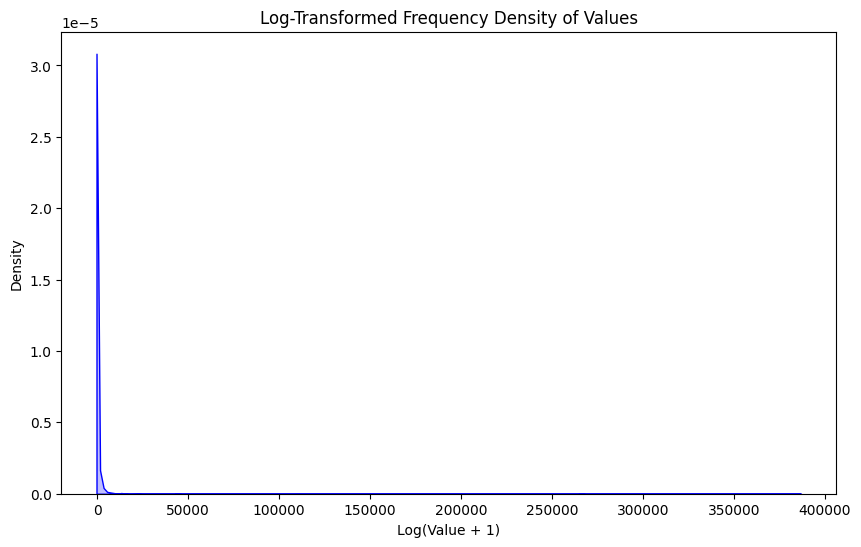

In [30]:
# 将所有的词频保存成列表，绘制频率分布图
all_freq = list(word_counts.values())
all_freq.sort()

import matplotlib.pyplot as plt
import seaborn as sns

# 绘制直方图
# 绘制概率密度图
plt.figure(figsize=(10, 6))
sns.kdeplot(all_freq, color='blue', fill=True)
plt.title('Log-Transformed Frequency Density of Values')
plt.xlabel('Log(Value + 1)')
plt.ylabel('Density')
plt.grid(False)
plt.show()

In [31]:
from collections import defaultdict, Counter

class Vocab:
    """
    可以同时接纳Token和text两种类型的数据
    对原始文字数据，调用build方法，进行分词、完成预处理、完成词频筛选
    对Token数据，使用init中的流程，完成添加未知词、词汇表构建并根据词汇表进行编码
    建好词汇表后，再调用单独的方法来进行编码
    """
    def __init__(self, tokens=None):
        self.idx_to_token = list()
        self.token_to_idx = dict()

        if tokens is not None:
            if "<unk>" not in tokens:
                tokens = ["<unk>"] + tokens 
            if "<sos>" not in tokens:
                tokens = ["<sos>"] + tokens
            if "<eos>" not in tokens:
                tokens = ["<eos>"] + tokens
            for token in tokens:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1
            self.unk = self.token_to_idx['<unk>']

    @classmethod

    def build(cls, text
              , min_freq = 1
              , stopwords = set(["的", "和", "了", "在", "是", "就", "不", "也", "有", "但"])
              , preprocessing=False
              , reserved_tokens=None):
        token_freqs = defaultdict(int)
        for tokens in text:
            if preprocessing:
                #去除标点符号
                tokens = [re.sub(r'[^\w\s]', '', token) for token in tokens]
                #去除停用词
                tokens = [token for token in tokens if token and token not in stopwords]
            #词频筛选
            for token in tokens:
                token_freqs[token] += 1
        uniq_tokens = ["<unk>", "<sos>", "<eos>"] + (reserved_tokens if reserved_tokens else [])
        uniq_tokens += [token for token, freq in token_freqs.items() if freq >= min_freq and token != "<unk>"]
        return cls(uniq_tokens)

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, token):
        return self.token_to_idx.get(token, self.unk)

    def convert_tokens_to_ids(self, tokens):
        return [self[token] for token in tokens]

    def convert_ids_to_tokens(self, indices):
        return [self.idx_to_token[index] for index in indices]

In [32]:
vocab = Vocab.build(chunks,min_freq=1
                   ,preprocessing = False
                   )

In [33]:
ordinal_token = []
for tokens in chunks:
    ordinal_token.append(vocab.convert_tokens_to_ids(tokens))

In [34]:
cal = calculate_stats(ordinal_token)
cal.stats()

总字数: 4896774
样本数量: 9565
平均每篇文章的字数: 511.94709879769994
最长句子的字数:512
最短句子的字数:6
句子长度的25%分位数:512.0
句子长度的50%分位数:512.0
句子长度的75%分位数:512.0
句子长度的90%分位数:512.0


> 架构定义

In [35]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

In [36]:
class TransformerDataset(Dataset):
    def __init__(self, data):
        # 初始化数据集，将传入的数据保存在实例变量data中
        self.data = data

    def __len__(self):
        # 返回数据集的大小
        return len(self.data)

    def __getitem__(self, i):
        # 根据索引i获取数据集中的第i个样本
        return self.data[i]

# 定义collate_fn函数，用于在DataLoader中对一个batch的数据进行处理
def collate_fn(examples):
    # 将每个样本的输入部分转换为张量
    seq = [torch.tensor(ex) for ex in examples]
    y_true = [torch.tensor(ex[1:] + [0]) for ex in examples]
    
    # pytorch自带的padding工具
    # 对batch内的样本进行padding，使其具有相同长度
    seq = pad_sequence(seq, batch_first=True)
    y_true = pad_sequence(y_true, batch_first=True)
    
    # 返回处理后的输入和目标
    return seq, y_true

batch_size = 32

dataset = TransformerDataset(ordinal_token)  # 创建数据集
dataloader = DataLoader(dataset
                        , batch_size=batch_size
                        , drop_last = False
                        , collate_fn=collate_fn
                        , shuffle= True)  # 允许dataloder中的batch随机排列

In [37]:
dataloader.__len__()

299

In [38]:
import math

#位置编码（同样关系到是否batch_first = True）
# 定义PositionalEncoding类，用于为输入添加位置信息
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=1000, batch_first=True):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        #有transpose，代表默认输入数据形状为(seq_len, batch_size, d_model)
        #如果输入结构为(batch_size, seq_len, d_model)，则不需要transpose
        if batch_first:
            pe = pe.unsqueeze(0)
        else:
            pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        
        self.batch_first = batch_first

    def forward(self, x):
        #如果batch_first，则需要截断的是中间的维度
        #且用于中间维度截断的维度是seq_len
        if self.batch_first:
            x = x + self.pe[:, :x.size(1), :]
        else:
            #如果没有batch_first，需要截断的是第一个维度
            x = x + self.pe[:x.size(0), :]
        return x

#两大掩码函数
def create_padding_mask(seq, pad_token=0):
    # seq: (batch_size, seq_len)
    # 创建一个与输入序列形状相同的掩码
    padding_mask = (seq == pad_token).float() * -1e9  # (batch_size, seq_len)
    return padding_mask

def create_look_ahead_mask(seq_len, start_seq=1):
    mask = torch.triu(torch.ones((seq_len, seq_len)), diagonal=start_seq)  # 上三角矩阵
    mask = mask.float() * -1e9  # 将未来的位置设置为负无穷大
    return mask  # (seq_len, seq_len)

class DecoderOnlyTransformer(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim,
                 dim_feedforward=256, num_head=2, num_layers=2,
                 dropout=0.1, max_len=1000, activation: str = "relu", batch_first=True):
        super(DecoderOnlyTransformer, self).__init__()  # 调用父类nn.Module的构造函数
        
        self.embedding_dim = embedding_dim  # 保存嵌入维度

        # 输入，与encoder一致
        # 定义嵌入层，将词汇ID映射到embedding表示
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        # 定义位置编码层，添加位置信息，注意batch_first
        self.position_embedding = PositionalEncoding(
            hidden_dim, dropout
            , max_len, batch_first=batch_first)  
        
        # 定义一个Transformer解码器层
        # 包括带掩码的多头注意力机制、残差链接、Layer Norm以及前馈神经网络
        decoder_layer = nn.TransformerDecoderLayer(
            embedding_dim, num_head
            , dim_feedforward, dropout
            , activation
            , batch_first=batch_first
        )
        # 定义多层解码器
        self.transformer = nn.TransformerDecoder(decoder_layer
                                                 , num_layers)
        
        # 输出层 - 现在是针对每个样本都进行输出
        # 将解码器输出映射到词汇表大小
        # 此时注意力机制的输出结构为(batch_size, seq_len, input_dim)
        # 通常来说我们需要将 seq_len * input_dim
        # 不过现在nn.Linear已经可以接纳三维输出
        self.output = nn.Linear(embedding_dim, vocab_size)  

    def forward(self, seq, tgt_mask=None, tgt_key_padding_mask=None):
        # 填充掩码
        tgt_key_padding_mask = create_padding_mask(seq)
        
        # 将输入的词汇ID转换为embedding表示
        # 添加位置信息        
        seq = self.embeddings(seq)
        seq = self.position_embedding(seq)

        #empty_memory = torch.zeros(seq.size(0), seq.size(1), self.embedding_dim, device=seq.device)
        
        # 通过Transformer解码器层处理输入
        # memory = seq则是普通的掩码注意力机制
        # memory = memory则是编码-解码器注意力层
        # 对Decoder-only结构来说，只需要一个打包的掩码注意力层即可
        output = self.transformer(tgt = seq
                                  , memory = seq
                                  , tgt_mask=tgt_mask
                                  , tgt_key_padding_mask=tgt_key_padding_mask)

        # 生成式算法，如果linear准备接受三维输入，则无需进行降维索引
        # 通过输出层得到分类结果
        output = self.output(output)  # 将解码器输出映射到词汇表大小

        #log_softmax函数
        log_probs = F.log_softmax(output, dim=-1)  # 计算log softmax以获取概率分布
        
        return log_probs  # 返回log概率分布

> 模型训练

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [40]:
#超参数
vocab_size = len(vocab)
embedding_dim = 512  # input_dimension为512
hidden_dim = 512  # 注意力机制的维度为512，同embedding_dim
seq_len = 512
num_epochs = 30
num_heads = 8
num_layers = 6
lr = 0.05
tgt_mask = create_look_ahead_mask(seq_len)

In [41]:
#数据
for batch in dataloader:
    print(batch) # 第一个batch中的实际数据，结构为(batch_size, seq_len)
    print(batch[0])
    print(batch[0].shape)
    print(batch[1])
    print(batch[1].shape)
    break

(tensor([[48336,    36,    37,  ...,    11,  2612,  3824],
        [11057, 29447,    11,  ...,   129,   216,   210],
        [   11,   866, 67344,  ...,    11,  6188, 68296],
        ...,
        [13434,    11,   359,  ...,  5155,    11,  1497],
        [   11,   958,  6115,  ...,   100,   232,   363],
        [ 4257,   302,  6795,  ...,    11,   116,  4302]]), tensor([[   36,    37,     3,  ...,  2612,  3824,     0],
        [29447,    11, 11057,  ...,   216,   210,     0],
        [  866, 67344,    11,  ...,  6188, 68296,     0],
        ...,
        [   11,   359,   871,  ...,    11,  1497,     0],
        [  958,  6115,     5,  ...,   232,   363,     0],
        [  302,  6795,  3718,  ...,   116,  4302,     0]]))
tensor([[48336,    36,    37,  ...,    11,  2612,  3824],
        [11057, 29447,    11,  ...,   129,   216,   210],
        [   11,   866, 67344,  ...,    11,  6188, 68296],
        ...,
        [13434,    11,   359,  ...,  5155,    11,  1497],
        [   11,   958,  6115

In [42]:
#模型
model = DecoderOnlyTransformer(vocab_size, embedding_dim, hidden_dim,
                               max_len = seq_len
                               , num_head = num_heads
                               , num_layers = num_layers
                               , batch_first=True)

In [43]:
#设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [44]:
import time
import GPUtil

def print_gpu_status():
    # 获取所有 GPU 的状态
    gpus = GPUtil.getGPUs()
    for gpu in gpus:
        #print(f"GPU ID: {gpu.id}")
        #print(f"GPU Name: {gpu.name}")
        print(f"GPU使用率: {gpu.load * 100:.2f}%")
        print(f"显存使用量: {gpu.memoryUsed}MB")
        #print(f"显存总量: {gpu.memoryTotal}MB")
        print(f"显存占用率: {gpu.memoryUtil * 100:.2f}%")
        #print(f"温度: {gpu.temperature}°C")
        print("-" * 30)

In [45]:
print_gpu_status()

GPU使用率: 8.00%
显存使用量: 928.0MB
显存占用率: 1.89%
------------------------------


In [46]:
# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=lr)

In [47]:
# 定义损失函数
# 为高频词设置较低的权重

vocab_size = len(vocab)

weights = torch.ones(vocab_size)

In [48]:
# 根据高频词找到相应的索引
high_freq_indices = vocab.convert_tokens_to_ids(high_freq_word)

In [57]:
1/np.array(high_freq)

array([2.58765688e-06, 3.75640467e-06, 9.01818969e-06, 9.01818969e-06,
       1.08246195e-05, 1.63145444e-05, 1.73740813e-05, 2.24835308e-05,
       2.40344173e-05, 2.97282835e-05, 4.39618411e-05, 4.69505611e-05,
       5.08957655e-05, 5.13426092e-05, 6.35001270e-05, 6.53466641e-05,
       6.99839037e-05, 7.10479574e-05, 7.18958947e-05, 7.26849833e-05,
       7.29341405e-05, 7.39918609e-05, 7.40795614e-05, 7.44379932e-05,
       7.48615062e-05, 7.54603079e-05, 7.70060065e-05, 7.90201501e-05,
       7.97575371e-05, 8.00640512e-05, 8.13206473e-05, 8.51861317e-05,
       9.28246542e-05, 9.29454410e-05, 9.29886554e-05, 9.34666791e-05,
       9.39408173e-05, 1.01286336e-04, 1.02701037e-04, 1.03167234e-04,
       1.06100796e-04, 1.06997646e-04, 1.09733348e-04, 1.12663362e-04,
       1.21713729e-04, 1.27323657e-04, 1.28254457e-04, 1.30361100e-04,
       1.33529176e-04, 1.35648399e-04, 1.35703623e-04, 1.36239782e-04,
       1.40193467e-04, 1.40232786e-04, 1.41422712e-04, 1.44466917e-04,
      

In [58]:
# 根据高频词本身设置索引位置的权重

for ids, word_ids in enumerate(high_freq_indices):
    weights[word_ids] = 1/high_freq[ids]

In [51]:
# 将更改好的权重放入GPU
weights.to(device)

tensor([1., 1., 1.,  ..., 1., 1., 1.], device='cuda:0')

In [52]:
criterion = nn.NLLLoss(weight = weights).to(device)

In [53]:
# 训练模式
model.train()

DecoderOnlyTransformer(
  (embeddings): Embedding(147340, 512)
  (position_embedding): PositionalEncoding()
  (transformer): TransformerDecoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Drop

In [54]:
loss_records = []

In [52]:
# 开始训练循环
for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        # 正向传播
        outputs = model(inputs)

        # 计算损失
        loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 累计损失
        total_loss += loss.item()

        if (batch_idx + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(dataloader)}, Loss: {loss.item()}")

        # 每个 batch 后删除不需要的变量，释放 GPU 内存
        del inputs, targets, outputs, loss
        torch.cuda.empty_cache()

    average_loss = total_loss/ len(dataloader)
    loss_records.append(average_loss)
    print(f"---------- Epoch {epoch+1} completed, Average Loss: {average_loss} ------------")
    print_gpu_status()
    
    if (epoch + 1) % 5 == 0:
        # 保存模型权重
        torch.save(model.state_dict(), f'Imporved_Decoder_weights_epoch_{epoch+1}.pth')
print("Training completed.")

Epoch 1/30, Batch 50/299, Loss: 32.38840103149414
Epoch 1/30, Batch 100/299, Loss: 10.150578498840332
Epoch 1/30, Batch 150/299, Loss: 8.948948860168457
Epoch 1/30, Batch 200/299, Loss: 9.486189842224121
Epoch 1/30, Batch 250/299, Loss: 9.581181526184082
---------- Epoch 1 completed, Average Loss: 12.240627173994696 ------------
GPU使用率: 98.00%
显存使用量: 10402.0MB
显存占用率: 21.17%
------------------------------
Epoch 2/30, Batch 50/299, Loss: 9.56766414642334
Epoch 2/30, Batch 100/299, Loss: 8.940828323364258
Epoch 2/30, Batch 150/299, Loss: 9.04025650024414
Epoch 2/30, Batch 200/299, Loss: 9.436431884765625
Epoch 2/30, Batch 250/299, Loss: 9.490857124328613
---------- Epoch 2 completed, Average Loss: 9.585048286412471 ------------
GPU使用率: 100.00%
显存使用量: 10402.0MB
显存占用率: 21.17%
------------------------------
Epoch 3/30, Batch 50/299, Loss: 9.992156982421875
Epoch 3/30, Batch 100/299, Loss: 8.839676856994629
Epoch 3/30, Batch 150/299, Loss: 8.85632610321045
Epoch 3/30, Batch 200/299, Loss: 9.3


KeyboardInterrupt



In [53]:
# 加载模型权重

#模型
model = DecoderOnlyTransformer(vocab_size, embedding_dim, hidden_dim,
                               max_len = seq_len
                               , num_head = num_heads
                               , num_layers = num_layers
                               , batch_first=True)

checkpoint_path = 'Imporved_Decoder_weights_epoch_15.pth'  # 替换为你的模型权重路径
model.load_state_dict(torch.load(checkpoint_path))

<All keys matched successfully>

In [54]:
model.to(device)

DecoderOnlyTransformer(
  (embeddings): Embedding(147340, 512)
  (position_embedding): PositionalEncoding()
  (transformer): TransformerDecoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Drop

In [67]:
import torch

def top_k_sampling(logits, top_k=10):
    """
    从 logits 中进行 top-k 采样，返回采样到的标记索引。
    """
    # 获取 logits 的最后一个时间步的输出
    logits = logits[:, -1, :]  # 取最后一个时间步的 logits
    
    # 进行 top-k 筛选
    top_k_logits, top_k_indices = torch.topk(logits, top_k, dim=-1)
    
    # 对 top-k 的 logits 进行 softmax，然后从中采样
    probabilities = torch.nn.functional.softmax(top_k_logits, dim=-1)
    next_token = torch.multinomial(probabilities, 1)  # 从概率分布中采样
    
    # 获取原始 logits 对应的索引
    next_token = top_k_indices.gather(-1, next_token)
    
    return next_token.item()  # 返回标记索引

def generate_sequence(model, initial_input, eos_token_id = 2
                      , max_length=100
                      , top_k = 300
                      , device='cuda'):
    model.eval()  # 设置模型为评估模式
    
    # 将初始输入移到 GPU 上，并添加 batch 维度
    input_seq = torch.tensor(initial_input).unsqueeze(0).to(device)  
    
    generated_seq = initial_input  # 初始化生成的序列
    
    with torch.no_grad():
        for _ in range(max_length):
            # 预测下一个token
            # 首先，model和训练时的模式一样，还是会针对每一个token都输出下一个token
            # 我们的每一个token依然会因为注意力机制的缘故、由单一样本转变为“段落”
            # 只有最后一行、也就是最后一个“段落”所输出的内容对我们才有意义
            # 因为最后一行代表了整个句子的信息，依据整个句子预测出后一个字
            log_probs = model(input_seq)

            # 使用 top-k 采样策略从 log_probs 中采样下一个标记
            next_token = top_k_sampling(log_probs, top_k=top_k)
            
            # 将生成的标记添加到序列中
            generated_seq.append(next_token)
            
            # 更新输入序列，并将其移到 GPU 上
            input_seq = torch.tensor(generated_seq).unsqueeze(0).to(device)
            
            # 如果生成了 <eos> 标记，则停止
            if next_token == eos_token_id:  # eos_token_id 是 <eos> 的标记
                break
    
    return generated_seq

def one_sentence_tokens_to_ids(sentence,vocab_table):
    """
    该函数只接纳一个句子作为输入，不接纳双层的列表（如一个列表中包含多个句子，每个句子单独做为一个列表）
    """
    #检查是否为嵌套的列表
    if isinstance(sentence, list) and all(isinstance(i, list) for i in sentence):
        raise ValueError("该结构为嵌套列表、包含多个句子，当前函数只能接受单一句子")

    #分词
    test_split = jieba.lcut(sentence)
    #添加起始符号与终止符号
    content = ["<sos>"] + test_split + ["<eos>"]
    #直接使用训练集做好的词汇表进行编码
    return vocab_table.convert_tokens_to_ids(content)

def one_sentence_ids_to_tokens(content,vocab_table):
    content = vocab_table.convert_ids_to_tokens(content)
    remove_tokens = {'<sos>', '<eos>', '<unk>'}
    result = ''.join([token for token in content if token not in remove_tokens])
    return print(result)

def one_sentence_test(sentence,vocab_table=vocab,model=model,top_k=300):
    content = one_sentence_tokens_to_ids(sentence,vocab_table)
    #print(content)
    generate_seq = generate_sequence(model,content,top_k)
    #print(generate_seq)
    return one_sentence_ids_to_tokens(generate_seq,vocab_table)

In [68]:
one_sentence_test("三次冲突!5体育遭驱逐! 湖人悍将特里推倒教练",top_k=100)

三次冲突!5体育遭驱逐! 湖人悍将特里推倒教练占形成加拿大确定非常下跌一最近乔布斯稳健相关同时分红估值人民币超过净值8下跌理财成功产品资产100认为11买入国家分红业务所重仓股还是同时23规模稳定研究限制出现调整保持14消息比14所以行情预期下跌7数据12发现人民币调整创新美元最新23存款把交易美元投资收益债券开始达到影响价值跌幅过去其中可规模天最大认为采访控制行业23过去净值除了最大收益率行业于2000下降20数据30中心仍买入


In [69]:
one_sentence_test("你好！",top_k=100)

你好！香港自着均收于采访发行达到至规定方面资产成功非常已及时·选择选择需要通过宣布最高向告诉非常方面国家仓位记者这样家好12接近只亿份机会资金接受估值介绍仓位产品提供通过机会买入方式美元均资金跌幅之间及时这种比较月份可股票美元估值最终收藏上市不能天研究上市美元比较记者自12乔布斯非常未债券显示重仓股其他而且不会上市过去一位8可国泰证监会最大今年下跌低于盎司


相比起之前的模型，这一版模型能够输出更长的句子、且输出重复结果的情况也大幅改善，可见更大的模型、更多的数据以及降低权重的操作是有效的。然而，我们降低权重的方法可能有些过于粗暴，导致标点符号方面出现比较大的问题。同时，模型输出的句子也还并不通畅，我们还可以做出更多的改善、来不断提升模型的效果。

## 3.4 Huggingface入门与调用

### 3.4.1 Huggingface入门与官网使用指南

Hugging Face是一家领先的人工智能技术落地实践公司，它搭建并开发了围绕自然语言处理（NLP）、大语言模型（LLMs）、多模态模型等各个人工智能领域的一系列落地应用开源框架，其中最为著名的是开源的Transformers库，但除此之外还有专注于图像生成的Diffusers、服务于git的Hub和Hub Python
Library库，专门做词嵌入的Tokenizer等等。
    
<center><img src="https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/transformer/20.png" alt="描述文字"></center>

随着人工智能领域的发展，模型的体量逐渐增长、数据的体量逐渐增长、在实践中应用复杂的人工智能算法的需求日益增加，越来越多的开发者会倾向于直接使用经过预训练和封装的成熟NLP算法，而非自行构建复杂的transformers或tokernizer架构。Huggingface正是把握住了这一需求的变化，开发了**封装层次极高、调用简单、节约算力、且训练流程清晰明确的Transformers库**，这个库提供了一系列与人工智能相关的预训练模型，如BERT、GPT、T5等，这些模型都是建立在原始Transformer架构基础之上，并对其进行了扩展和优化，以适用于各种各样的NLP任务。与最初由Google提出的Transformer模型相比，Hugging Face的Transformers库提供了更为丰富、易于使用且经过精心优化的模型选择，同时支持跨多种编程语言和平台。

在当代NLP领域的应用中，Huggingface的transformer库有以下三大优势：

- **提供了巨量的预训练模型 & 高级多模态模型的实现**，覆盖了语言理解、生成任务、多模态任务、对话系统以及特定领域的应用。这包括了广泛使用的预训练语言模型如BERT、GPT和RoBERTa，专门用于翻译和文本摘要的序列到序列模型如BART和mT5，以及能处理文本和图像的多模态模型如CLIP和DALL-E。对话模型如DialoGPT和Blenderbot能够支持构建交互式对话系统，而DistilBERT和ALBERT等模型则提供了轻量级的解决方案，适用于资源受限的情况。此外，还有为特定领域或任务定制的模型，如SciBERT和BioBERT等，它们经过预训练能够快速适应相关的NLP任务。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/transformer/22.png)
    
- **高层次的封装，让Transformer及bert、GPT等更复杂的NLP模型都能被轻松调用**。Huggingface的Transformer宛如NLP领域的sklearn，为低成本、低门槛实践算法铺平了道路。

- **打造了针对特定NLP任务的一系列pipeline供用户使用，让执行复杂任务的流程变得简便**。在NLP的世界中，存在着文本分类、命名实体识别、问答系统、摘要生成、文本生成、机器翻译等不同性质的任务，这些任务涉及到有监督、无监督、半监督等各类标签应用流程，同时每个任务都需要适应于任务本身的文字编码方法、模型架构、预训练权重、以及正确的预处理后处理流程。可以说在NLP的世界中，每个特定NLP任务的执行都是及其复杂而繁琐的。但在Huggingface的transformer库中，pipeline功能可以自动处理任意任务的全流程，用户只需要告诉pipeline当前执行的任务是什么，就可以轻松执行复杂任务。
    
![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/transformer/21.png)


今天就让我们来了解下Huggingface的基本框架与运行结构，并使用Huggingface中的Transformer实践两个简单的任务。**注意，huggingface官网访问、模型加载依赖于魔法，建议使用漂亮国全局接口**。

- Huggingface主页的使用

HuggingFace 作为自然语言处理（NLP）领域的领先平台，旗下拥有众多功能强大的库，这些库相互依赖，共同构成了一个庞大而复杂的生态系统。比如，Transformers 库是核心，用于加载和使用各种预训练模型；Tokenizers 库专注于高效的文本标记化；Datasets 库提供了数据集的处理和管理工具。这些库不仅功能各异，还在架构上彼此交织，每个库内部都包含了高度模块化和复杂的设计，因此要想系统性地学习和掌握 Hugging Face 及其 Transformers 库，并不容易。学习者不仅需要理解每个库的独立功能，还要明白它们如何在不同任务中协同工作。这意味着，深入学习 Hugging Face 的工具链，需要跨越多个知识领域，包括深度学习、NLP 任务设计、数据处理和优化技术等。面对这些挑战，学习者需要准备好应对复杂的架构、庞大的文档，以及在实际应用中不断探索和实验的过程。

Models模块提供了一系列与transformer架构（如BERT、GPT-2、T5等）相关的、用于加载各类模型的功能类，包括但不限于150+基于Transformer的语言模型，100+视觉模型、30+语音模型等等，你可以在[Huggingface官方文档页面](https://huggingface.co/docs/transformers/index)的左侧找到专用于各类模型的类的列表。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/transformer/25.png)

在[每个模型的页面中](https://huggingface.co/docs/transformers/v4.35.0/en/model_doc/bert#bert)，我们可以找到这个模型的系列框架的列表。**注意，这个列表中的类是依据不同需求、从不同角度调用模型的工具，而非模型本身**。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/transformer/26.png)

**因此，我并不推荐“系统性地学习HuggingFace”**，而应该将HuggingFace当做有效的工具来使用。究竟应该如何使用HuggingFace呢？我们可以三步走——
> - 认识Models，Datasets，Spaces与Doc页面
> - 从任务出发使用Huggingface（Doc路径 + Pipeline + 首页搜索）
> - 从模型出发使用Huggingface（从Spaces认识模型 + 首页搜索）

- 安装部署与导入

In [ ]:
#!pip install transformers -i https://pypi.tuna.tsinghua.edu.cn/simple

该代码可以通用于windows、linux和MacOs系统，注意运行pip代码的时候要避开魔法。

In [1]:
import transformers

### 3.4.2 加载并使用预训练模型

- **查找模型列表**

在使用具体的模型式，我们会需要下面的页面：https://huggingface.co/models

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/transformer/28.png)

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/transformer/22.png)

> - **以bert为例，尝试调用bert**

我们可以通过“最多下载”、“最佳趋势”以及搜索等标签来筛选我们需要的模型。只要知道模型的名字，就可以通过transformers中的功能类来调用模型。其中，最常用的模型可以与最常用的功能匹配起来——依然是bert，gpt2，RoBERTa，T5以及DistilBERT。我们可以在对话框中搜索bert，就能够得到一系列关于bert的模型，**点开任意bert相关的模型，即可在说明文档中找到bert相关的全部模型列表**（https://huggingface.co/bert-base-uncased）。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/transformer/29.png)

在Model Card下面可以查看到模型的信息和可用模型的列表名称，在Files and version下面可以下载可用的模型。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/transformer/30.png)

在这些模型中，只有bert-base-chinese与bert-base-multilingual-cased能够支持中文：

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/transformer/31.png)

In [71]:
import os
import transformers

In [73]:
from transformers import BertTokenizer, BertModel #加载能够导入bert模型的工具，最低至少需要BertTokenizer和BertModel

PATH = r"HuggingfaceModels/"

#加载预训练的、专用于bert的分词模型
tokenizer = BertTokenizer.from_pretrained(os.path.join(PATH,'bert-base-chinese'),trust_remote_code=True)

/root/miniconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


通常来说，当我们运行上述代码时，huggingface会开始自动下载对应的模型。**该下载过程需要魔法，建议使用漂亮国去全局接口**，当你是直接下载模型时，trust_remote_code参数要设置为False。但是我们也可以直接将模型通过git，或手动下载到本地，这样就可以通过上述的代码来加载和运行与训练模型了。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/transformer/27.png)

In [9]:
#加载预训练的bert
model = BertModel.from_pretrained(os.path.join(PATH,'bert-base-chinese'))

In [10]:
text = "虽然今天下雨了，但我拿到了心仪的offer，因此非常开心！"

#将text输入分词和编码模型
encoded_input = tokenizer(text, return_tensors='pt')

#将编码好的文字输入给预训练好的bert
output = model(**encoded_input)

In [12]:
output #此时bert输出的是针对我们输入的文字进行的判断，注意这不是生成式的结果，而是语义理解的结果

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 1.1622, -0.0790,  1.8173,  ..., -0.6126,  0.6526, -0.5678],
         [-0.0494,  0.9221,  1.3372,  ..., -0.4971, -0.0485,  0.1589],
         [-0.0456, -0.2386,  0.2801,  ...,  0.6094,  0.5508,  0.3712],
         ...,
         [ 1.8941, -0.2364,  0.8497,  ..., -0.2132,  0.6206, -0.0577],
         [ 0.7245, -0.4633,  1.7492,  ..., -0.9154,  0.7376, -0.4374],
         [ 0.7486, -0.3318,  1.1627,  ..., -0.6981,  0.7330, -0.5773]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[ 0.9999,  0.9999,  0.9996,  0.9229,  0.9680, -0.5962, -0.9971,  0.8632,
          0.9978, -0.9995,  1.0000,  0.9999,  0.9697, -0.9845,  0.9996, -0.9999,
         -0.9962,  0.9950,  0.7646,  0.3401,  0.9999, -1.0000, -0.8772, -0.6877,
         -0.7054,  0.9997,  0.9414, -0.8321, -1.0000,  0.9991,  0.9465,  0.9996,
          0.9964, -1.0000, -1.0000,  0.9912, -0.7883,  0.9957,  0.0435, -0.8159,
         -0.9981, -0.9976,  0.81

In [14]:
output.last_hidden_state #最后一个时间步的结果

tensor([[[ 1.1622, -0.0790,  1.8173,  ..., -0.6126,  0.6526, -0.5678],
         [-0.0494,  0.9221,  1.3372,  ..., -0.4971, -0.0485,  0.1589],
         [-0.0456, -0.2386,  0.2801,  ...,  0.6094,  0.5508,  0.3712],
         ...,
         [ 1.8941, -0.2364,  0.8497,  ..., -0.2132,  0.6206, -0.0577],
         [ 0.7245, -0.4633,  1.7492,  ..., -0.9154,  0.7376, -0.4374],
         [ 0.7486, -0.3318,  1.1627,  ..., -0.6981,  0.7330, -0.5773]]],
       grad_fn=<NativeLayerNormBackward0>)

这里的确已经输出了bert的结果，然而预训练的 BERT 模型（如 BertModel）并没有直接针对具体的任务（如句子分类）进行训练。预训练模型只是通过在大规模文本上进行无监督学习，掌握了语言的基本结构和语义关系。但是，BERT 模型本身并不知道具体的分类标签，也没有针对分类任务进行过训练。

> **如何知道模型的训练任务和标签？**
- 查看模型卡（Model Card）：在 Hugging Face Model Hub 上，每个模型都有一个详细描述的页面，通常称为“模型卡”。模型卡会包含模型的训练任务、使用的数据集、任务类型（如分类、生成、翻译等）以及性能指标等信息。

你可以通过阅读模型卡来了解模型是否经过针对你所需任务的训练。

- 从预训练模型到任务特定模型：

预训练模型（如 BertModel）只是学习了语言的基本表示，但它并没有被训练来执行特定任务，如句子分类、问答、命名实体识别等。任务特定模型 是基于预训练模型，进一步在特定任务的数据集上进行了微调（Fine-tuning），这样模型不仅能够理解语义，还能进行特定任务的推理。例如，BertForSequenceClassification 就是一个基于 BERT 的模型，专门针对分类任务进行了微调。

> **怎么让预训练模型被应用于具体的任务的推理？**

In [16]:
import torch
from transformers import BertTokenizer, BertModel
import torch.nn as nn

# 加载BERT模型和分词器
tokenizer = BertTokenizer.from_pretrained(os.path.join(PATH,'bert-base-chinese'))
model = BertModel.from_pretrained(os.path.join(PATH,'bert-base-chinese'))

# 定义句子分类器
class BertSentenceClassifier(nn.Module):
    def __init__(self, bert_model, num_classes):
        super(BertSentenceClassifier, self).__init__()
        self.bert = bert_model
        self.classifier = nn.Linear(bert_model.config.hidden_size, num_classes)
    
    def forward(self, input_ids, attention_mask):
        # 获取BERT的输出
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # 获取[CLS] token的表示
        pooler_output = outputs.pooler_output
        # 将其输入到分类器中
        logits = self.classifier(pooler_output)
        return logits

# 示例文本
text = "虽然今天下雨了，但我拿到了心仪的offer，因此非常开心！"

# 将文本转化为BERT的输入格式
encoded_input = tokenizer(text, return_tensors='pt')

# 初始化分类器，假设我们有两个分类标签（如：积极和消极）
classifier = BertSentenceClassifier(model, num_classes=2)

# 获取分类结果
logits = classifier(encoded_input['input_ids'], encoded_input['attention_mask'])

# 将logits转换为概率（如果需要）
probabilities = torch.softmax(logits, dim=1)

# 打印分类结果
print("Logits:", logits)
print("Probabilities:", probabilities)

Logits: tensor([[-0.5286,  0.7087]], grad_fn=<AddmmBackward0>)
Probabilities: tensor([[0.2249, 0.7751]], grad_fn=<SoftmaxBackward0>)


输出为1的概率为0.7751，句子被判断为“积极”。

In [33]:
text = "虽然我拿到了心仪的offer，但是今天下了暴雨，我整个人都被淋湿了，offer也湿了，简直太糟了！"

In [34]:
# 将文本转化为BERT的输入格式
encoded_input = tokenizer(text, return_tensors='pt')

# 初始化分类器，假设我们有两个分类标签（如：积极和消极）
classifier = BertSentenceClassifier(model, num_classes=2)

# 获取分类结果
logits = classifier(encoded_input['input_ids'], encoded_input['attention_mask'])

# 将logits转换为概率（如果需要）
probabilities = torch.softmax(logits, dim=1)

# 打印分类结果
print("Logits:", logits)
print("Probabilities:", probabilities)

Logits: tensor([[ 0.0376, -0.7682]], grad_fn=<AddmmBackward0>)
Probabilities: tensor([[0.6912, 0.3088]], grad_fn=<SoftmaxBackward0>)


随着情绪的变化，输出的概率也发生了变化。

- **尝试调用GPT**

目前为止Huggingface依然只支持调用GPT2，如果要调用GPT3.5甚至4.0则需要直接使用OpenAI所提供的API。

In [114]:
from transformers import GPT2Tokenizer, GPT2Model

PATH = r"HuggingfaceModels/"

tokenizer = GPT2Tokenizer.from_pretrained(os.path.join(PATH,'gpt2'))
model = GPT2Model.from_pretrained(os.path.join(PATH,'gpt2'))

text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)

In [115]:
output

BaseModelOutputWithPastAndCrossAttentions(last_hidden_state=tensor([[[ 0.1629, -0.2166, -0.1410,  ..., -0.2619, -0.0819,  0.0092],
         [ 0.4628,  0.0248, -0.0785,  ..., -0.0859,  0.5122, -0.3939],
         [-0.0644,  0.1551, -0.6306,  ...,  0.2488,  0.3691,  0.0833],
         ...,
         [-0.5591, -0.4490, -1.4540,  ...,  0.1650, -0.1302, -0.3740],
         [ 0.1400, -0.3875, -0.7916,  ..., -0.1780,  0.1824,  0.2185],
         [ 0.1721, -0.2420, -0.1124,  ..., -0.1068,  0.1205, -0.3213]]],
       grad_fn=<ViewBackward0>), past_key_values=((tensor([[[[-1.0719,  2.4170,  0.9660,  ..., -0.4787, -0.3316,  1.7925],
          [-2.2897,  2.5424,  0.8317,  ..., -0.5299, -2.4828,  1.3537],
          [-2.2856,  2.7125,  2.4725,  ..., -1.4911, -1.8427,  1.6493],
          ...,
          [-3.3203,  2.3325,  2.7061,  ..., -1.1569, -1.5586,  2.4076],
          [-2.9917,  2.2701,  2.1742,  ..., -0.8670, -1.6410,  1.9237],
          [-2.5066,  2.6140,  2.1347,  ..., -0.0627, -2.0542,  1.6568]],

你发现了吗？每次更换模型都需要更换导入的对象和代码，这样就非常麻烦，因此Huggingface又封装了全新的类`AutoClasses`：

> **AutoClasses**

可以通过模型的名字直接定位到使用的模型，是一个通用于大部分模型的功能类。

In [113]:
from transformers import AutoModel, AutoTokenizer

PATH = r"HuggingfaceModels/"

# 对于BERT
bert_model = AutoModel.from_pretrained(os.path.join(PATH,'bert-base-chinese'))
bert_tokenizer = AutoTokenizer.from_pretrained(os.path.join(PATH,'bert-base-chinese'))

# 对于GPT-2
gpt2_model = AutoModel.from_pretrained(os.path.join(PATH,'gpt2'))
gpt2_tokenizer = AutoTokenizer.from_pretrained(os.path.join(PATH,'gpt2'))

只需要修改模型的名字，就能够实现模型的调用，这比使用Models具体的类方便很多。

### 3.4.2 词嵌入工具与词嵌入模型

**词嵌入**（Word Embedding）是自然语言处理（NLP）中的一种技术，用于将文本中的词汇或子词转换为低维向量表示。词嵌入的核心思想是将文本数据转化为模型可以理解和处理的数字表示，这种表示保留了词汇之间的语义关系。

在 Hugging Face 的 Transformers 库中，词嵌入工具主要负责以下任务：

1. **将离散的文本数据映射为连续的向量表示**：
   - 自然语言中的词汇是离散的符号，例如“猫”或“狗”，这些符号本身并没有数量上的意义。通过词嵌入工具，词汇会被映射到一个低维的向量空间中，这些向量保留了语义信息。例如，语义相似的词汇会在向量空间中彼此靠近。

2. **初始化模型输入**：
   - 在使用深度学习模型（如 Transformer 模型）进行任务时，文本输入首先会通过分词器（Tokenizer）被分解成 token（子词或词汇），接着这些 token 会被映射到相应的词嵌入向量中。这个过程是模型理解输入文本的第一步。
   - 词嵌入向量不仅保留了词汇的语义信息，还为模型提供了丰富的上下文信息，使得模型可以在更高的层次上处理文本数据。

3. **提供丰富的语义和上下文表示**：
   - 通过词嵌入，模型能够捕捉到词汇之间的复杂关系，例如同义词、反义词、类比等。对于 Transformer 模型而言，这些向量表示是后续处理的基础，模型通过多层的注意力机制来进一步处理和理解这些向量表示。

在大规模预训练模型（如 BERT、GPT、RoBERTa）中，词嵌入工具与模型架构紧密结合。模型的整个推理过程实际上是从词嵌入开始的：

1. **输入处理和词嵌入生成**：
   - 当文本输入到大模型时，首先会通过 Tokenizer 将文本拆分为若干个 token，并将这些 token 映射为词汇表中的索引。这些索引会被送入嵌入层（Embedding Layer），生成对应的词嵌入向量。这些向量包含了词汇的语义信息，是模型后续处理的基础。
   - 举例来说，在 BERT 模型中，嵌入层会将每个 token 的索引映射为一个固定维度的向量（例如 768 维度），这些向量会作为 BERT 模型的初始输入。

2. **上下文相关性**：
   - Transformer 模型的一个核心特点是通过自注意力机制（Self-Attention）捕捉序列中不同词汇的上下文关系。词嵌入工具生成的向量为这种上下文相关性提供了基础。
   - 例如，在句子“我喜欢苹果”中，“苹果”的词嵌入不仅代表这个词本身，还会通过注意力机制捕捉到与“喜欢”和“我”的关系，从而产生一个上下文相关的表示。

3. **训练和微调过程中的更新**：
   - 在预训练模型的微调过程中，词嵌入也会被更新，以适应特定任务的数据。例如，在情感分类任务中，词嵌入可能会被微调，以更好地区分表示积极和消极情感的词汇。
   - 这种更新使得词嵌入不仅包含通用的语义信息，还能够适应具体的任务需求，从而提高模型在特定任务上的表现。

In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import jieba
import os
import re
from collections import defaultdict, Counter

In [75]:
def read_file(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split('\t')
            if len(parts) == 2:
                label, content = parts
                data.append(content) #只要content，不要label
    return data

In [76]:
# 读取数据
file_path = r"DLdata/cnews_train_sampled_2000.txt"

# 读取数据
data = read_file(file_path)

In [77]:
# 查看前2个样本
print(f"First 2 samples: {data[:2]}")

First 2 samples: ['新浪正在视频直播尼克斯vs魔术 魔兽小斯强强对话新浪体育讯12月31日8:00，新浪体育将为您视频直播魔术主场迎战尼克斯的比赛。摆脱了赛季初的低迷之后，尼克斯打出14胜1负战绩，最近他们在圣诞大战中又战胜了公牛，不过随后一战却再次被热火打败。如今尼克斯两胜公牛，两败于凯尔特人和热火，东部四强中只有魔术还没交手，两队在11月3日曾被安排一战，但是因故未能进行，急欲给自己加盖强队标签的尼克斯会在这场迟来的比赛中全力以赴。而最近4连胜的魔术也想在这场比赛中一试牛刀，连胜凯尔特人马刺的他们，何惧尼克斯？(新体)[视频直播室] [视频直播室-教育网专用] [图文直播室]', '弗老大同意终止合同 高层确认为球队利益让他离去新浪体育讯北京时间12月27日，来自新华网英文版消息，在经历了两周的效力之后，弗朗西斯决定离开北京队，俱乐部高层对此也做了确认。北京队助理教练袁超对新华社说，“弗朗西斯下午来到首钢体育馆，告诉球队，他已经决定离开了。”33岁的弗朗西斯在上一轮对阵江苏队的比赛中，没有能出场，他在中场休息时间无故离开了更衣室。在赛后的新闻发布会上，闵鹿蕾确认了弗朗西斯中场离开的消息，并且说“这是我第一次看到有球员在比赛期间离开的。”闵鹿蕾的一番话，更加加剧了弗朗西斯离开北京队的可能性，而且他在25号缺席了球队的训练，原因是要和家里人度过圣诞节，他在接受采访时候表示：“我没有无故不训练，我给教练打过招呼了，他也答应了。”袁超在接受新华社采访时候，终于说出了今天谈判的进展，“我今天早上和弗朗西斯谈了谈关于他中场离开和圣诞节不训练的事儿，我告诉他，为了球队的利益，我们想让他离开。当时他在会谈中没有给我一个明确的答复。”“但是，当他下午出现在首钢训练馆中的时候，他说他已经准备好要离开了。”袁超说。无论北京俱乐部还是弗朗西斯，都希望双方有个圆满的结局。过去的两周，弗朗西斯一共为北京打了4场比赛，场均3分钟内得到0.5分，0.7个篮板，这和昔日的三次NBA全明星队员相比，确实相差甚远。俱乐部做出这样的决定，或许对双方都有好处。(FRANK)']


In [81]:
from transformers import AutoTokenizer

PATH = r"HuggingfaceModels/"

# 加载预训练的BERT分词器
tokenizer = AutoTokenizer.from_pretrained(os.path.join(PATH,'bert-base-chinese'))

/root/miniconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [93]:
# 对每个文本进行分词
for text in data:
    #将文本输入tokenizer，直接分词
    tokens = tokenizer.tokenize(text)
    #分完词后，直接使用convert_tokens_to_ids进行token编码
    token_ids = tokenizer.convert_tokens_to_ids(tokens)

    print(f"Original Text: {text} \n\n")
    print(f"Tokens: {tokens[:100]} \n\n")
    print(f"Token IDs: {token_ids[:100]}")
    break

Original Text: 新浪正在视频直播尼克斯vs魔术 魔兽小斯强强对话新浪体育讯12月31日8:00，新浪体育将为您视频直播魔术主场迎战尼克斯的比赛。摆脱了赛季初的低迷之后，尼克斯打出14胜1负战绩，最近他们在圣诞大战中又战胜了公牛，不过随后一战却再次被热火打败。如今尼克斯两胜公牛，两败于凯尔特人和热火，东部四强中只有魔术还没交手，两队在11月3日曾被安排一战，但是因故未能进行，急欲给自己加盖强队标签的尼克斯会在这场迟来的比赛中全力以赴。而最近4连胜的魔术也想在这场比赛中一试牛刀，连胜凯尔特人马刺的他们，何惧尼克斯？(新体)[视频直播室] [视频直播室-教育网专用] [图文直播室] 


Tokens: ['新', '浪', '正', '在', '视', '频', '直', '播', '尼', '克', '斯', 'vs', '魔', '术', '魔', '兽', '小', '斯', '强', '强', '对', '话', '新', '浪', '体', '育', '讯', '12', '月', '31', '日', '8', ':', '00', '，', '新', '浪', '体', '育', '将', '为', '您', '视', '频', '直', '播', '魔', '术', '主', '场', '迎', '战', '尼', '克', '斯', '的', '比', '赛', '。', '摆', '脱', '了', '赛', '季', '初', '的', '低', '迷', '之', '后', '，', '尼', '克', '斯', '打', '出', '14', '胜', '1', '负', '战', '绩', '，', '最', '近', '他', '们', '在', '圣', '诞', '大', '战', '中', '又', '战', '胜', '了', '公', '牛', '，'] 


Token IDs: [3173, 3857, 3633, 1762, 6228, 7574, 4684, 3064, 2225, 1046, 3172, 8349, 7795, 3318, 7795, 1077, 2207, 3172, 2487, 2487, 2190, 6413, 3173, 3857, 860, 5509, 6380, 8110, 32

> 进行批量数据处理

In [95]:
import jieba
import jieba.posseg as pseg

def sentence_split(text):
    sentence_separators = ['。', '！', '？', '；', '…', '：','”',' ',]
    sentences = []
    start = 0
    for i, char in enumerate(text):
        if char in sentence_separators:
            sentences.append(text[start:i + 1])
            start = i + 1
    if start < len(text):
        sentences.append(text[start:])
    return sentences

In [96]:
sentence_split(data[0])

['新浪正在视频直播尼克斯vs魔术 ',
 '魔兽小斯强强对话新浪体育讯12月31日8:00，新浪体育将为您视频直播魔术主场迎战尼克斯的比赛。',
 '摆脱了赛季初的低迷之后，尼克斯打出14胜1负战绩，最近他们在圣诞大战中又战胜了公牛，不过随后一战却再次被热火打败。',
 '如今尼克斯两胜公牛，两败于凯尔特人和热火，东部四强中只有魔术还没交手，两队在11月3日曾被安排一战，但是因故未能进行，急欲给自己加盖强队标签的尼克斯会在这场迟来的比赛中全力以赴。',
 '而最近4连胜的魔术也想在这场比赛中一试牛刀，连胜凯尔特人马刺的他们，何惧尼克斯？',
 '(新体)[视频直播室] ',
 '[视频直播室-教育网专用] ',
 '[图文直播室]']

In [97]:
#句子降维
sentence_splited = [sentence_split(sentences) for sentences in data]

In [98]:
for item in sentence_splited:
    print(item)
    break

['新浪正在视频直播尼克斯vs魔术 ', '魔兽小斯强强对话新浪体育讯12月31日8:00，新浪体育将为您视频直播魔术主场迎战尼克斯的比赛。', '摆脱了赛季初的低迷之后，尼克斯打出14胜1负战绩，最近他们在圣诞大战中又战胜了公牛，不过随后一战却再次被热火打败。', '如今尼克斯两胜公牛，两败于凯尔特人和热火，东部四强中只有魔术还没交手，两队在11月3日曾被安排一战，但是因故未能进行，急欲给自己加盖强队标签的尼克斯会在这场迟来的比赛中全力以赴。', '而最近4连胜的魔术也想在这场比赛中一试牛刀，连胜凯尔特人马刺的他们，何惧尼克斯？', '(新体)[视频直播室] ', '[视频直播室-教育网专用] ', '[图文直播室]']


In [99]:
merged_list = [item for sublist in sentence_splited for item in sublist]

In [100]:
merged_list[:10]

['新浪正在视频直播尼克斯vs魔术 ',
 '魔兽小斯强强对话新浪体育讯12月31日8:00，新浪体育将为您视频直播魔术主场迎战尼克斯的比赛。',
 '摆脱了赛季初的低迷之后，尼克斯打出14胜1负战绩，最近他们在圣诞大战中又战胜了公牛，不过随后一战却再次被热火打败。',
 '如今尼克斯两胜公牛，两败于凯尔特人和热火，东部四强中只有魔术还没交手，两队在11月3日曾被安排一战，但是因故未能进行，急欲给自己加盖强队标签的尼克斯会在这场迟来的比赛中全力以赴。',
 '而最近4连胜的魔术也想在这场比赛中一试牛刀，连胜凯尔特人马刺的他们，何惧尼克斯？',
 '(新体)[视频直播室] ',
 '[视频直播室-教育网专用] ',
 '[图文直播室]',
 '弗老大同意终止合同 ',
 '高层确认为球队利益让他离去新浪体育讯北京时间12月27日，来自新华网英文版消息，在经历了两周的效力之后，弗朗西斯决定离开北京队，俱乐部高层对此也做了确认。']

In [101]:
merged_list.__len__()

617810

In [102]:
def filter_sentences_by_length(sentences, min_len, max_len):
    """
    筛选出字数超过指定最小长度的所有句子。

    参数：
    sentences (list of str): 输入的句子列表。
    min_length (int): 最小字数长度。

    返回：
    List[str]: 筛选后的句子列表。
    """
    filtered_sentences = [sentence for sentence in sentences if len(sentence) > min_len and len(sentence) < max_len]
    return filtered_sentences

In [103]:
#筛选掉过短的句子
filtered_data = filter_sentences_by_length(merged_list,50,1000)

In [104]:
filtered_data.__len__()

110887

In [105]:
filtered_data[:10]

['摆脱了赛季初的低迷之后，尼克斯打出14胜1负战绩，最近他们在圣诞大战中又战胜了公牛，不过随后一战却再次被热火打败。',
 '如今尼克斯两胜公牛，两败于凯尔特人和热火，东部四强中只有魔术还没交手，两队在11月3日曾被安排一战，但是因故未能进行，急欲给自己加盖强队标签的尼克斯会在这场迟来的比赛中全力以赴。',
 '高层确认为球队利益让他离去新浪体育讯北京时间12月27日，来自新华网英文版消息，在经历了两周的效力之后，弗朗西斯决定离开北京队，俱乐部高层对此也做了确认。',
 '在赛后的新闻发布会上，闵鹿蕾确认了弗朗西斯中场离开的消息，并且说“这是我第一次看到有球员在比赛期间离开的。',
 '闵鹿蕾的一番话，更加加剧了弗朗西斯离开北京队的可能性，而且他在25号缺席了球队的训练，原因是要和家里人度过圣诞节，他在接受采访时候表示：',
 '袁超在接受新华社采访时候，终于说出了今天谈判的进展，“我今天早上和弗朗西斯谈了谈关于他中场离开和圣诞节不训练的事儿，我告诉他，为了球队的利益，我们想让他离开。',
 '过去的两周，弗朗西斯一共为北京打了4场比赛，场均3分钟内得到0.5分，0.7个篮板，这和昔日的三次NBA全明星队员相比，确实相差甚远。',
 '他让整个世界都不同了新浪体育讯北京时间1月16日(美国当地时间1月15日)消息，休斯敦火箭客场挑战亚特兰大老鹰，火箭克服了种种不利因素，最终以112-106战胜了对手。',
 '和昨天的怒批裁判不同，今天阿帅开起了记者的玩笑，对《休斯敦纪实报》记者费根说，“你跟队报道比赛，你告诉我(赢球的)原因吧。',
 '对于今天的比赛，阿德尔曼总结道，“我们过去两年，我告诉他们，应该坚持下去，我们有连续赢得比赛的潜力，我们需要像今晚一样终结比赛，今天大家都很努力，阿隆今天打出了一场很好的比赛，手感很好，在昨晚经历了那样一场比赛后，我为他们今晚的表现骄傲。']

In [107]:
#Time warning

In [106]:
# 批量处理多个文本
encoded_inputs = tokenizer(filtered_data, padding=True, truncation=True, return_tensors='pt')

> **建立好词汇表后，有哪些功能可以调用**？

In [108]:
encoded_inputs['input_ids'] #编辑好的seq

tensor([[ 101, 3030, 5564,  ...,    0,    0,    0],
        [ 101, 1963,  791,  ...,    0,    0,    0],
        [ 101, 7770, 2231,  ...,    0,    0,    0],
        ...,
        [ 101, 1920, 1213,  ...,    0,    0,    0],
        [ 101, 3418, 2945,  ...,    0,    0,    0],
        [ 101, 3418, 2945,  ...,    0,    0,    0]])

In [111]:
encoded_inputs['attention_mask'] #掩码

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

在批量处理文本后，除了 `input_ids` 和 `attention_mask`，`tokenizer` 返回的对象中还可以包含其他多个有用的张量或指标，这些数据都可以直接用于模型的输入或分析。以下是一些常见的输出以及它们的功能：

1. **`input_ids`**
   - 这是最基础的输出，表示每个 token 的 ID，直接对应于模型词汇表中的索引。
   - 示例：`[101, 你好, 102]` 可能会映射为 `[101, 12895, 102]`。
<br><br>

2. **`attention_mask`**
   - 表示哪些 token 是实际输入内容，哪些是填充（padding）内容。`1` 表示实际内容，`0` 表示填充。
   - 用于告诉模型忽略填充部分的影响，确保模型仅关注实际内容。
   - 示例：`[1, 1, 1, 0, 0]` 表示前 3 个 token 是实际内容，后 2 个是填充。

**`input_ids`** 和 **`attention_mask`** 是模型推理和训练中最常用的输入。
<br><br>

3. **`token_type_ids`（或 `segment_ids`）**
   - 主要用于区分 BERT 中的不同句子（或段落）。在句子对（如问答、自然语言推理）任务中，`token_type_ids` 用于区分两个句子。
   - 一般情况下，第一句的 token 标记为 `0`，第二句的 token 标记为 `1`。
   - 示例：`[0, 0, 0, 1, 1, 1]` 表示前 3 个 token 属于第一句话，后 3 个 token 属于第二句话。
   
**`token_type_ids`** 对于句子对任务（如问答、自然语言推理）非常重要。

4. **`special_tokens_mask`**
   - 用于标记哪些 token 是特殊符号，例如 `[CLS]`, `[SEP]`, `[PAD]` 等。这些 token 在某些任务中可能需要特别处理。
   - 示例：`[1, 0, 0, 1, 0, 0, 1]`，表示位置 1、4 和 7 是特殊符号。
     
**`special_tokens_mask`** 在处理包含特殊符号的文本时有用。
<br><br>

5. **`offset_mapping`**
   - 主要用于精确映射原始文本和 token 之间的位置关系。对于每个 token，`offset_mapping` 返回一个 `(start, end)` 元组，指示该 token 在原始文本中的起止位置。
   - 这在命名实体识别（NER）等任务中非常有用。
   - 示例：`[(0, 1), (1, 2), (2, 4)]` 表示第一个 token 对应于原始文本的第 0 到 1 个字符，依此类推。

**`offset_mapping`** 特别适用于精确文本对齐任务，如命名实体识别（NER）。
<br><br>

6. **`overflowing_tokens`**
   - 当输入文本过长而被截断时，这个字段会返回被截断的 token。这在需要处理被截断部分的任务中很有用。

**`overflowing_tokens`** 和 **`num_truncated_tokens`** 用于处理超长文本输入时的分析。
<br><br>

7. **`num_truncated_tokens`**
   - 表示由于输入文本过长而被截断的 token 数量。这个信息可以帮助你了解文本在被截断时损失了多少内容。
<br><br>
8. **`length`**
   - 表示每个输入序列的实际长度（不包含填充部分）。这个信息在分析输入序列的长度分布时非常有用。

In [112]:
print(f"Input IDs:\n{encoded_inputs['input_ids']}\n")
print(f"Attention Mask:\n{encoded_inputs['attention_mask']}\n")
print(f"Token Type IDs:\n{encoded_inputs.get('token_type_ids')}\n")
print(f"Special Tokens Mask:\n{encoded_inputs.get('special_tokens_mask')}\n")
print(f"Offset Mapping:\n{encoded_inputs.get('offset_mapping')}\n")

Input IDs:
tensor([[ 101, 3030, 5564,  ...,    0,    0,    0],
        [ 101, 1963,  791,  ...,    0,    0,    0],
        [ 101, 7770, 2231,  ...,    0,    0,    0],
        ...,
        [ 101, 1920, 1213,  ...,    0,    0,    0],
        [ 101, 3418, 2945,  ...,    0,    0,    0],
        [ 101, 3418, 2945,  ...,    0,    0,    0]])

Attention Mask:
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

Token Type IDs:
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

Special Tokens Mask:
None

Offset Mapping:
None



### 3.4.3 全流程自动化的Pipelines工具

> **Pipelines**

Hugging Face 的 pipeline 功能是一个非常强大且易于使用的高层次 API，它允许用户通过简单的接口来访问和使用预训练的 Transformer 模型。pipeline 将复杂的预处理、模型调用和后处理步骤封装在一起，使得用户可以轻松地应用深度学习模型来完成各种自然语言处理（NLP）和计算机视觉任务，而不需要深入了解模型的底层细节。

In [116]:
from transformers import pipeline

# 创建一个 pipeline，自动加载预训练模型和相应的预处理
#nlp = pipeline("task-name")

# 对文本进行处理，得到结果
#result = nlp("Some input text")

In [119]:
from transformers import pipeline, set_seed

#只需要输入模型的名字，以及要执行的功能，就能够直接实现功能的执行
generator = pipeline('text-generation', model=os.path.join(PATH,'gpt2'))
set_seed(42)
generator("Hello gpt！", max_length=30, num_return_sequences=5)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Hello gpt！: what i do. that will help. I know i was here for a week but, you bet. I mean'},
 {'generated_text': 'Hello gpt！ ˥\u3101 ˥\u3102ㄅ ˥ㄈㄇ'},
 {'generated_text': 'Hello gpt！！！！！！！！！'},
 {'generated_text': 'Hello gpt！\n\nWe can now update the Google Chrome API, a simple feature that was missing from the prior versions.\n\n'},
 {'generated_text': 'Hello gpt！＂\n\n(I really should probably make a post on the Internet about how to read a website.)\n'}]

**在pipelines中，可以选择的任务有**：

| 字符串                      | 任务描述                                       |
|:----------------------------|:---------------------------------------------|
| sentiment-analysis           | 用于文本情感分类的任务。                      |
| text-generation              | 文本生成任务，如自动写作或补全文本。           |
| ner                          | 识别文本中的实体（如人名、地点、组织）。       |
| question-answering           | 针对给定文本的问题回答任务。                   |
| fill-mask                    | 填充文本中的掩码（mask）词汇的任务。           |
| summarization                | 自动文本摘要生成任务。                         |
| translation_xx_to_yy         | 翻译任务，xx 和 yy 表示不同的语言代码。        |
| text2text-generation         | 将文本转换为另一种形式或语言的任务。           |
| zero-shot-classification     | 不带训练的直接分类任务，可以为文本分配多个标签。|
| conversational               | 对话模型，根据对话的历史回应新的对话输入。     |
| feature-extraction           | 提取文本的特征向量。                           |
| text-classification          | 文本分类，也被称为主题分类。                   |
| token-classification         | 分词层面的分类，如词性标注。                   |
| table-question-answering     | 对结构化表格数据进行问题回答的任务。           |
| translation                  | 自动翻译任务，通常需要指定源语言和目标语言。    |
| automatic-speech-recognition | 自动语音识别，将语音转录为文本。               |
| image-classification         | 图像分类任务。                                 |
| object-detection             | 在图像中识别多个物体及其位置。                 |
| text-to-speech               | 文本转语音任务。                               |


**也可以直接调用封装好的pipelines类**

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/transformer/24.png)

> 直接执行某个定义好的pipeline任务

In [121]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TextClassificationPipeline

# 指定模型和分词器
model_name = os.path.join(PATH,"gpt2")
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 直接实例化TextClassificationPipeline类
text_classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True,device=device)

# 对单个句子进行分类
result = text_classifier("I love machine learning!")

# 输出结果
print(result)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at HuggingfaceModels/gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[[{'label': 'LABEL_0', 'score': 0.9099850654602051}, {'label': 'LABEL_1', 'score': 0.09001489728689194}]]


### 3.4.4 Huggingface中的模型微调

（微调，下节课）